# NYC Gentrification Classification 

## Cluster Creation Notebook
#### By Paul Torres

## Import Packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
plt.style.use('seaborn')
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as hc
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

sns.set(rc={'figure.figsize':(15,10)})
plt.style.use('fivethirtyeight')
city_infographics = ['#7297d2','#daa525', '#90bcf4', '#1b2a4d', '#fad363', '#4d6bab', '#484b54', '#676e7c', '#5b89c0', '#3c64a4']
sns.set_palette(city_infographics)

In [2]:
df = pd.read_pickle('PKL/nyc_full_pc.pkl')

In [4]:
df = df.set_index('TRACTID')

## Hierarchical Clustering
We take a first look at which type of clustering could be the best for this data set

In [5]:
# scale the data to between 0 and 1
scaler=MinMaxScaler()
# fit the data
scaled_data = scaler.fit_transform(df.values)
# put scaled data into a df
df_scaled = pd.DataFrame(scaled_data,index=df.index,columns=df.columns)

### Providing data subsets so that they can be run easily for future clustering models

In [6]:
df_scaled_gent1 = df_scaled[['HINC12_HINC00','MHMVAL12_MHMVAL00','MRENT12_MRENT00','OWN10%_OWN00%','NONWHT10%_NONWHT00%',
                            'COL12%_COL00%','NHWHT10%_NHWHT00%']]

df_scaled_gent2 = df_scaled[['HINC12_HINC00','MHMVAL12_MHMVAL00','MRENT12_MRENT00','OWN10%_OWN00%','NONWHT10%_NONWHT00%',
                            'COL12%_COL00%']]
df_scaled_gent3 = df_scaled[['HINC12_HINC00','MHMVAL12_MHMVAL00','MRENT12_MRENT00','OWN10%_OWN00%','NONWHT10%_NONWHT00%',
                            'COL12%_COL00%','NHWHT10%_NHWHT00%','NONWHT_POV12%_NONWHT_POV00%']]
df_scaled_gent4 = df_scaled[['HINC12_HINC00','MHMVAL12_MHMVAL00','MRENT12_MRENT00','OWN10%_OWN00%','NONWHT10%_NONWHT00%',
                            'COL12%_COL00%','NHWHT10%_NHWHT00%','NONWHT_POV12%_NONWHT_POV00%','OWN10%_OWN00%']]


In [7]:
# construct dendrogram in scipy
Z = linkage(df_scaled_gent4, method = 'ward')

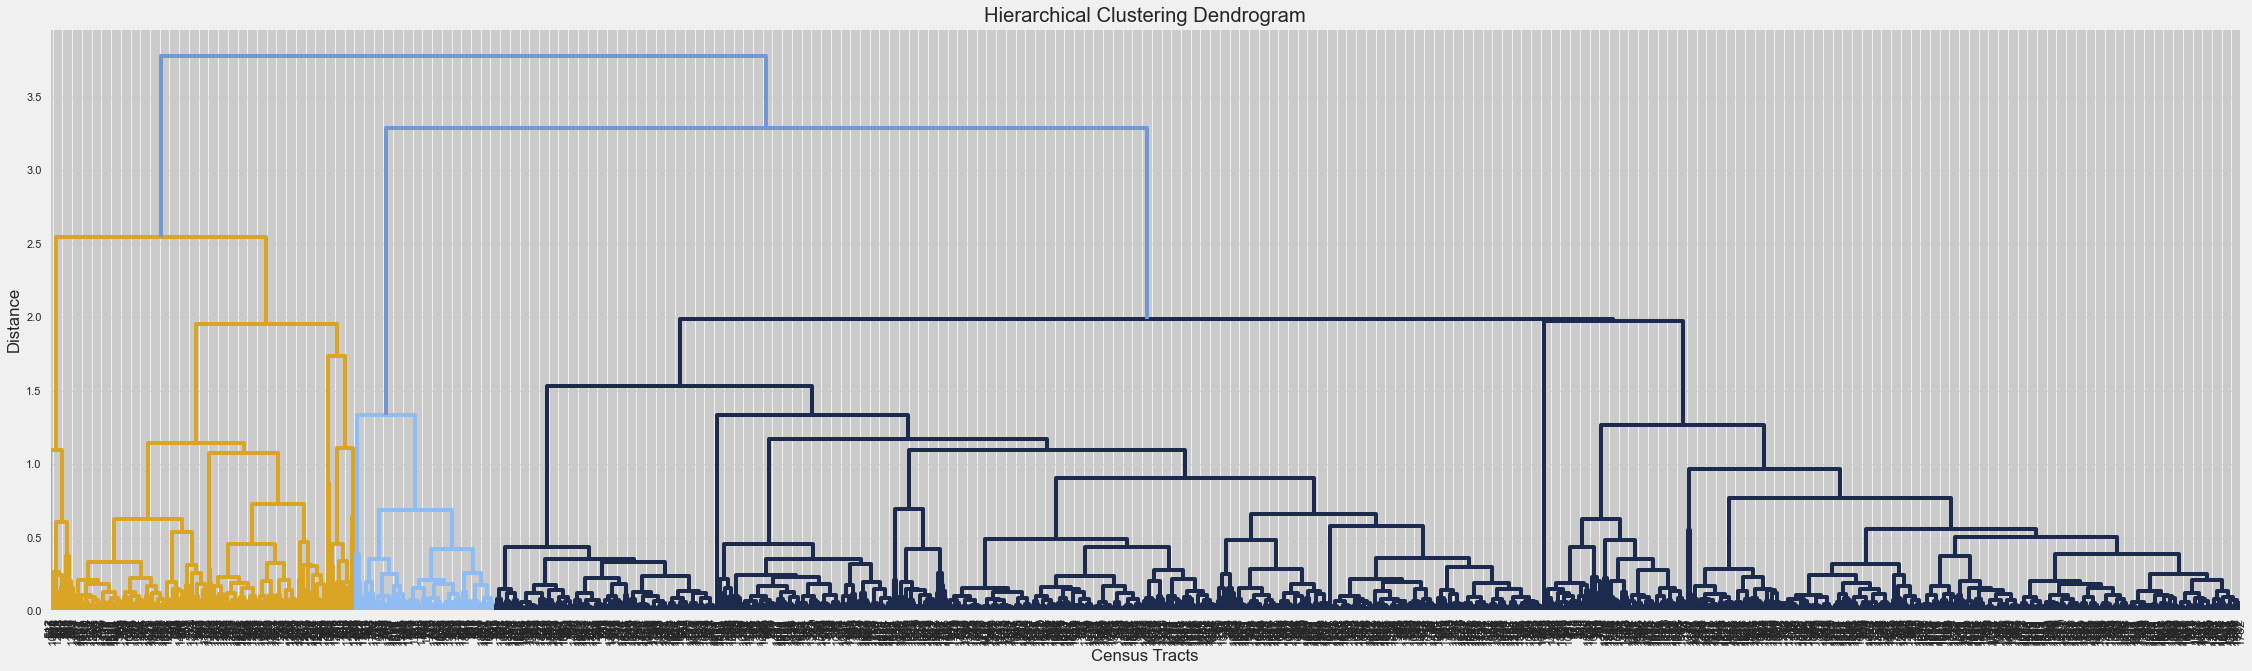

In [8]:
plt.figure(figsize=(35, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Census Tracts')
plt.ylabel('Distance')
plt.xticks([])
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_font_size=12.,
    show_contracted=True,# font size for the x axis labels
)
plt.savefig('Images/hac_tracts.png', dpi=300, 
            bbox_inches= 'tight', padding_inches = 4, transparent = True )

### Providing a truncated view of the HAC

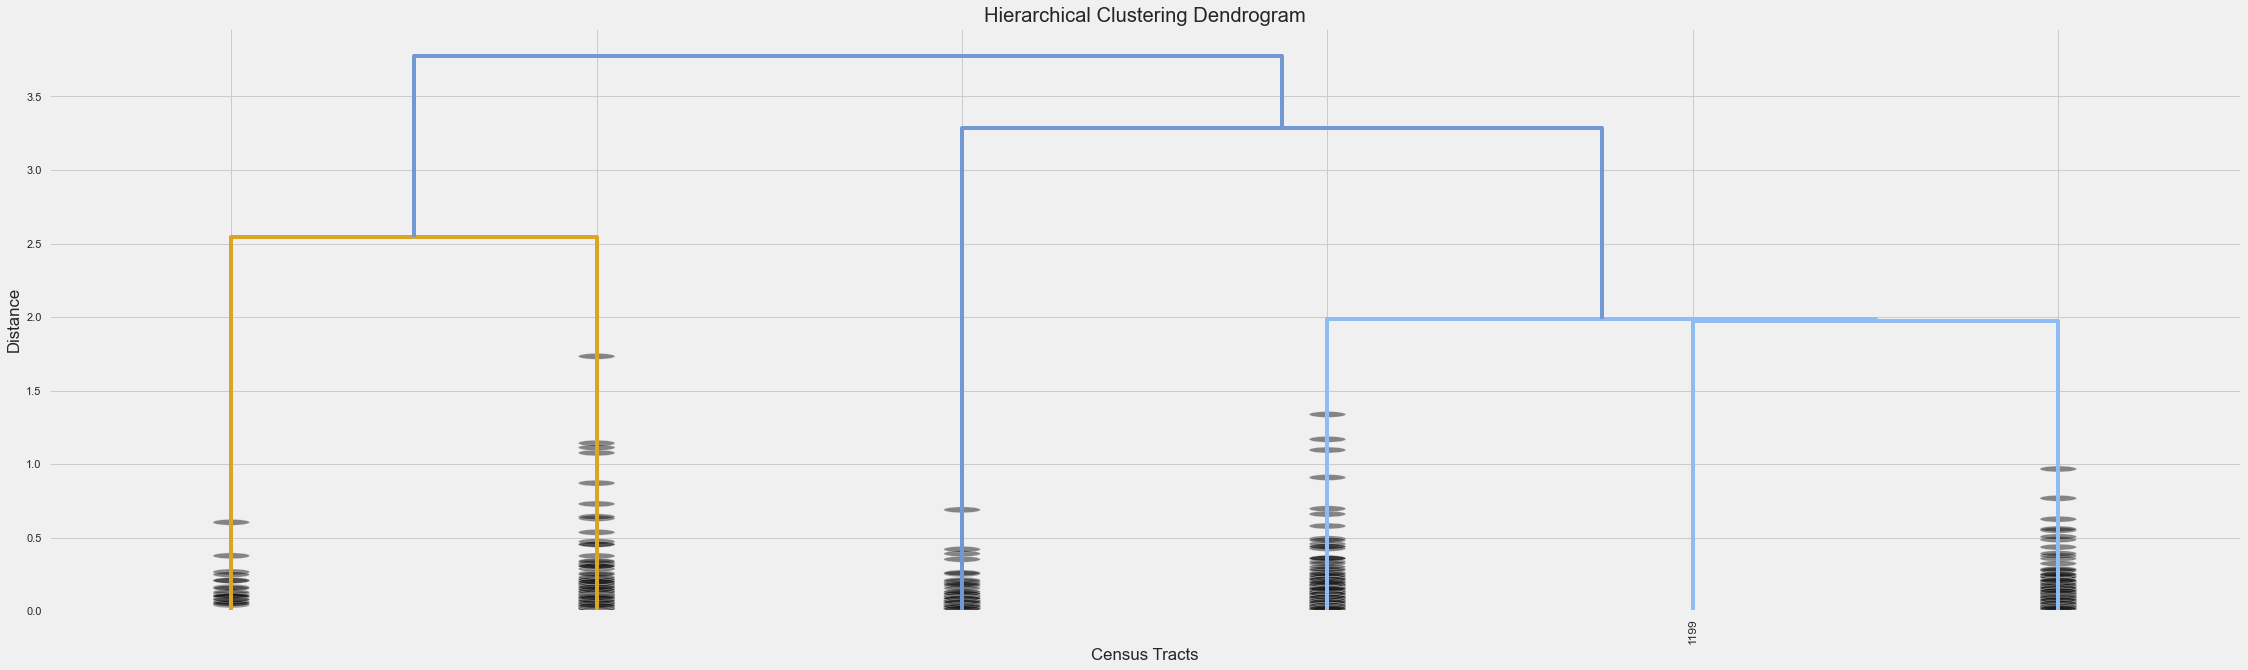

In [9]:
plt.figure(figsize=(35, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Census Tracts')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    truncate_mode='lastp',  # show only the last p merged clusters
    p=6,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_font_size=12.,
    show_contracted=True,# font size for the x axis labels
)
plt.savefig('Images/hac_tracts.png', dpi=300, 
            bbox_inches= 'tight', padding_inches = 4, transparent = True )

In [11]:
model4 = AgglomerativeClustering(n_clusters=4,linkage='ward')
model4.fit(df_scaled.values)

AgglomerativeClustering(n_clusters=4)

In [12]:
# create a new dataframe showing the clusters and scaled data

cluster_df = pd.DataFrame()
cluster_df['tractid']= df_scaled.index.values
cluster_df['cluster']=model4.labels_

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_df['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(df_scaled.values, cluster_df['cluster'])}")


Distribution of clusters:
0    979
2    576
3    268
1    144
Name: cluster, dtype: int64
Silhouette score: 0.036544755744942516


### Silhouette Score 

The results are not promising. 

# PCA

Principal components provide feature selection based on the amount of variance I want to predict. 

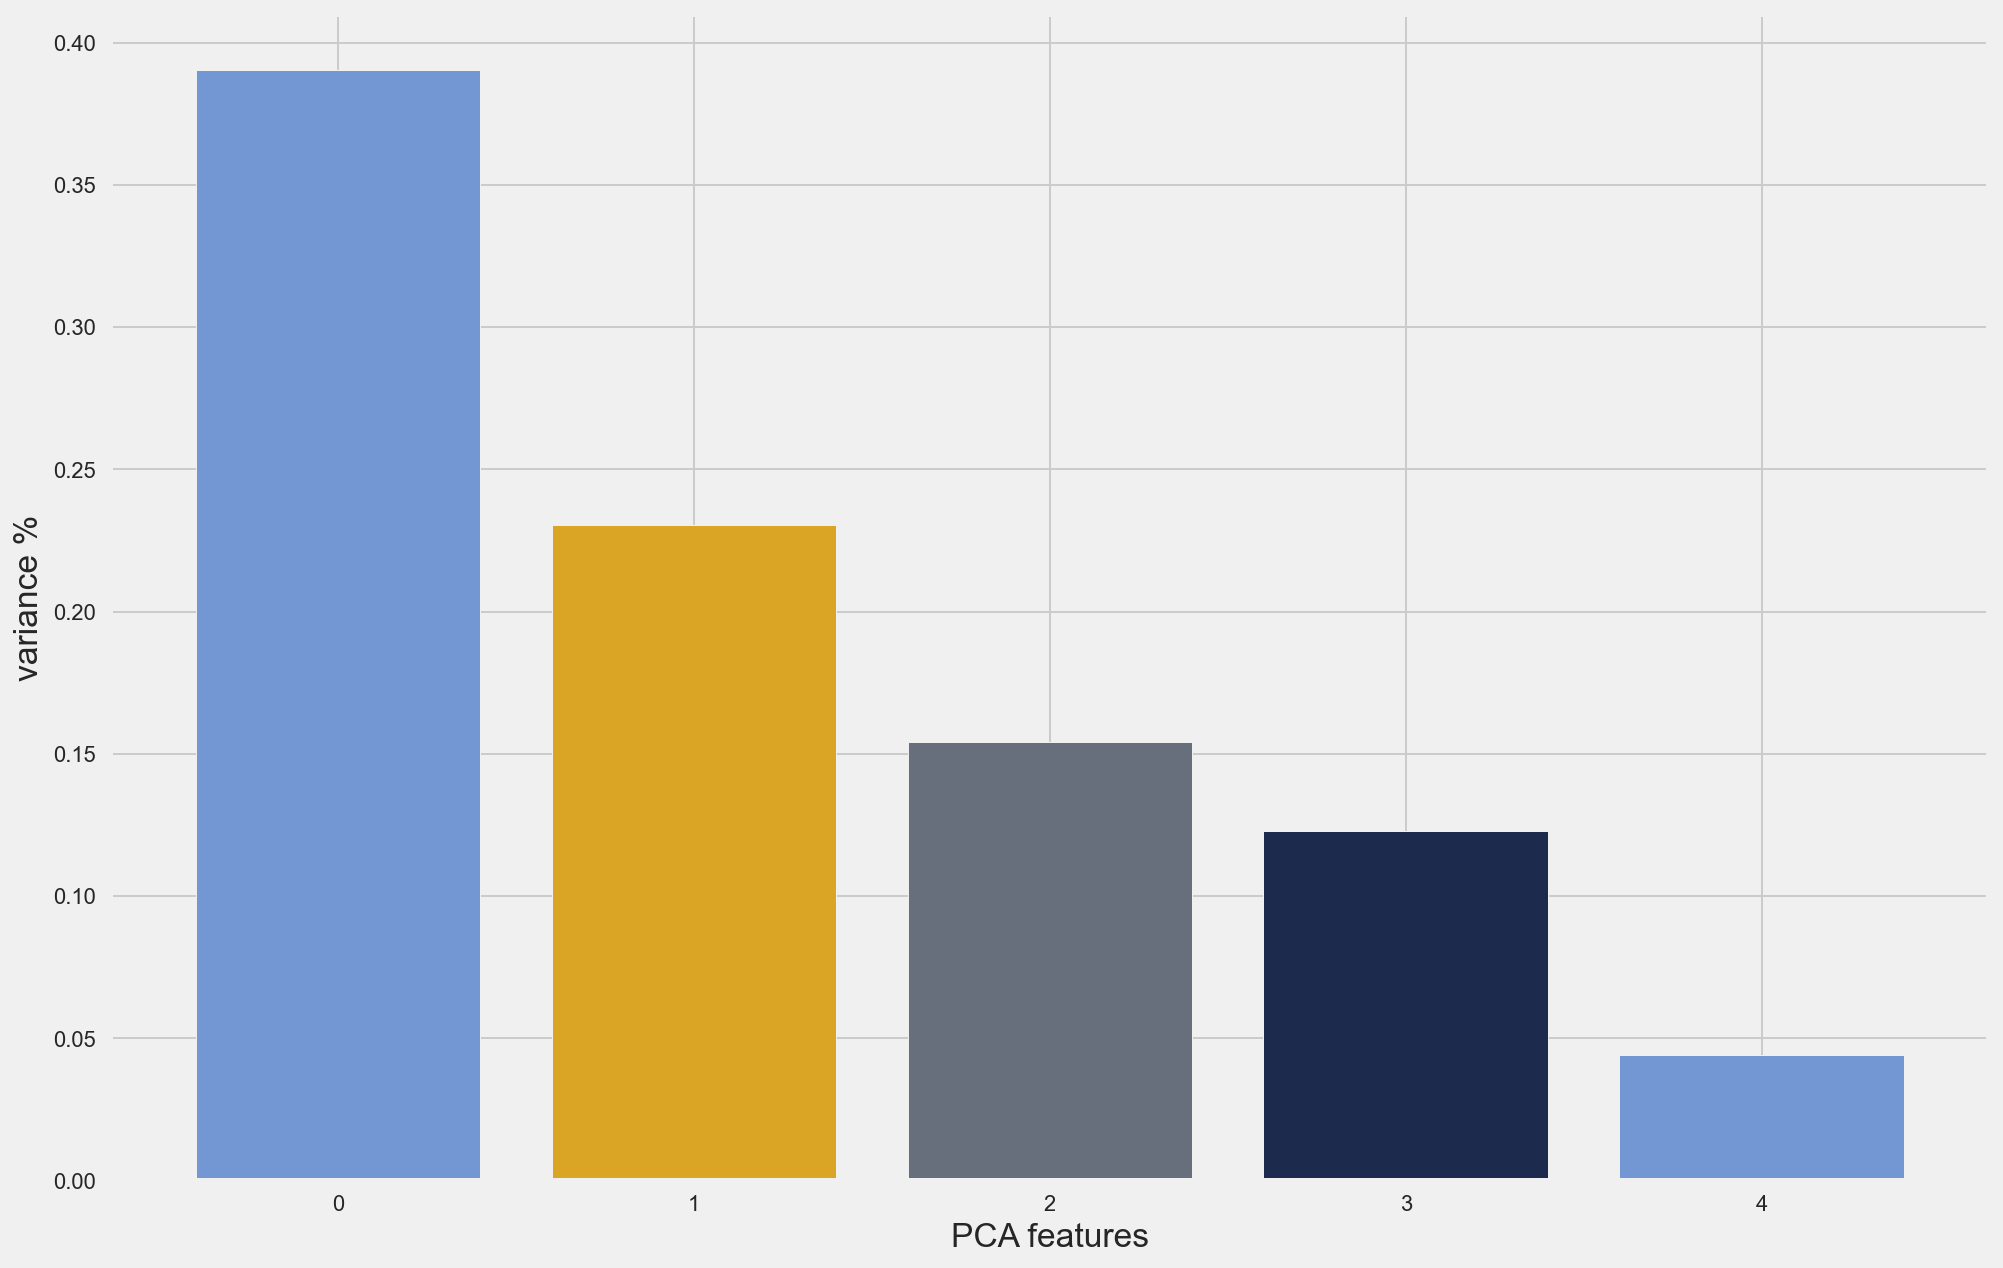

In [13]:
# Imports
X = df_scaled_gent1.copy()

from sklearn.decomposition import PCA

%config InlineBackend.figure_format='retina'
# Standardize the data to have a mean of ~0 and a variance of 1
X_std =  MinMaxScaler().fit_transform(X)
# Create a PCA instance: pca
pca = PCA(n_components=.9)
principalComponents = pca.fit_transform(X_std)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color=('#7297d2','#daa525', '#676e7c', '#1b2a4d'))
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Text(0, 0.5, 'PCA 2')

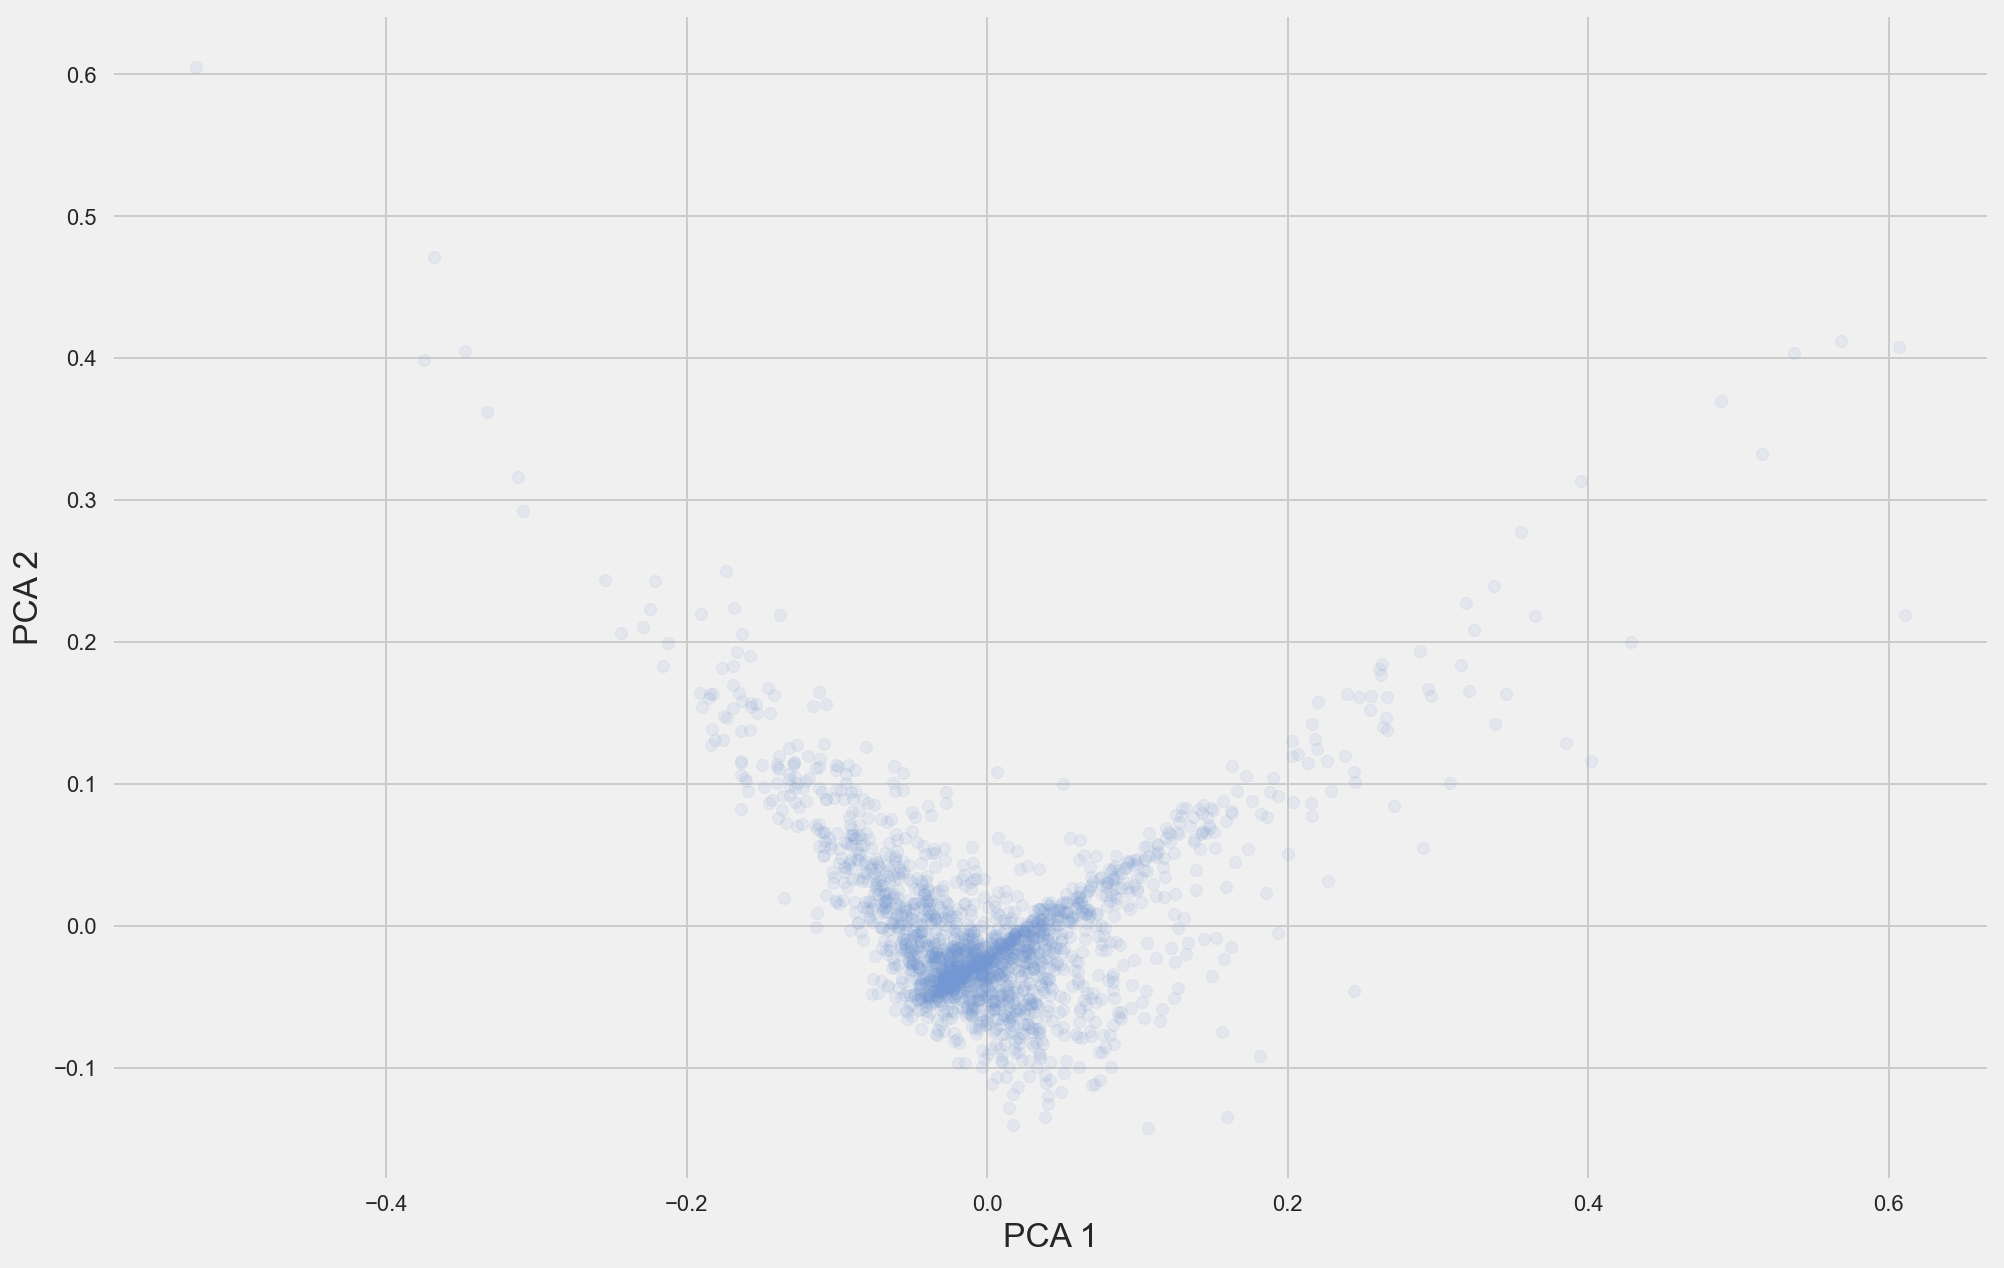

In [14]:
PCA_components = PCA_components.set_index(X.index)


plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color=('#7297d2'))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')


Text(0, 0.5, 'PCA 4')

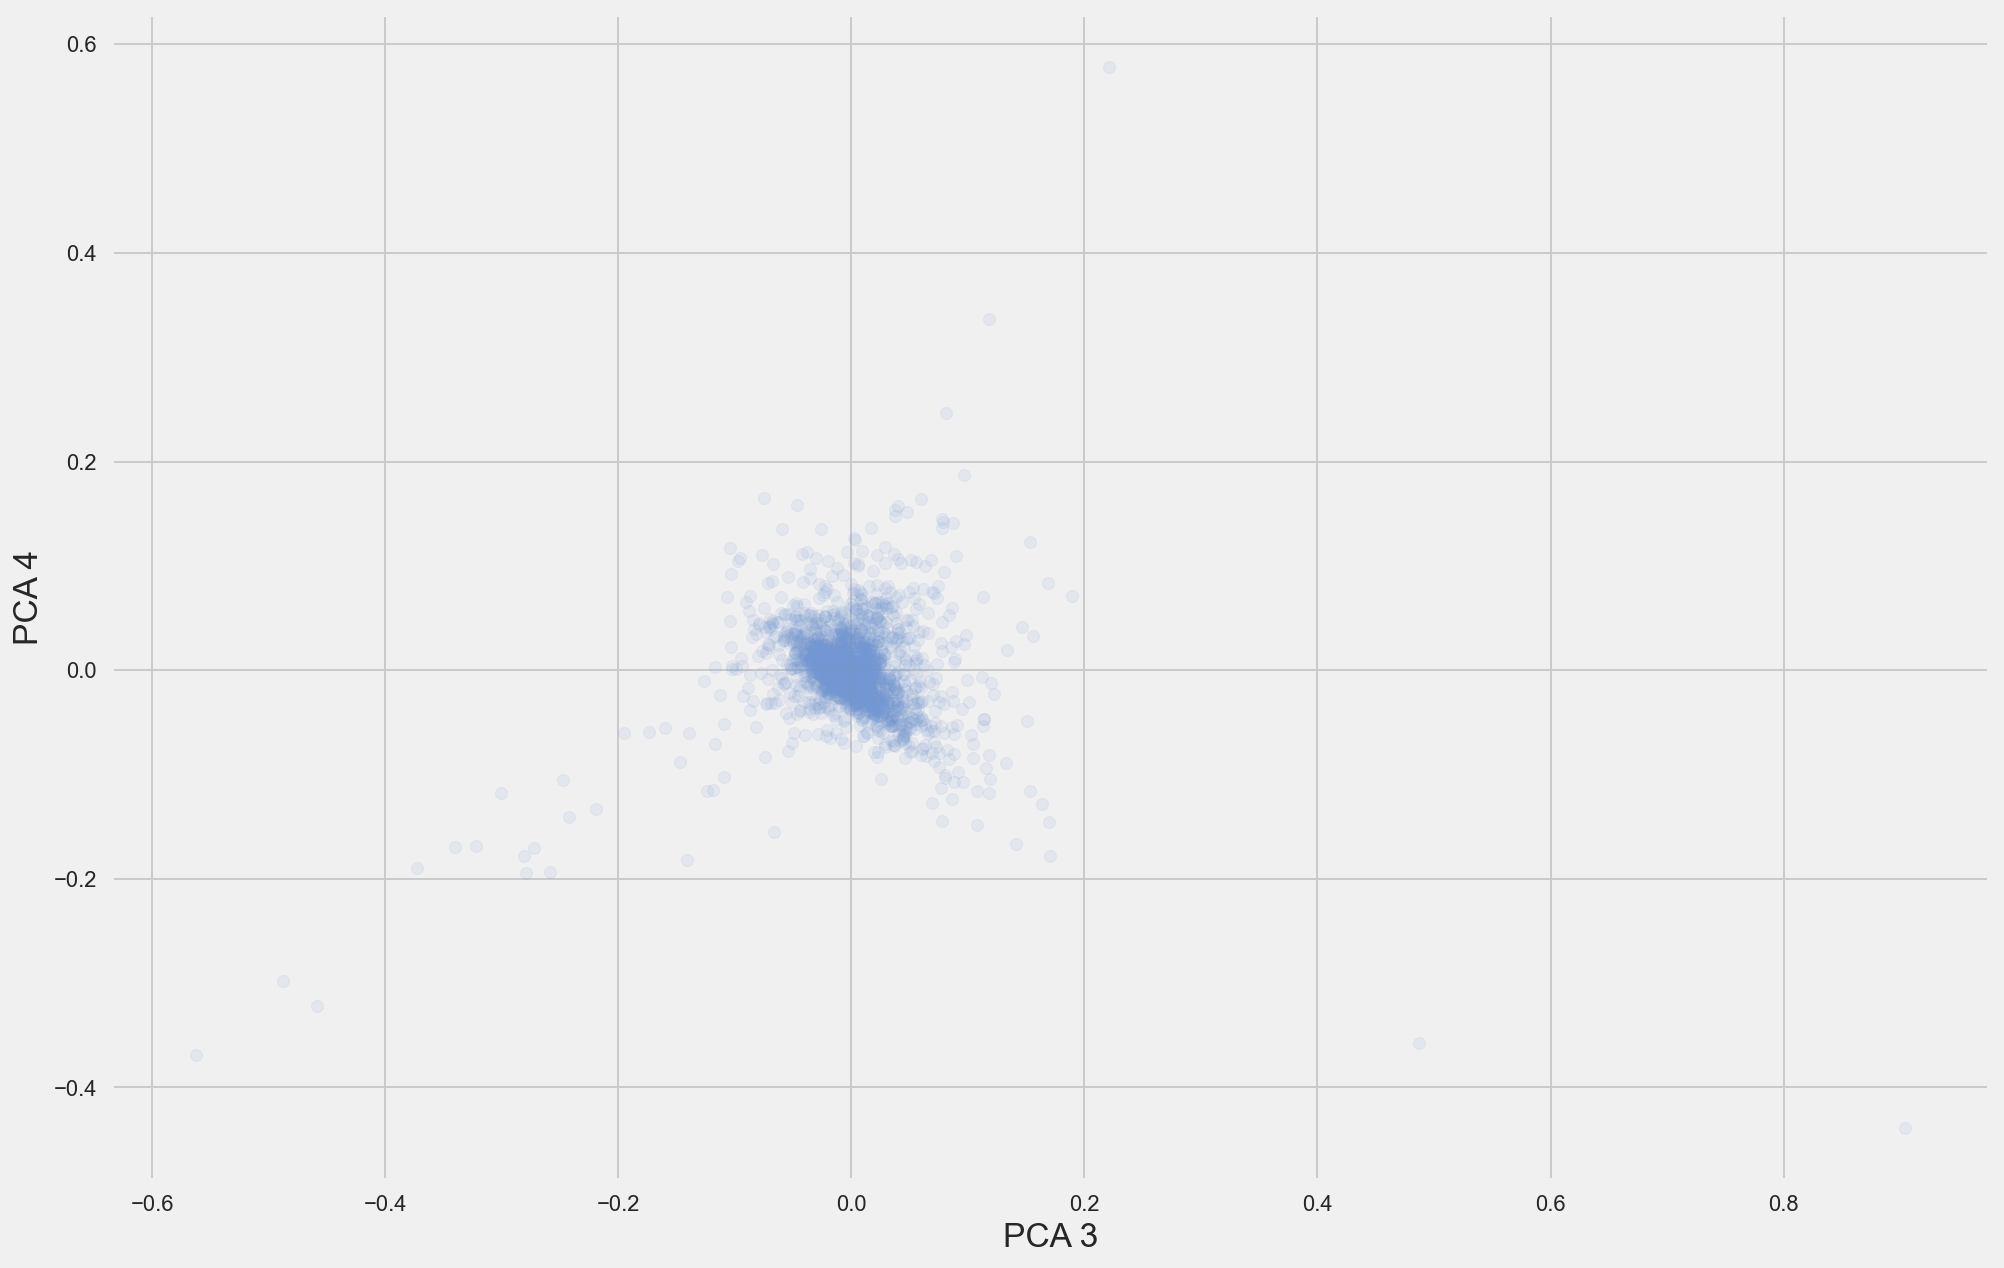

In [15]:
plt.scatter(PCA_components[2], PCA_components[3], alpha=.1, color=('#7297d2'))
plt.xlabel('PCA 3')
plt.ylabel('PCA 4')


## Looking at the loadings for the principal components 

In [16]:
eig_values = pca.explained_variance_
eig_vectors = pca.components_

pc1 = pca.components_[0]
pc2 = pca.components_[1]
pc3 = pca.components_[2]
pc4 = pca.components_[3]
pc5 = pca.components_[4]

In [17]:
# get the loadings
structure_loading_1 = pc1* np.sqrt(eig_values[0])
str_loading_1 = pd.Series(structure_loading_1, index=X.columns.values)
str_loading_1

HINC12_HINC00          0.013478
MHMVAL12_MHMVAL00      0.001384
MRENT12_MRENT00        0.023385
OWN10%_OWN00%          0.004233
NONWHT10%_NONWHT00%   -0.052203
COL12%_COL00%          0.046777
NHWHT10%_NHWHT00%      0.040283
dtype: float64

In [18]:
structure_loading_2 = pc2* np.sqrt(eig_values[1])
str_loading_2 = pd.Series(structure_loading_2, index=X.columns.values)
str_loading_2

HINC12_HINC00          0.005734
MHMVAL12_MHMVAL00      0.000043
MRENT12_MRENT00        0.006375
OWN10%_OWN00%          0.001238
NONWHT10%_NONWHT00%    0.051393
COL12%_COL00%          0.028644
NHWHT10%_NHWHT00%      0.027587
dtype: float64

In [19]:
structure_loading_3 = pc3* np.sqrt(eig_values[2])
str_loading_3 = pd.Series(structure_loading_3, index=X.columns.values)
str_loading_3

HINC12_HINC00          0.014523
MHMVAL12_MHMVAL00     -0.000776
MRENT12_MRENT00        0.034544
OWN10%_OWN00%          0.002755
NONWHT10%_NONWHT00%    0.005001
COL12%_COL00%          0.014208
NHWHT10%_NHWHT00%     -0.035193
dtype: float64

In [20]:
structure_loading_4 = pc4* np.sqrt(eig_values[3])
str_loading_4 = pd.Series(structure_loading_4, index=X.columns.values)
str_loading_4

HINC12_HINC00         -0.007108
MHMVAL12_MHMVAL00     -0.000984
MRENT12_MRENT00       -0.029580
OWN10%_OWN00%          0.000352
NONWHT10%_NONWHT00%   -0.002349
COL12%_COL00%          0.031155
NHWHT10%_NHWHT00%     -0.019674
dtype: float64

In [21]:
structure_loading_5 = pc5* np.sqrt(eig_values[4])
str_loading_5 = pd.Series(structure_loading_5, index=X.columns.values)
str_loading_5

HINC12_HINC00          0.011800
MHMVAL12_MHMVAL00      0.001791
MRENT12_MRENT00       -0.005656
OWN10%_OWN00%          0.025260
NONWHT10%_NONWHT00%    0.000239
COL12%_COL00%         -0.002786
NHWHT10%_NHWHT00%      0.000165
dtype: float64

([<matplotlib.axis.XTick at 0x7f81d0984a00>,
 [Text(0, 0, 'PCA1'),
  Text(0, 0, 'PCA2'),
  Text(0, 0, 'PCA3'),
  Text(0, 0, 'PCA4'),
  Text(0, 0, 'PCA5')])

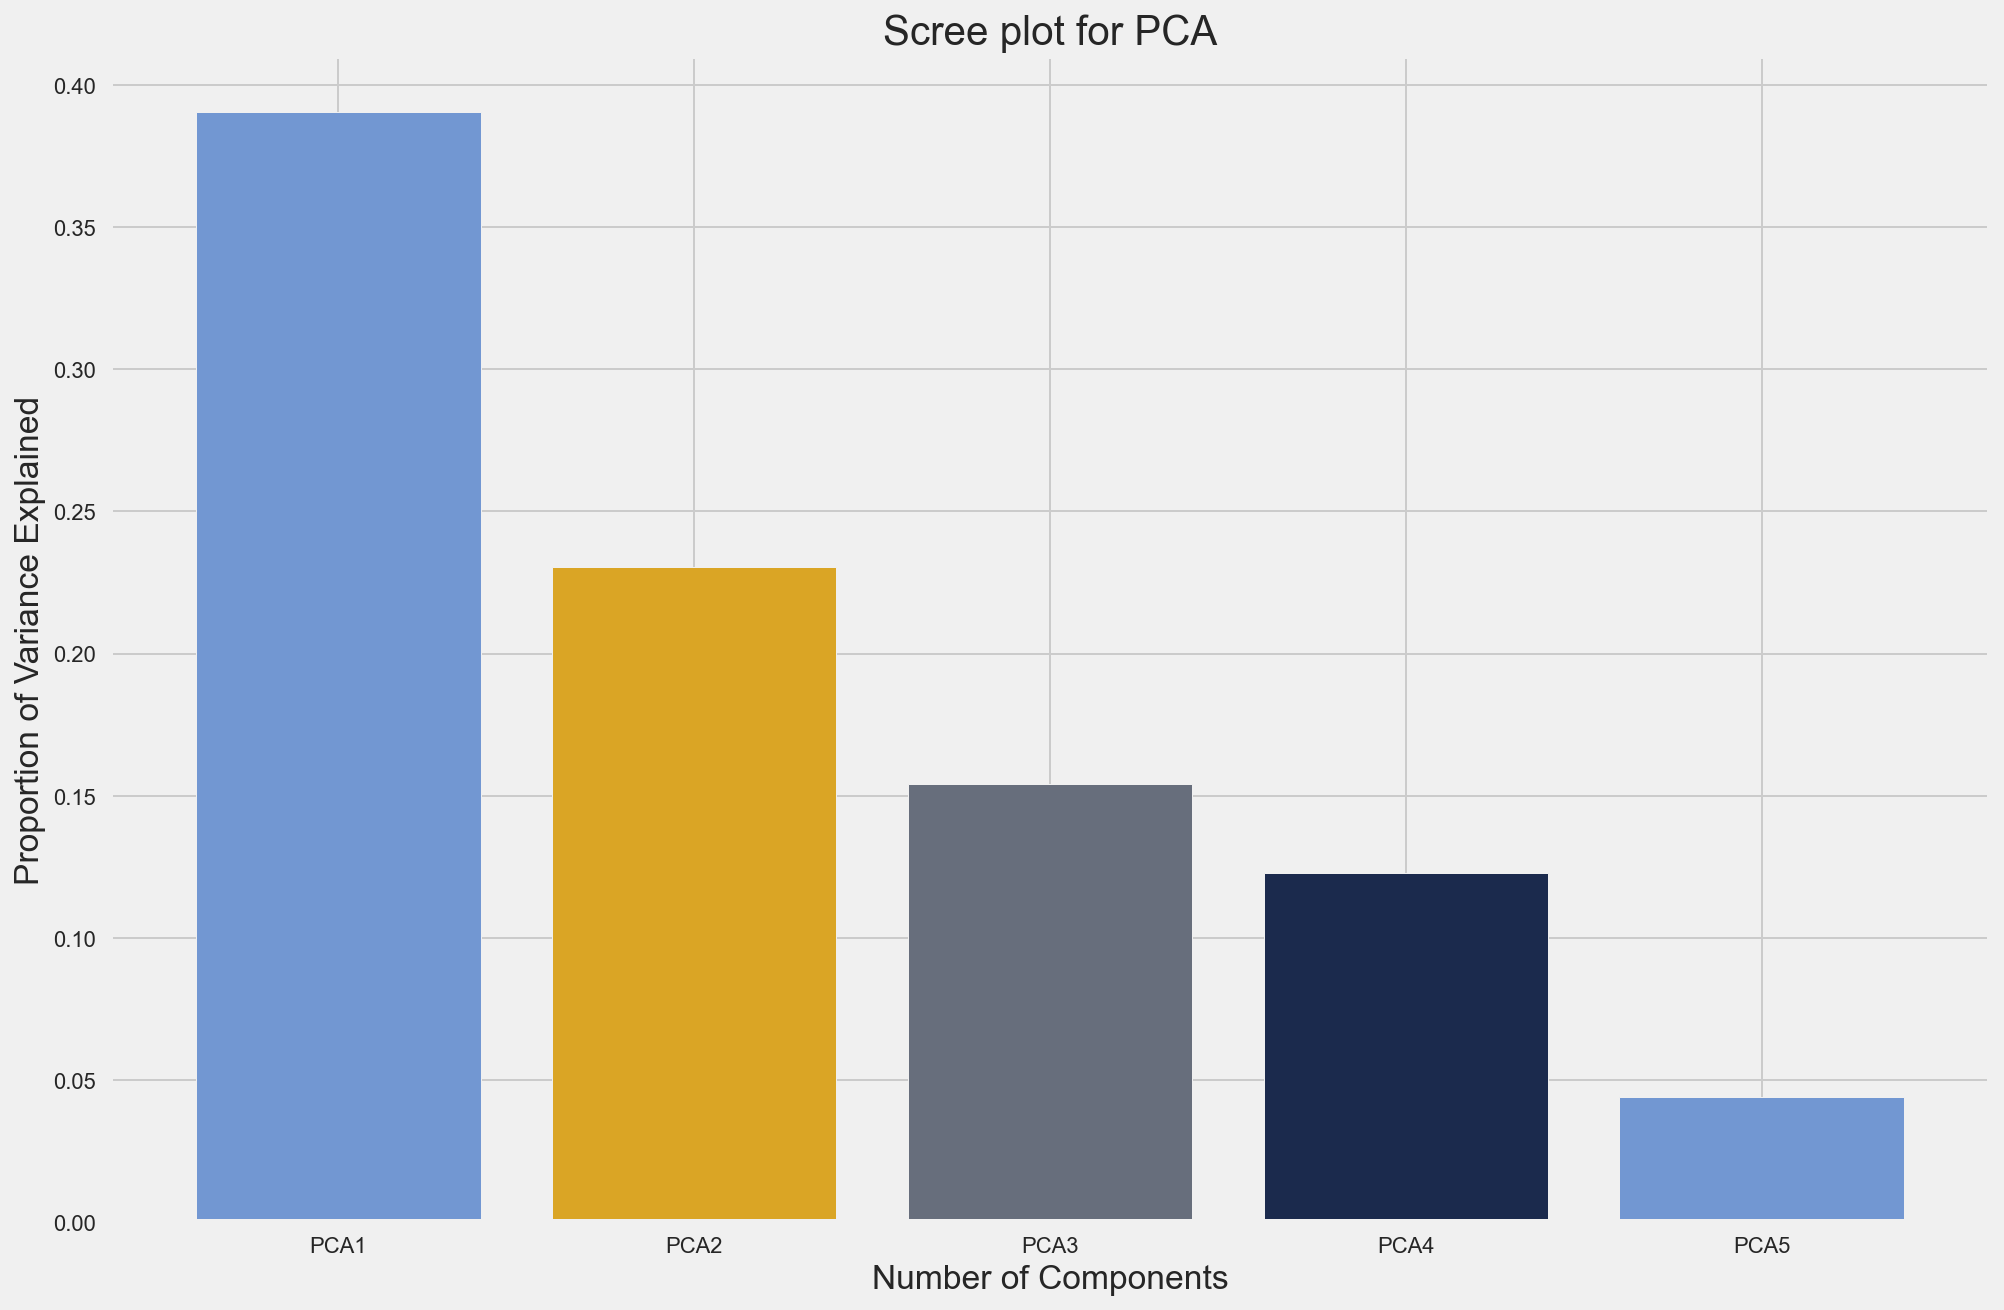

In [22]:
index = np.arange(len(PCA_components.columns.values))
plt.bar(index, pca.explained_variance_ratio_, color = ('#7297d2','#daa525', '#676e7c', '#1b2a4d'))
plt.title('Scree plot for PCA')
plt.xlabel('Number of Components')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(ticks = list(index),labels = ['PCA1','PCA2','PCA3','PCA4','PCA5'])

## 

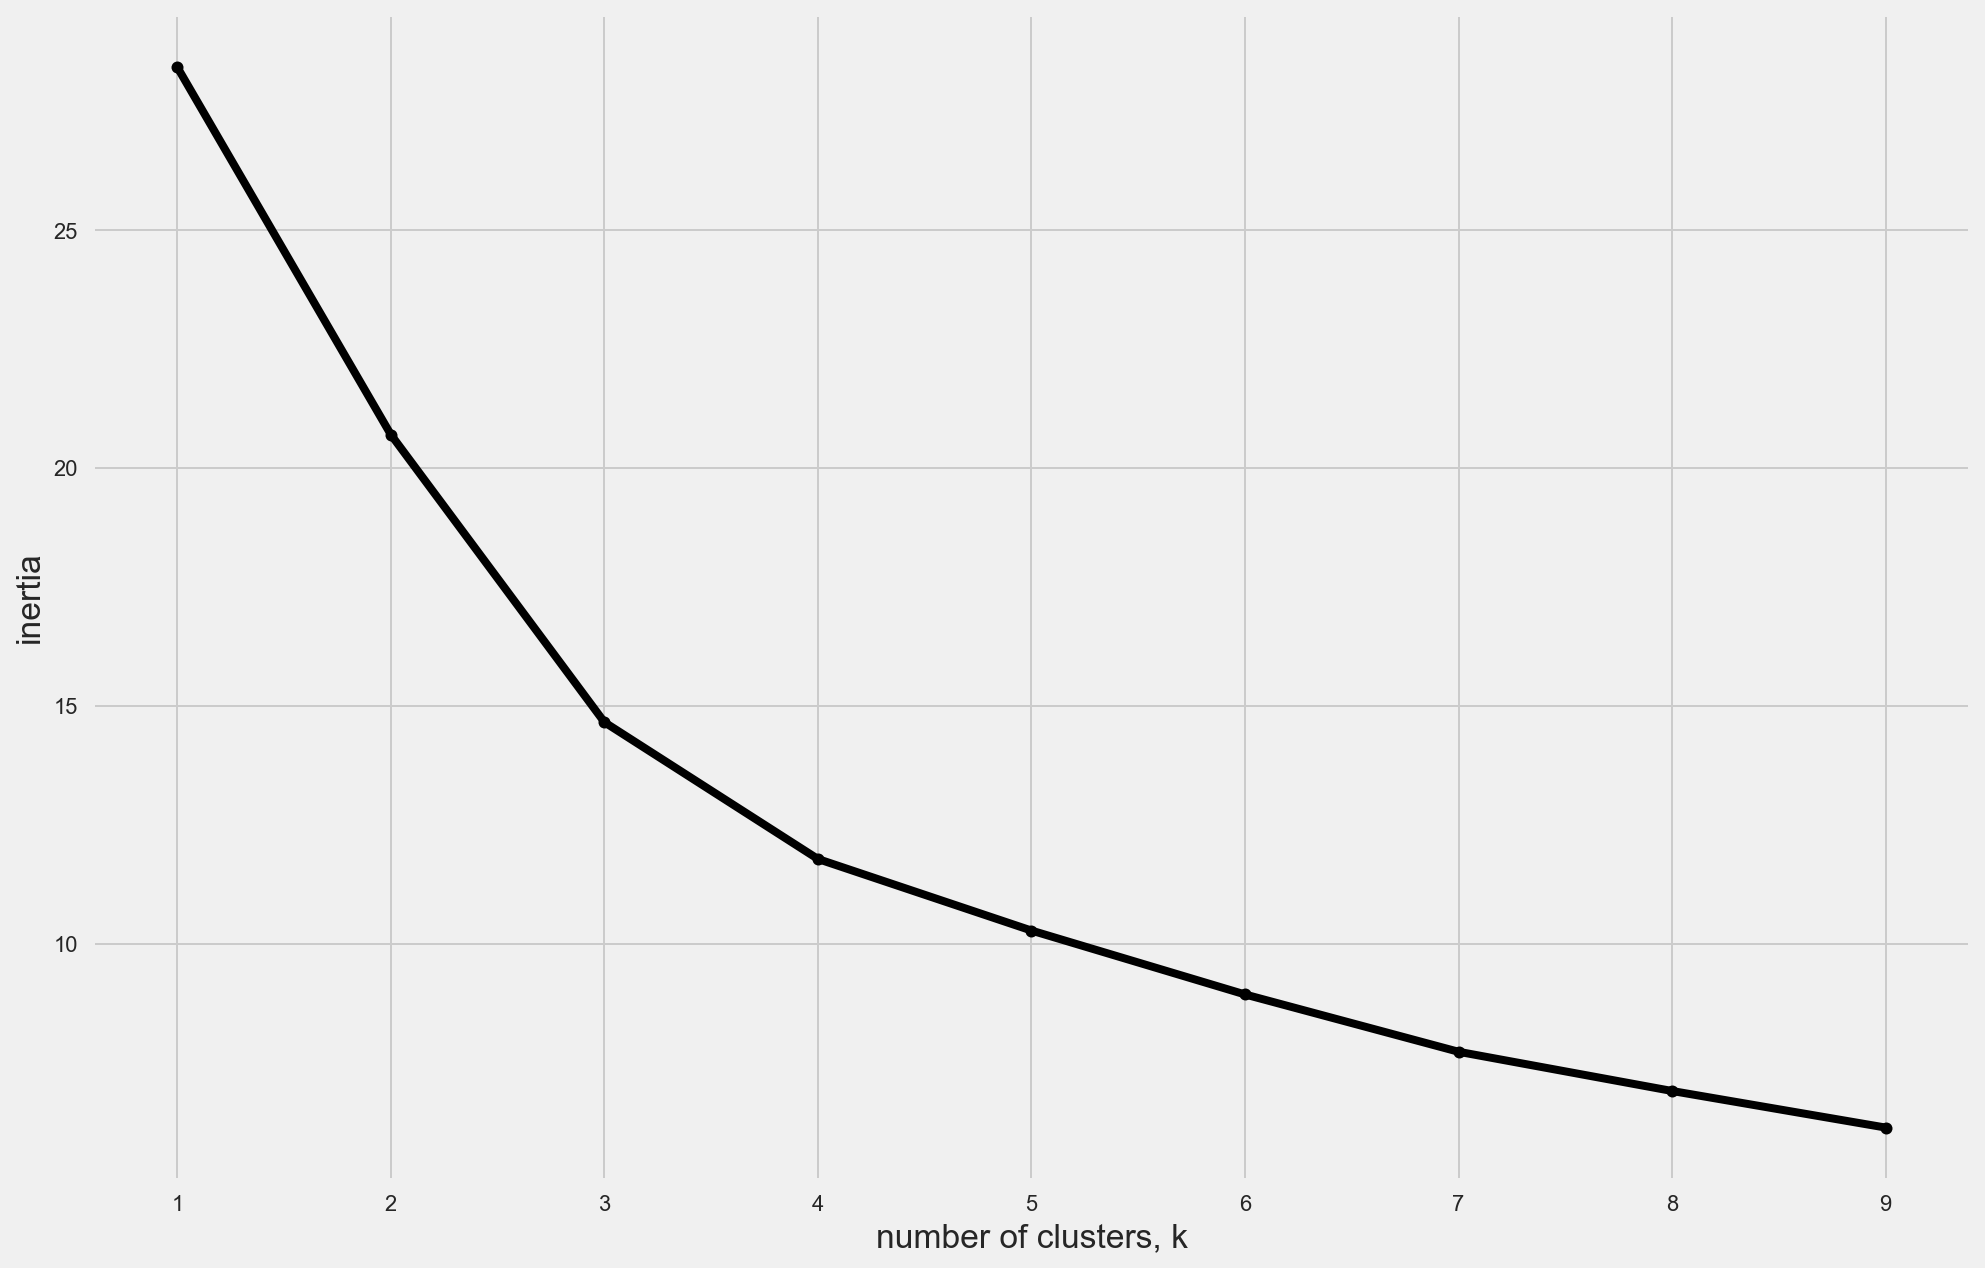

In [23]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

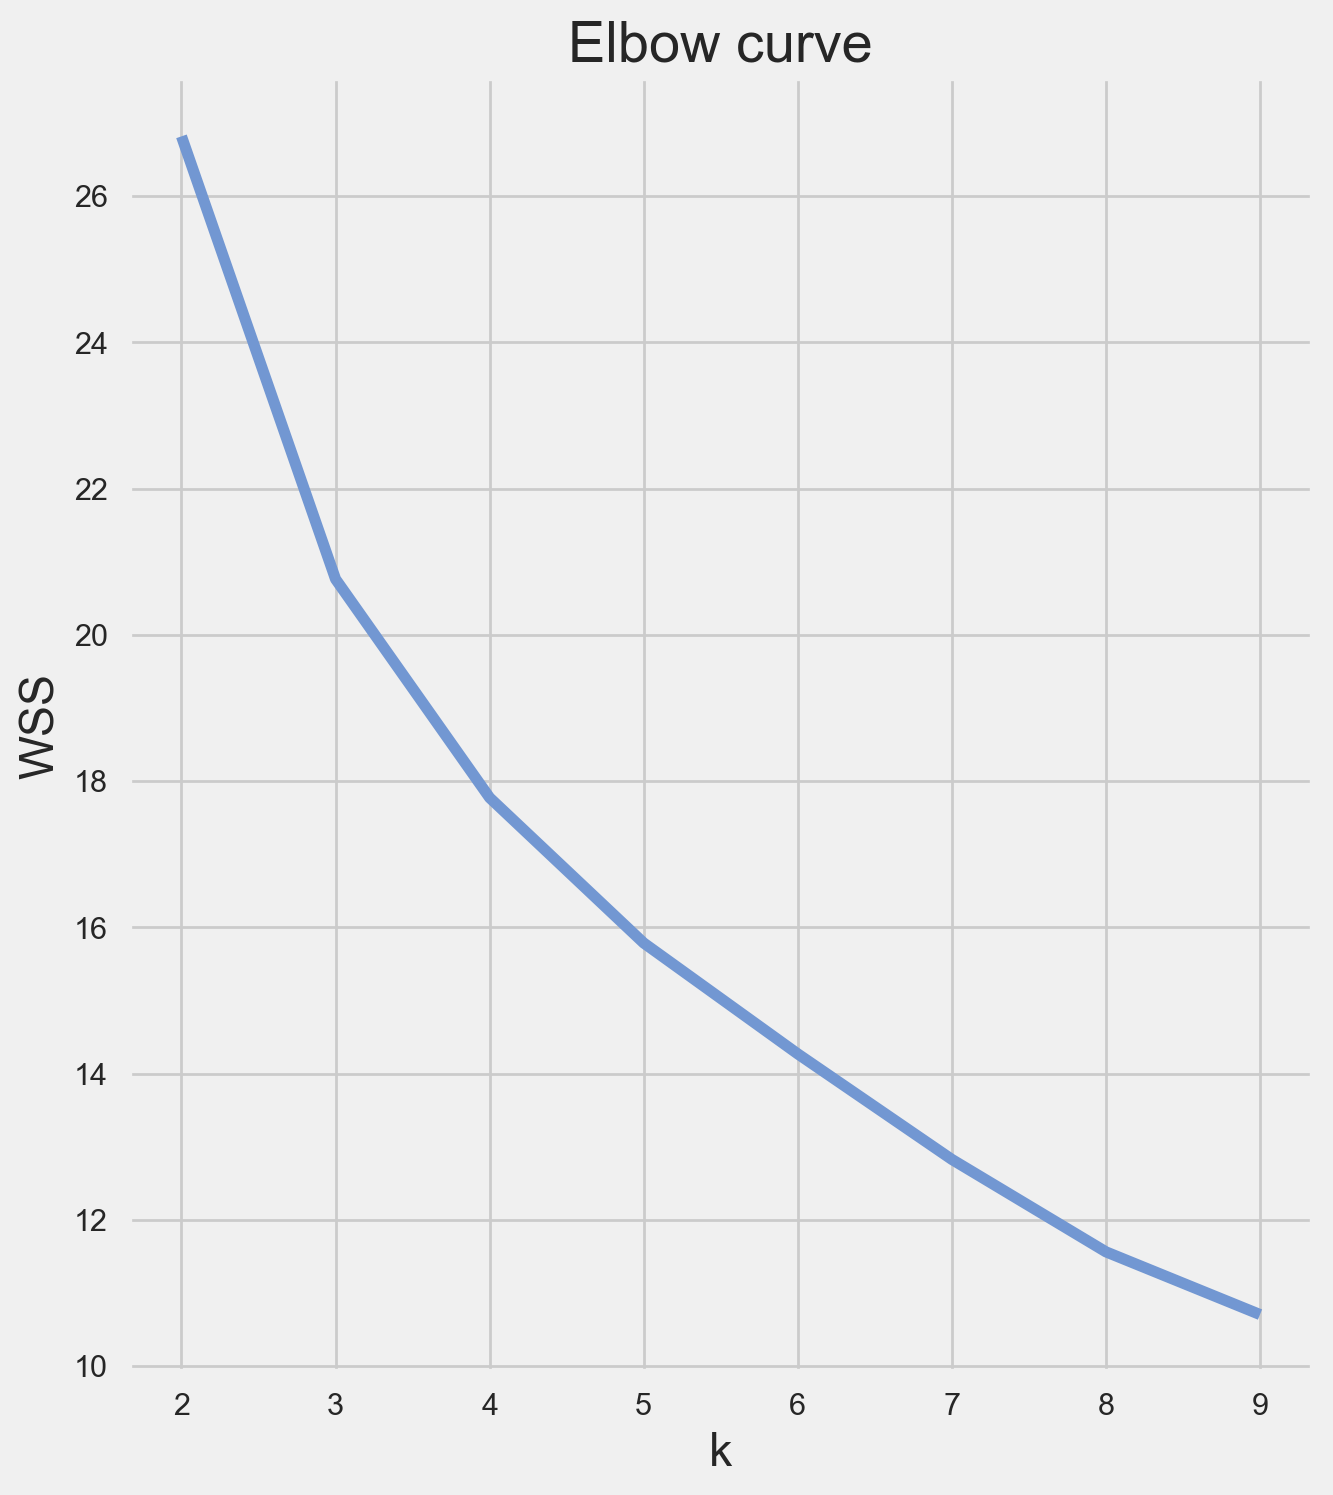

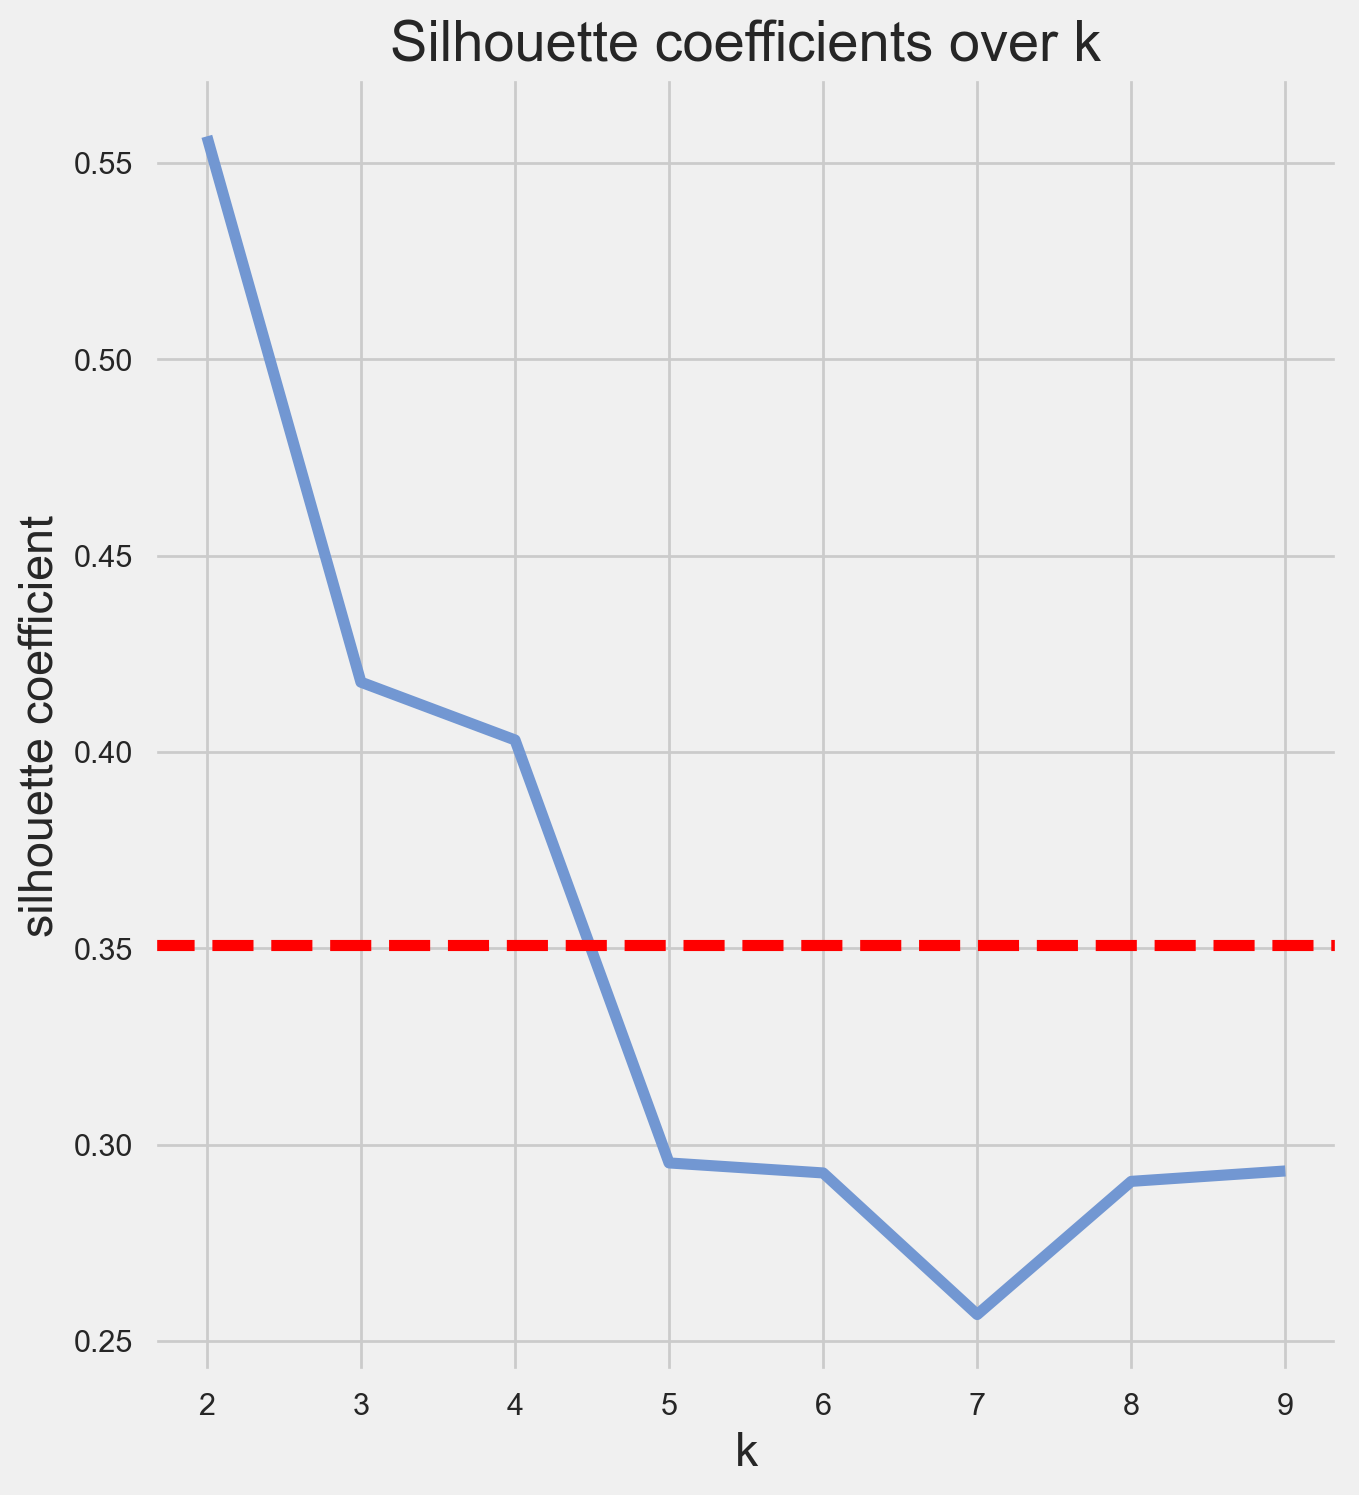

In [24]:

v = PCA_components # change this to test different 



X = v.copy()

distorsions = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state = 301)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

    # Plot values of SSE
plt.figure(figsize=(15,8),dpi=100)
plt.subplot(121, title='Elbow curve')
plt.xlabel('k')
plt.ylabel('WSS')
plt.plot(range(2, 10), distorsions)
plt.grid(True)

    # check silhouette
silhouette_plot = []
    # Calculate silhouette coefficient for different K
for k in range(2, 10):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)
    # Plot Silhouette coefficient
plt.figure(figsize=(15,8), dpi=100)
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(2, 10), silhouette_plot)
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
plt.grid(True)

# First of **TOP 2** Models

In [25]:
# fit the model with the scaled dataframe
model = KMeans(n_clusters=3).fit(PCA_components)

# create a new dataframe showing the clusters and scaled data
cluster_pca3 = pd.DataFrame()
cluster_pca3['TRACTID']=PCA_components.index.values
cluster_pca3['cluster']=model.labels_
#cluster_df1 = helper.create_cluster_df(model1,df_scaled)

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_pca3['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(PCA_components.values, cluster_pca3['cluster'])}")

Distribution of clusters:
0    1575
1     276
2     116
Name: cluster, dtype: int64
Silhouette score: 0.42338209192589277


## Comparing the Silhouette Score of the different cluster count

3 Clusters seems to be the optimal number

In [26]:
# fit the model with the scaled dataframe
model = KMeans(n_clusters=5).fit(PCA_components)

# create a new dataframe showing the clusters and scaled data
cluster_pca = pd.DataFrame()
cluster_pca['TRACTID']=PCA_components.index.values
cluster_pca['cluster']=model.labels_
#cluster_df1 = helper.create_cluster_df(model1,df_scaled)

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_pca['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(PCA_components.values, cluster_pca['cluster'])}")

Distribution of clusters:
2    1142
1     502
0     232
4      68
3      23
Name: cluster, dtype: int64
Silhouette score: 0.29648543673482397


## PCA Using Second Subset

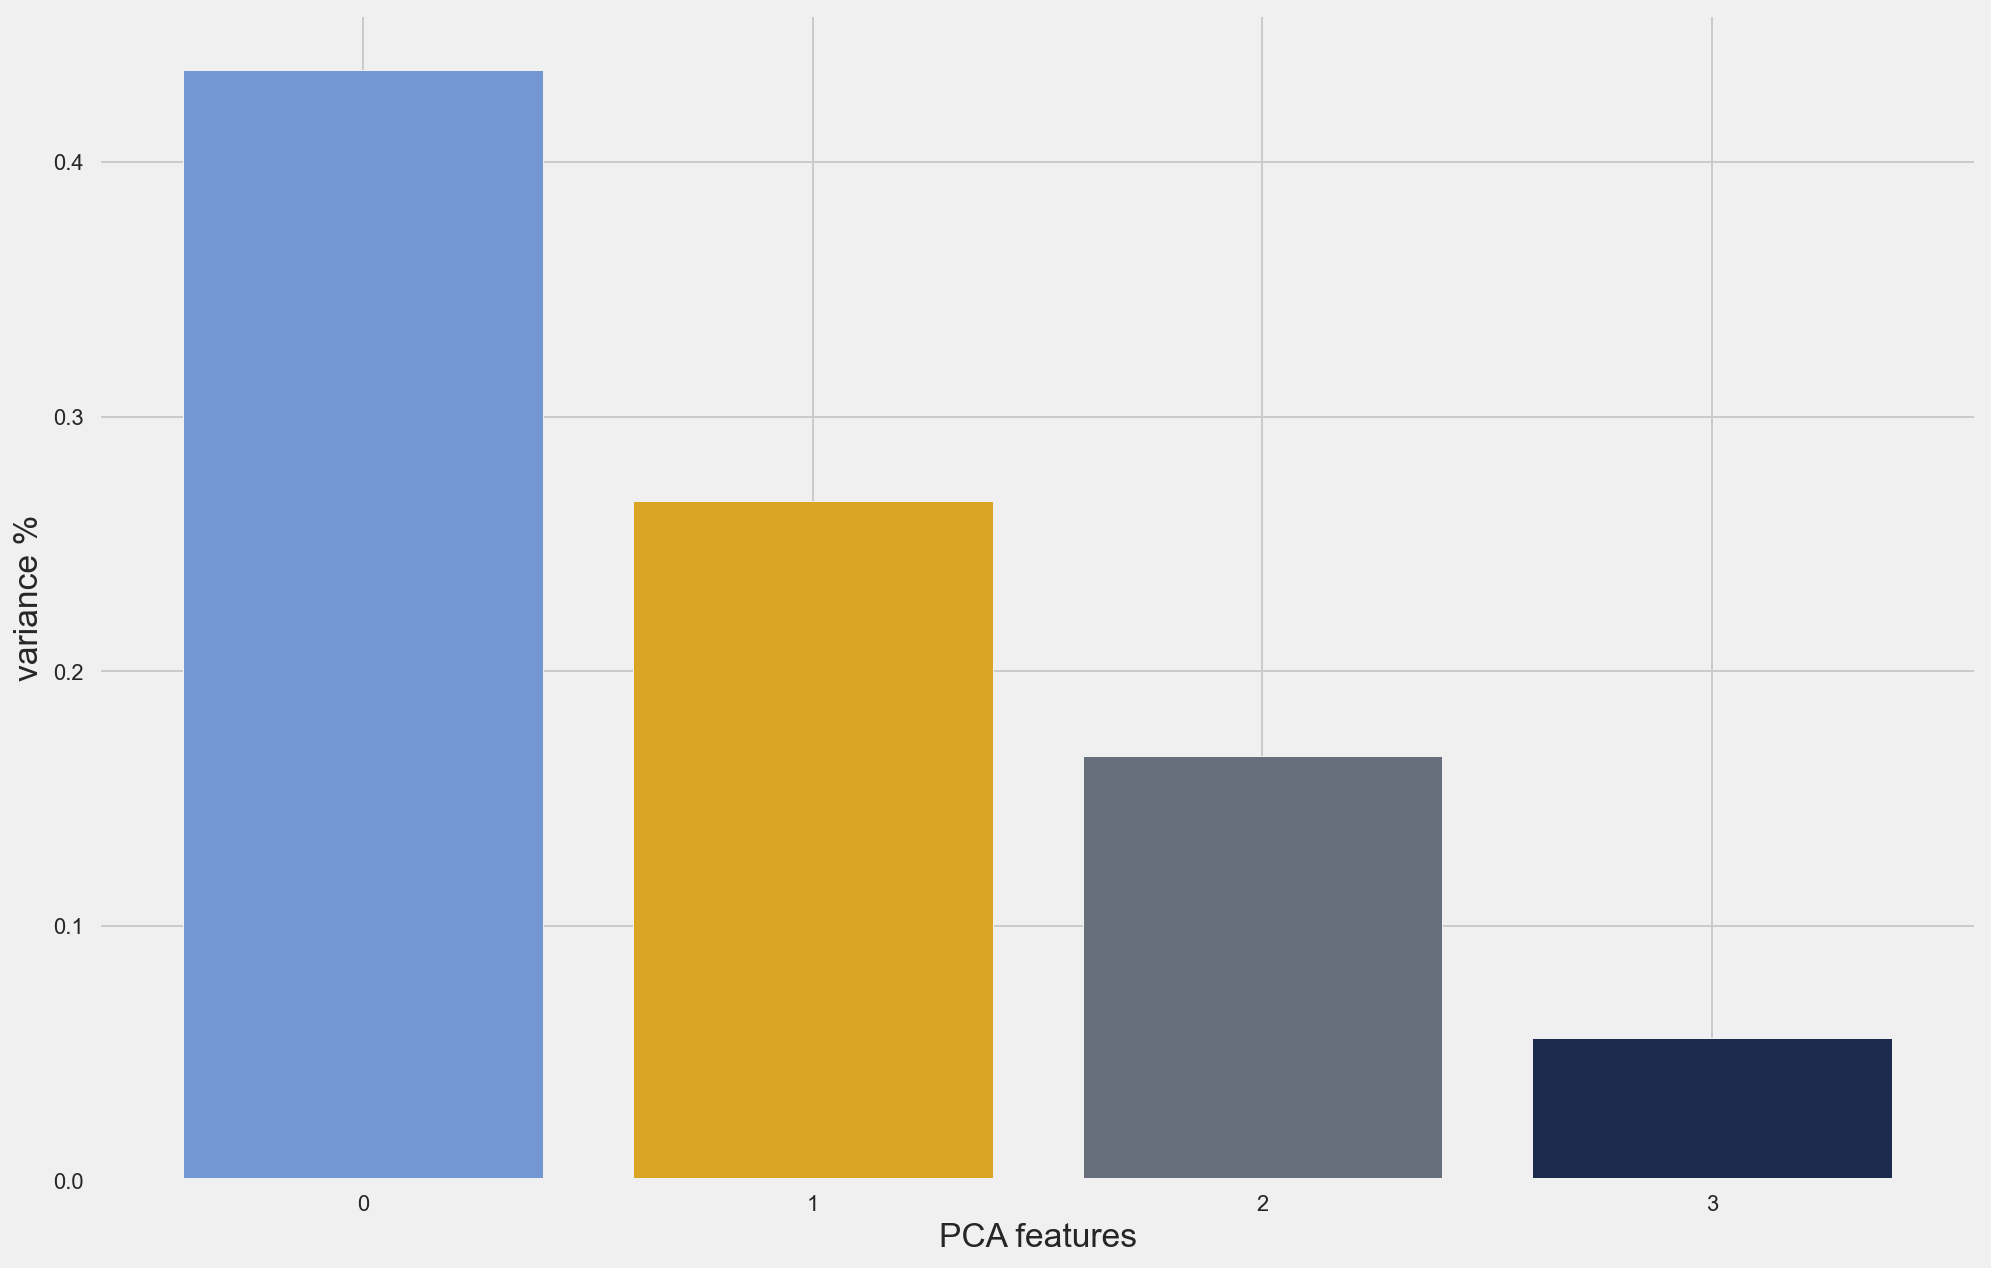

In [27]:
# Imports
X = df_scaled_gent2.copy()

from sklearn.decomposition import PCA

%config InlineBackend.figure_format='retina'
# Standardize the data to have a mean of ~0 and a variance of 1
X_std =  MinMaxScaler().fit_transform(X)
# Create a PCA instance: pca
pca = PCA(n_components=.9)
principalComponents = pca.fit_transform(X_std)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color=('#7297d2','#daa525', '#676e7c', '#1b2a4d'))
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Text(0, 0.5, 'PCA 2')

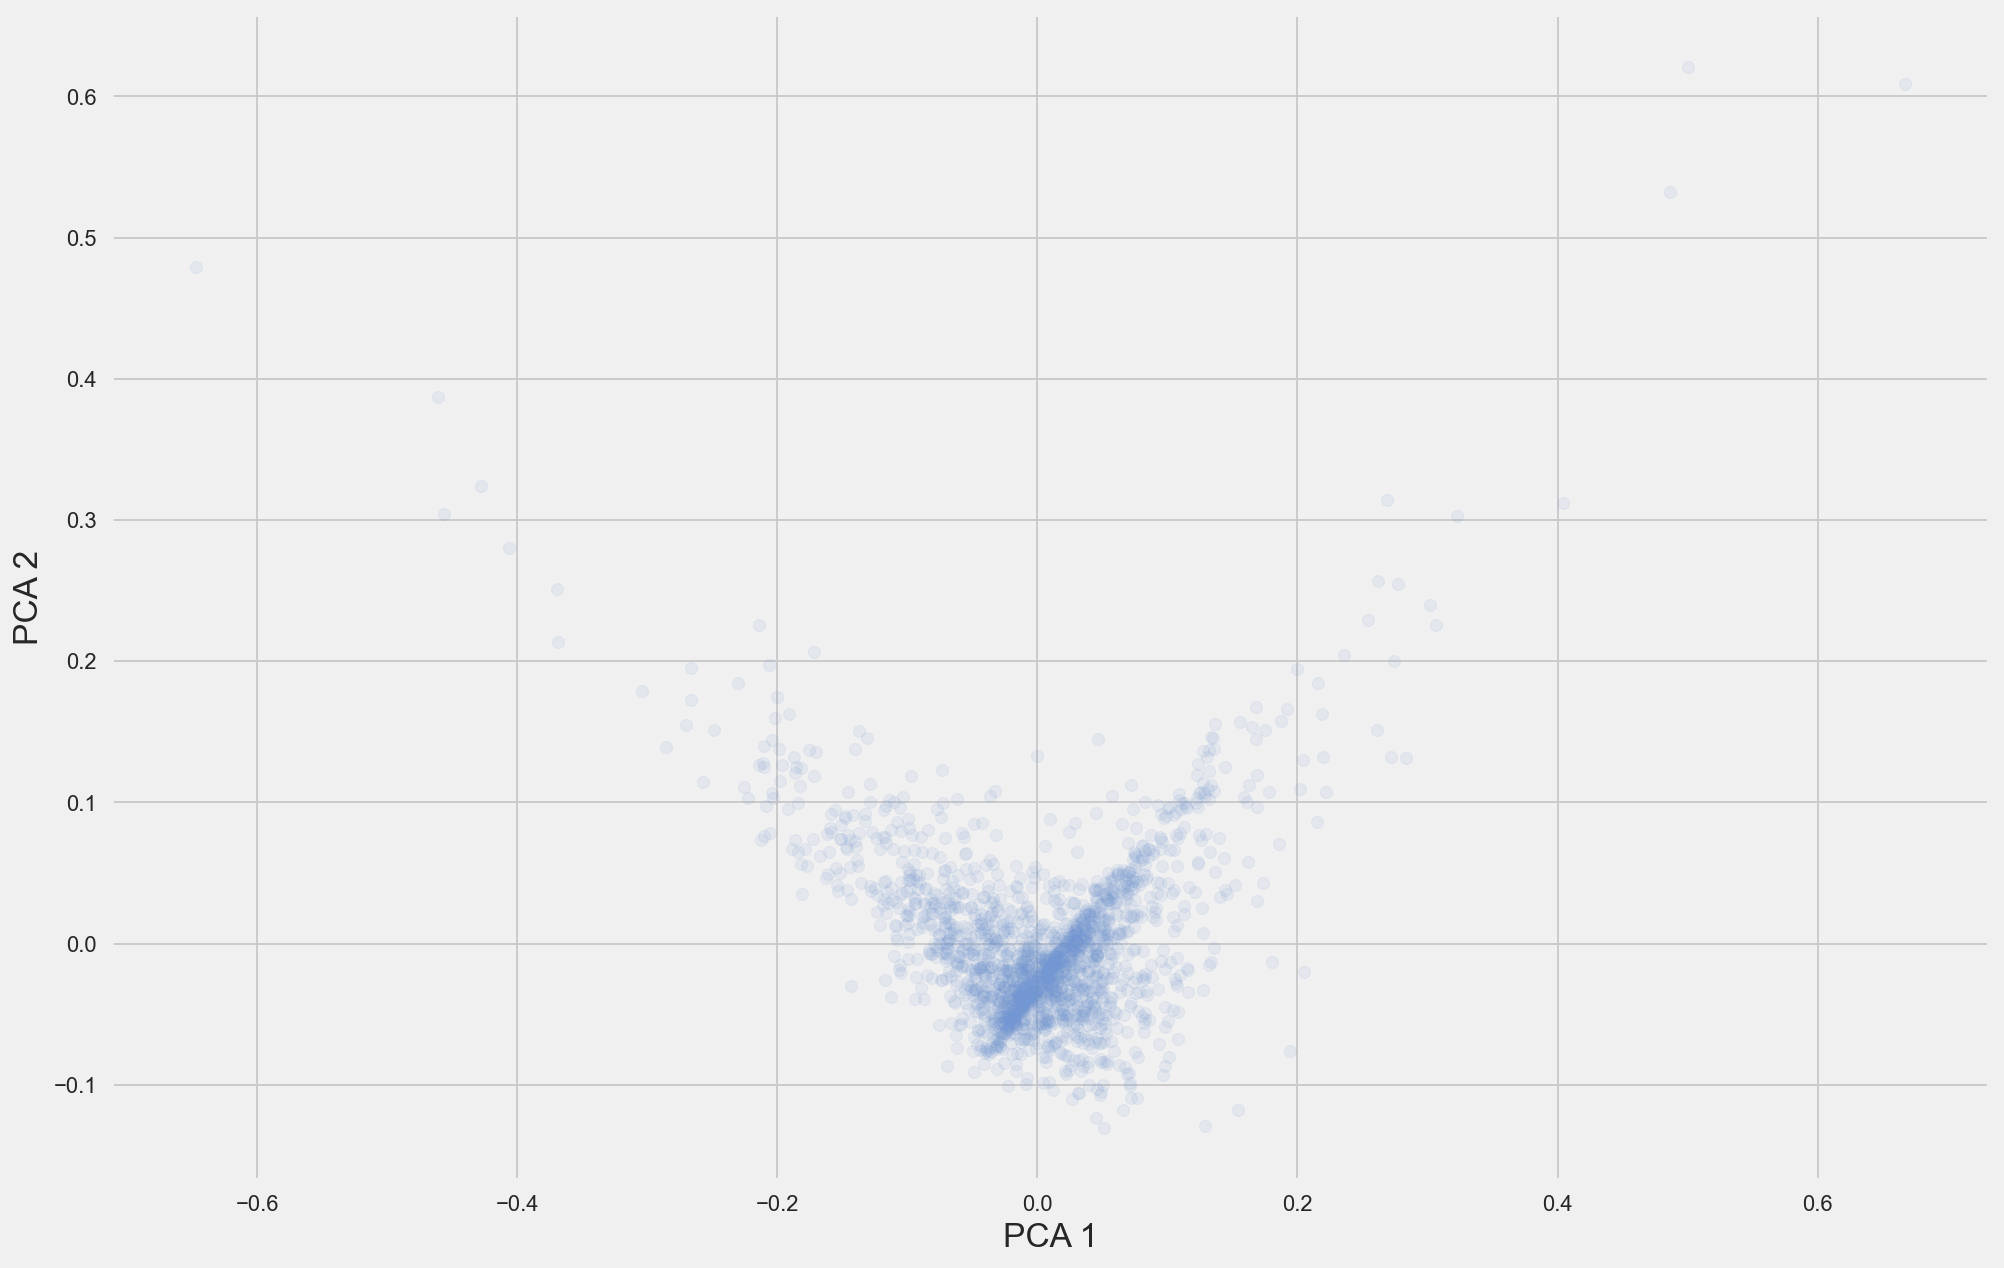

In [28]:
PCA_components = PCA_components.set_index(X.index)


plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color=('#7297d2'))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')


Text(0, 0.5, 'PCA 4')

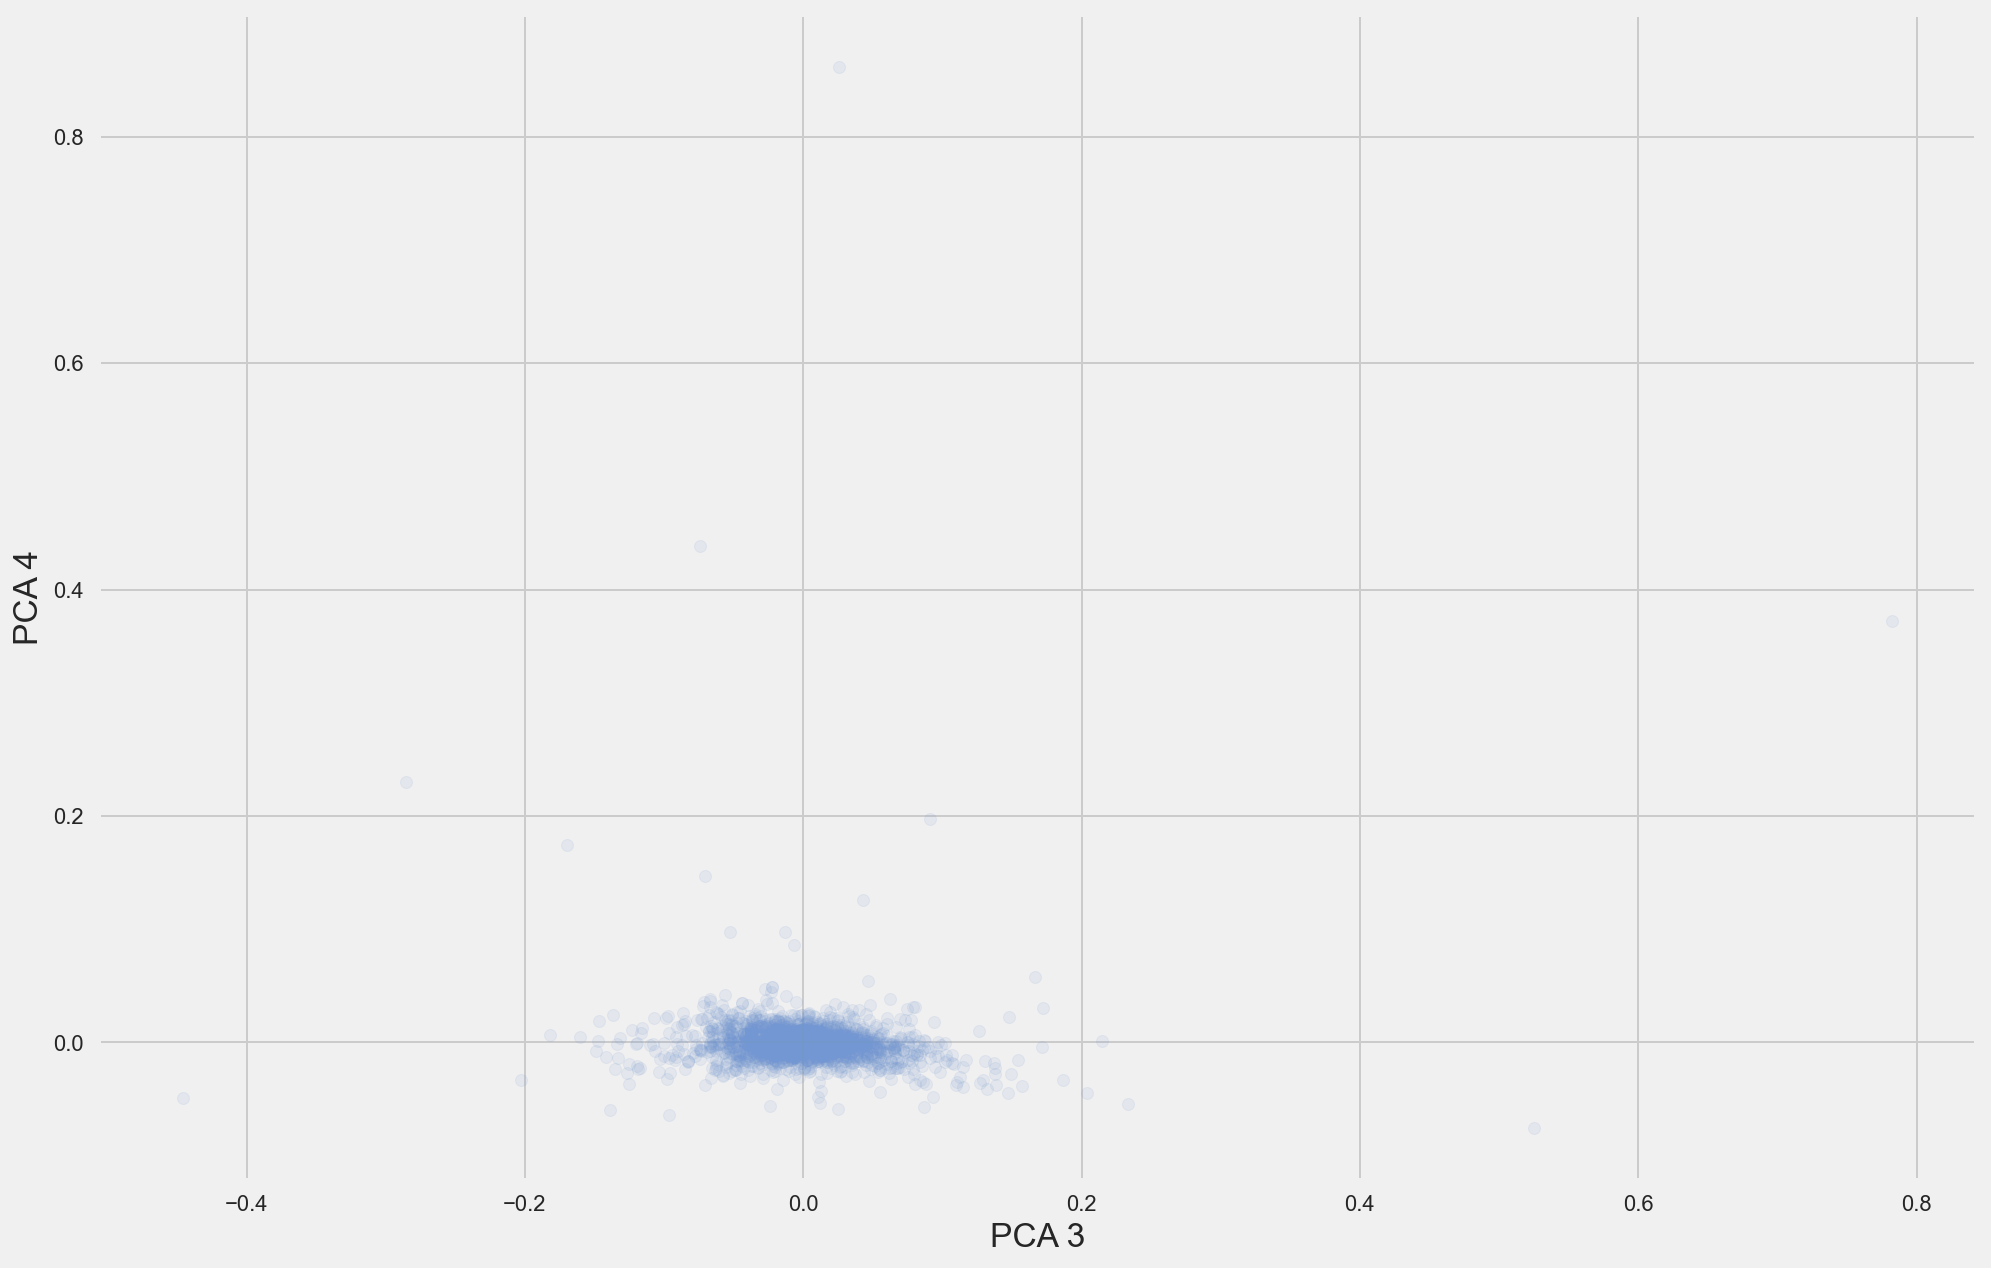

In [29]:
plt.scatter(PCA_components[2], PCA_components[3], alpha=.1, color=('#7297d2'))
plt.xlabel('PCA 3')
plt.ylabel('PCA 4')


In [30]:
eig_values = pca.explained_variance_
eig_vectors = pca.components_

pc1 = pca.components_[0]
pc2 = pca.components_[1]
pc3 = pca.components_[2]
pc4 = pca.components_[3]


In [31]:
# get the loadings
structure_loading_1 = pc1* np.sqrt(eig_values[0])
str_loading_1 = pd.Series(structure_loading_1, index=X.columns.values)
str_loading_1

HINC12_HINC00          0.013314
MHMVAL12_MHMVAL00      0.001064
MRENT12_MRENT00        0.024334
OWN10%_OWN00%          0.004206
NONWHT10%_NONWHT00%   -0.062012
COL12%_COL00%          0.041889
dtype: float64

In [32]:
# get the loadings
structure_loading_2 = pc2* np.sqrt(eig_values[1])
str_loading_2 = pd.Series(structure_loading_2, index=X.columns.values)
str_loading_2

HINC12_HINC00          0.012111
MHMVAL12_MHMVAL00     -0.000190
MRENT12_MRENT00        0.019249
OWN10%_OWN00%          0.002920
NONWHT10%_NONWHT00%    0.039311
COL12%_COL00%          0.042875
dtype: float64

In [33]:
# get the loadings
structure_loading_3 = pc1* np.sqrt(eig_values[2])
str_loading_3 = pd.Series(structure_loading_3, index=X.columns.values)
str_loading_3

HINC12_HINC00          0.008229
MHMVAL12_MHMVAL00      0.000658
MRENT12_MRENT00        0.015039
OWN10%_OWN00%          0.002599
NONWHT10%_NONWHT00%   -0.038326
COL12%_COL00%          0.025889
dtype: float64

In [34]:
# get the loadings
structure_loading_4 = pc1* np.sqrt(eig_values[3])
str_loading_4 = pd.Series(structure_loading_4, index=X.columns.values)
str_loading_4

HINC12_HINC00          0.004771
MHMVAL12_MHMVAL00      0.000381
MRENT12_MRENT00        0.008720
OWN10%_OWN00%          0.001507
NONWHT10%_NONWHT00%   -0.022223
COL12%_COL00%          0.015012
dtype: float64

([<matplotlib.axis.XTick at 0x7f81dc3e7a00>,
 [Text(0, 0, 'PCA1'),
  Text(0, 0, 'PCA2'),
  Text(0, 0, 'PCA3'),
  Text(0, 0, 'PCA4')])

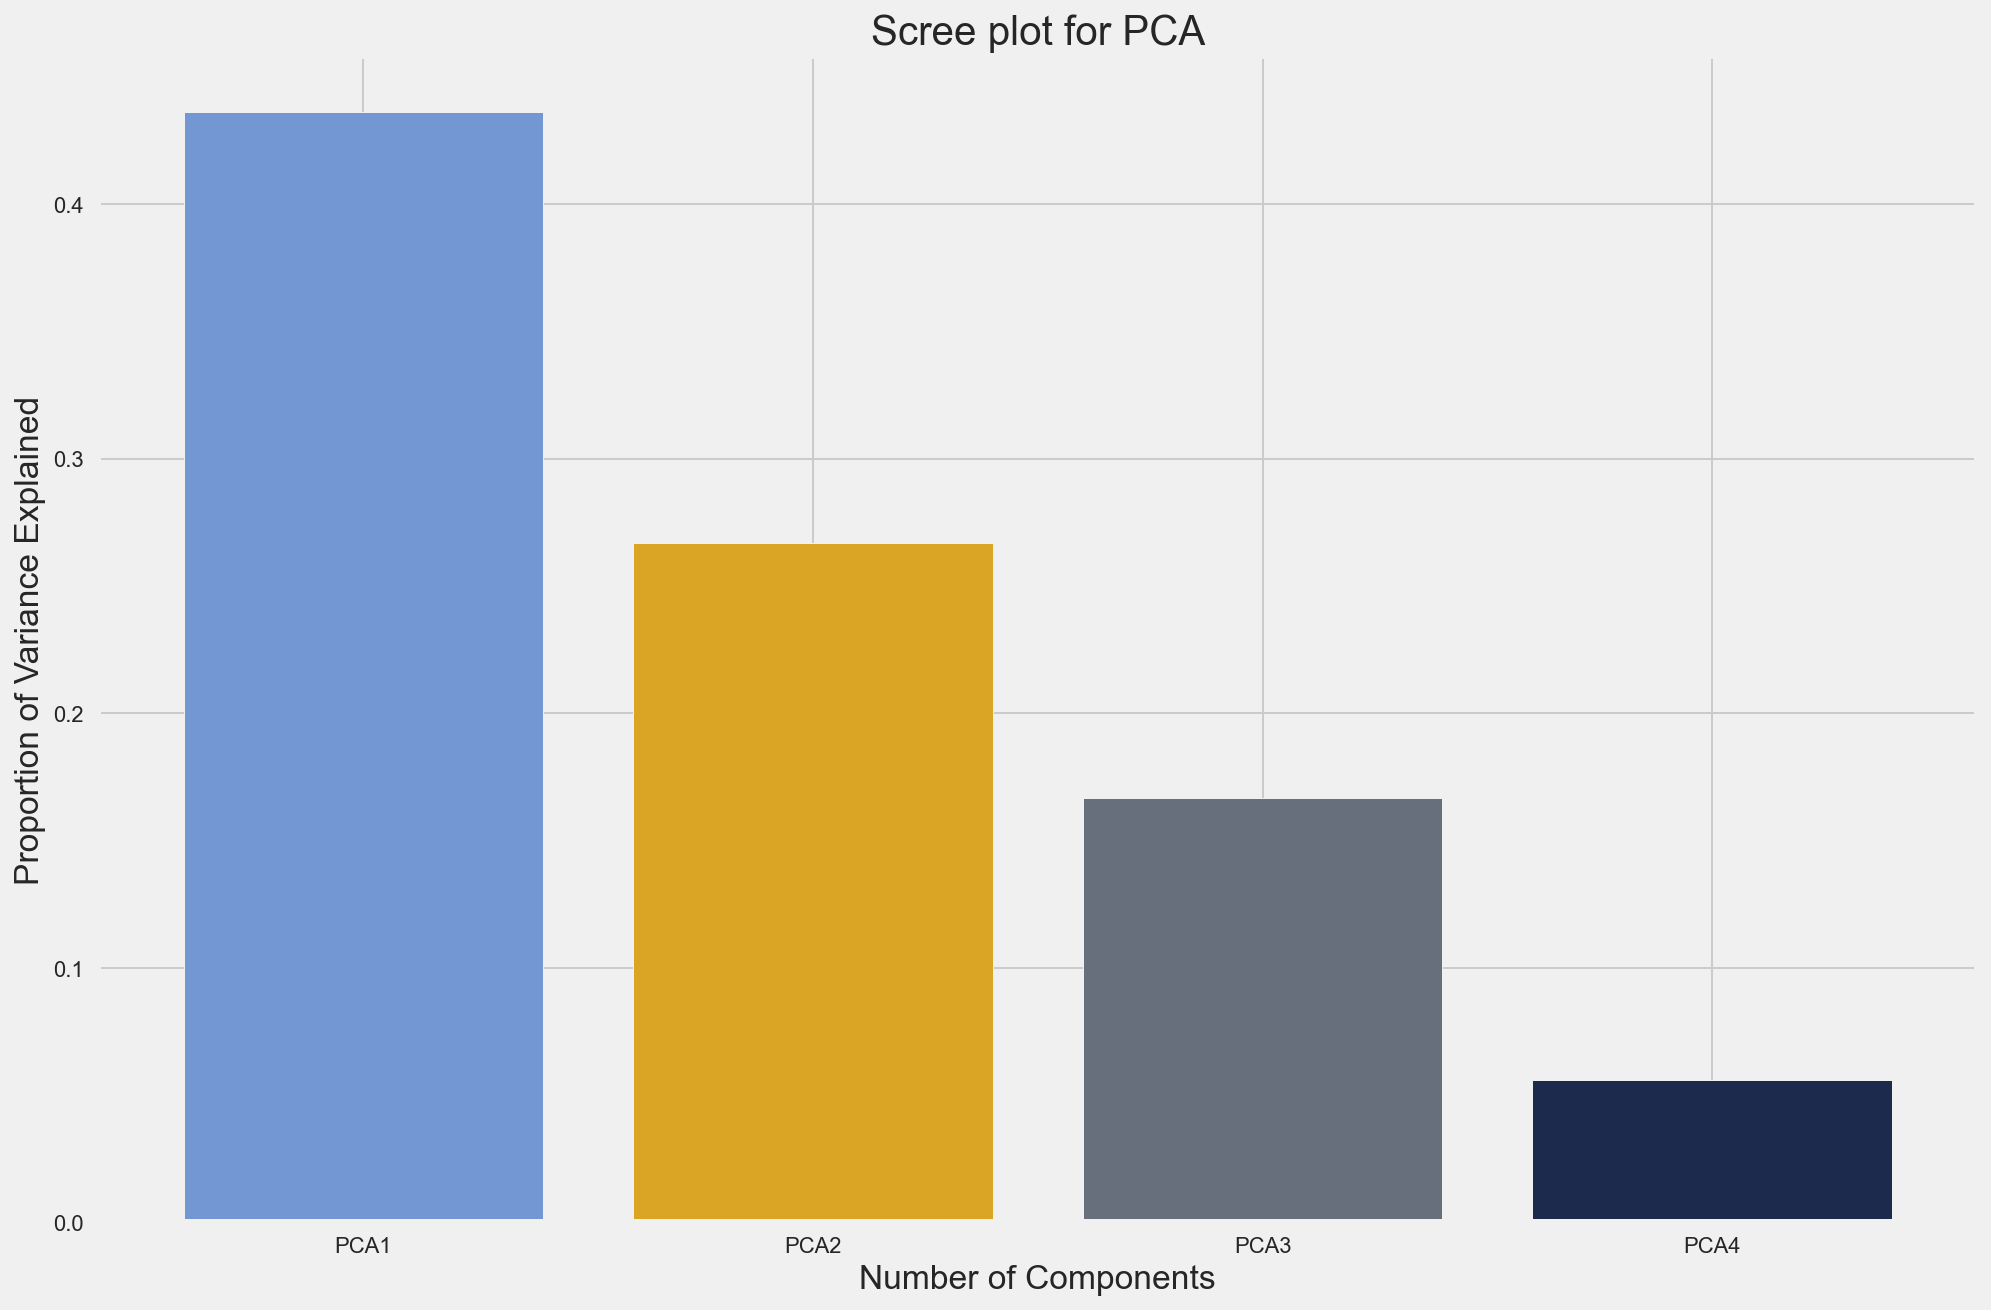

In [35]:
index = np.arange(len(PCA_components.columns.values))
plt.bar(index, pca.explained_variance_ratio_, color = ('#7297d2','#daa525', '#676e7c', '#1b2a4d'))
plt.title('Scree plot for PCA')
plt.xlabel('Number of Components')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(ticks = list(index),labels = ['PCA1','PCA2','PCA3','PCA4','PCA5'])

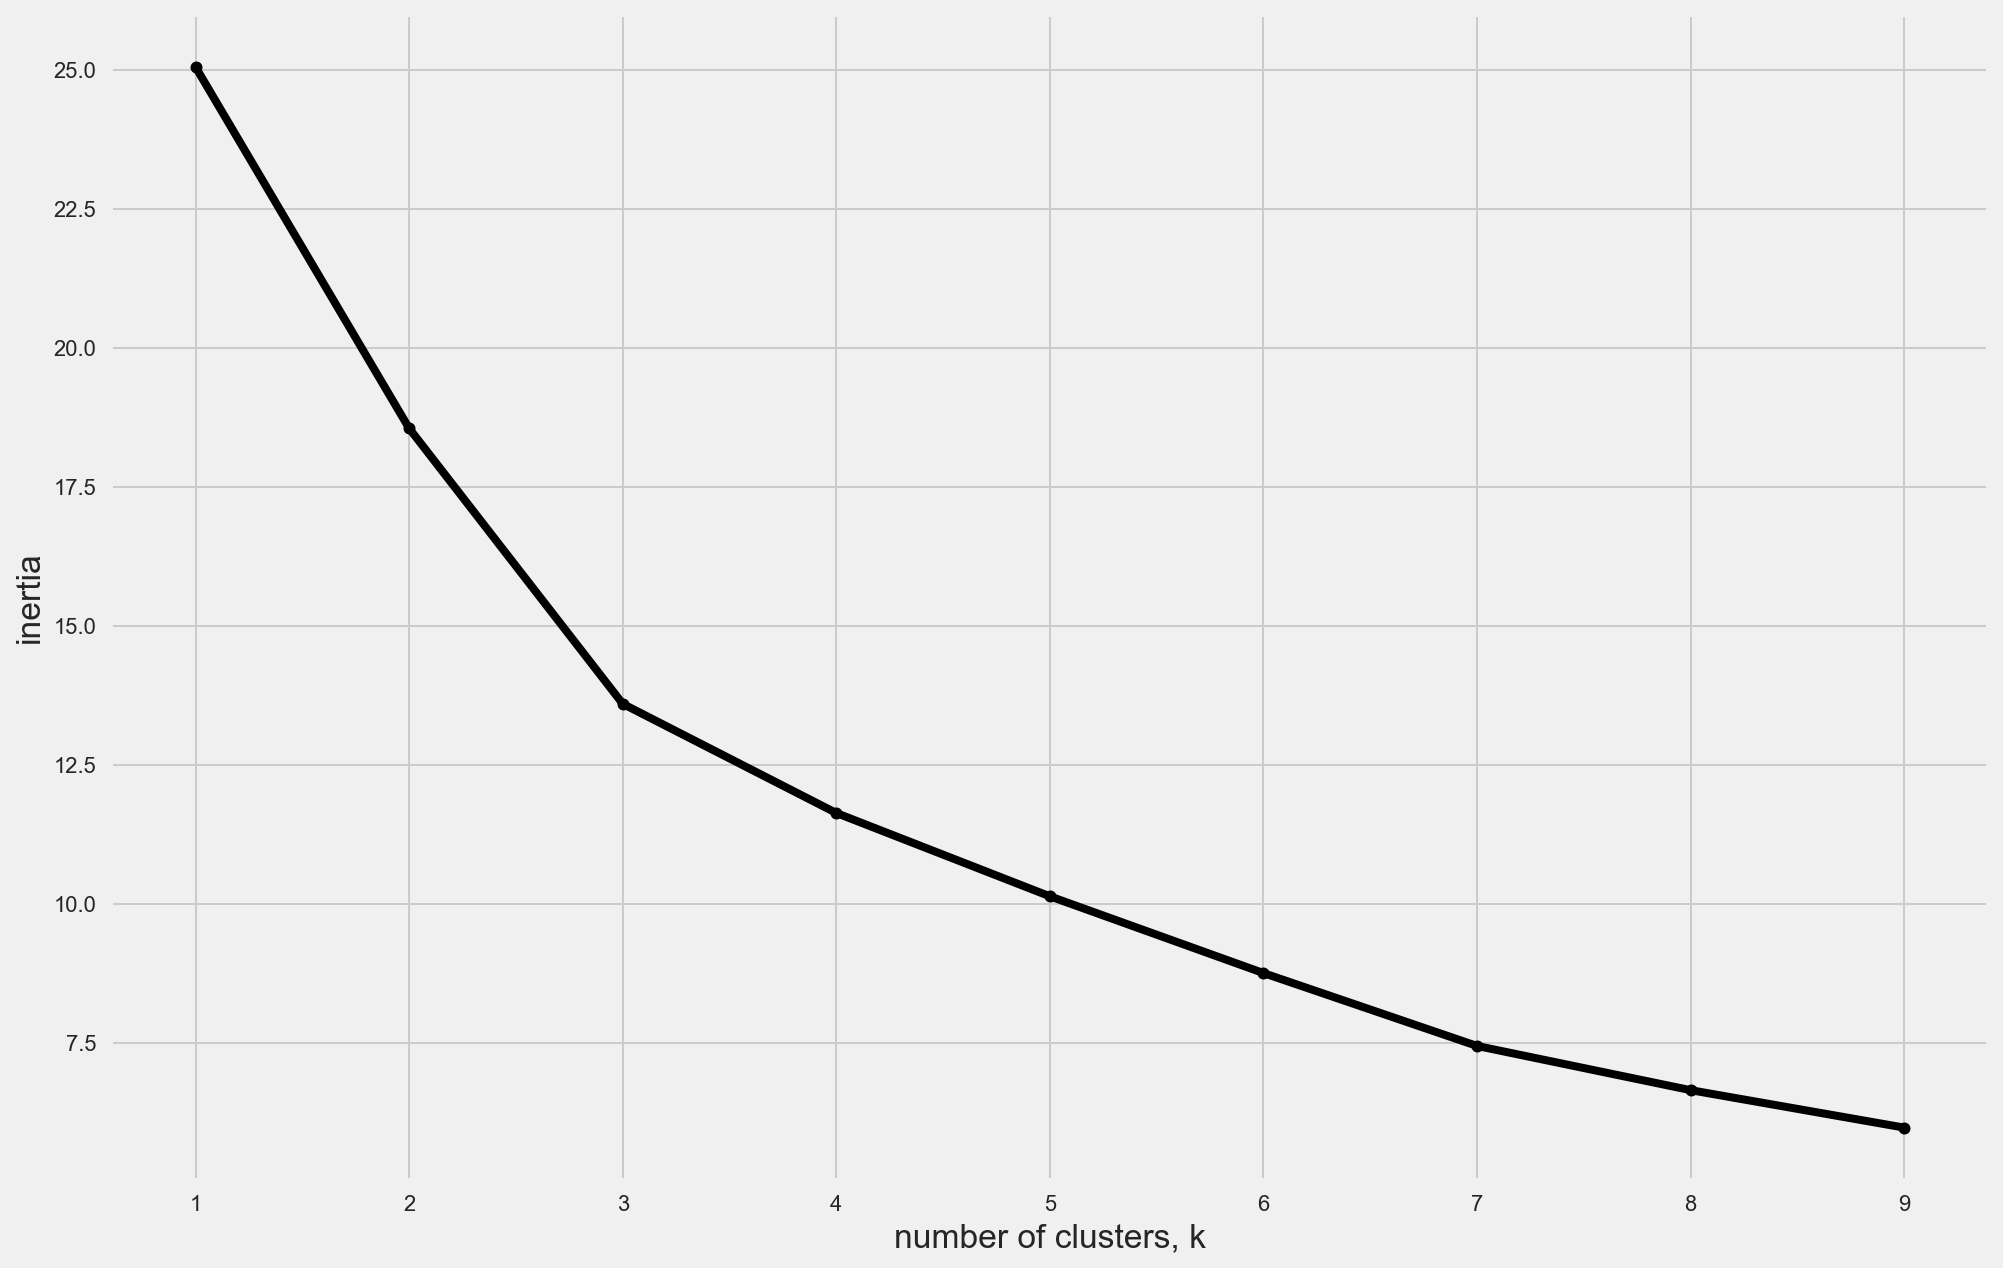

In [36]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

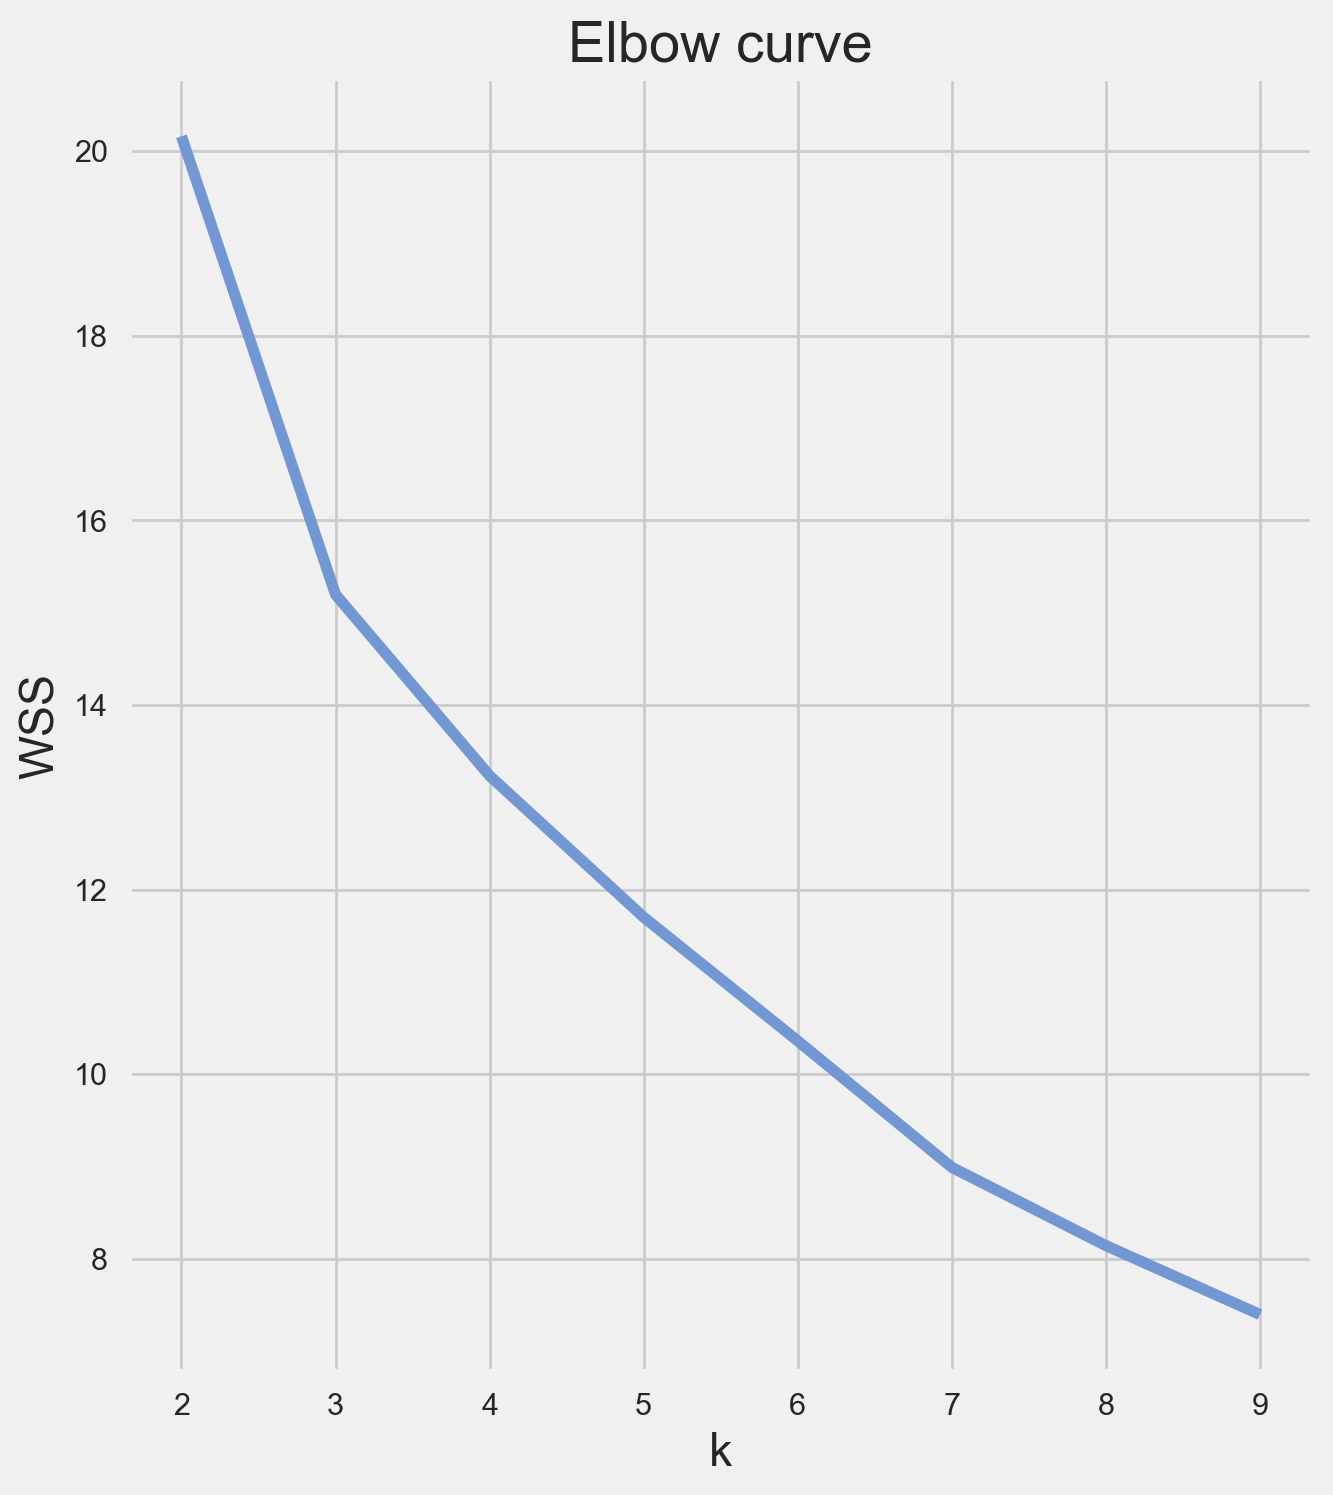

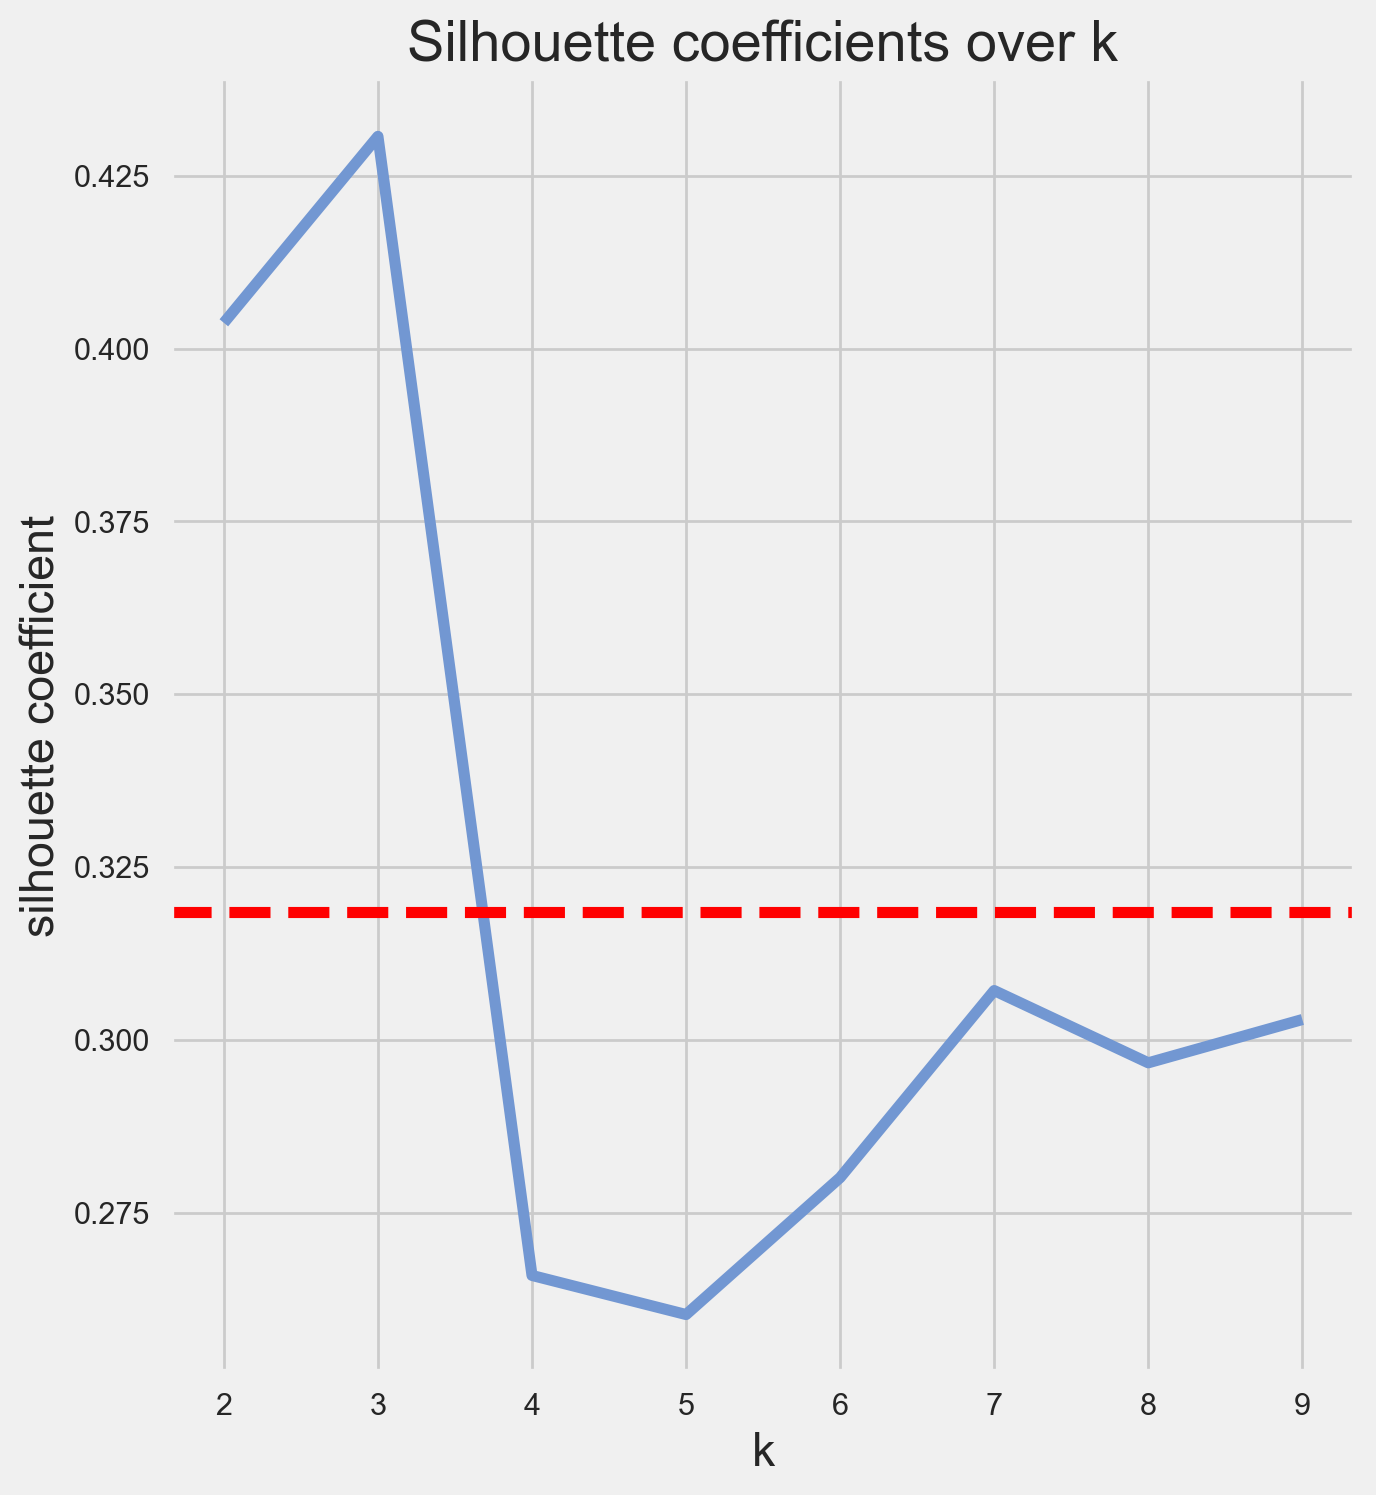

In [37]:
v = PCA_components # change this to test different 

X = v.copy()

distorsions = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state = 301)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

    # Plot values of SSE
plt.figure(figsize=(15,8),dpi=100)
plt.subplot(121, title='Elbow curve')
plt.xlabel('k')
plt.ylabel('WSS')
plt.plot(range(2, 10), distorsions)
plt.grid(True)

    # check silhouette
silhouette_plot = []
    # Calculate silhouette coefficient for different K
for k in range(2, 10):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)
    # Plot Silhouette coefficient
plt.figure(figsize=(15,8), dpi=100)
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(2, 10), silhouette_plot)
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
plt.grid(True)

# Second of **TOP 2** Results

In [38]:
# fit the model with the scaled dataframe
model = KMeans(n_clusters=3).fit(PCA_components)

# create a new dataframe showing the clusters and scaled data
cluster_pca2 = pd.DataFrame()
cluster_pca2['TRACTID']=PCA_components.index.values
cluster_pca2['cluster']=model.labels_

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_pca2['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(PCA_components.values, cluster_pca2['cluster'])}")

Distribution of clusters:
2    1473
1     263
0     231
Name: cluster, dtype: int64
Silhouette score: 0.4300036948784865


## Next, we move on to KMeans

Instead of using the PCA scores we will use the features themselves

In [45]:
# use a copy of the data frame
df1 = df.copy()

In [47]:
# scale the data to between 0 and 1
scaler=MinMaxScaler()
# fit the data
scaled_data = scaler.fit_transform(df1.values)
# put scaled data into a df
df_scaled = pd.DataFrame(scaled_data,index=df1.index,columns=df1.columns)

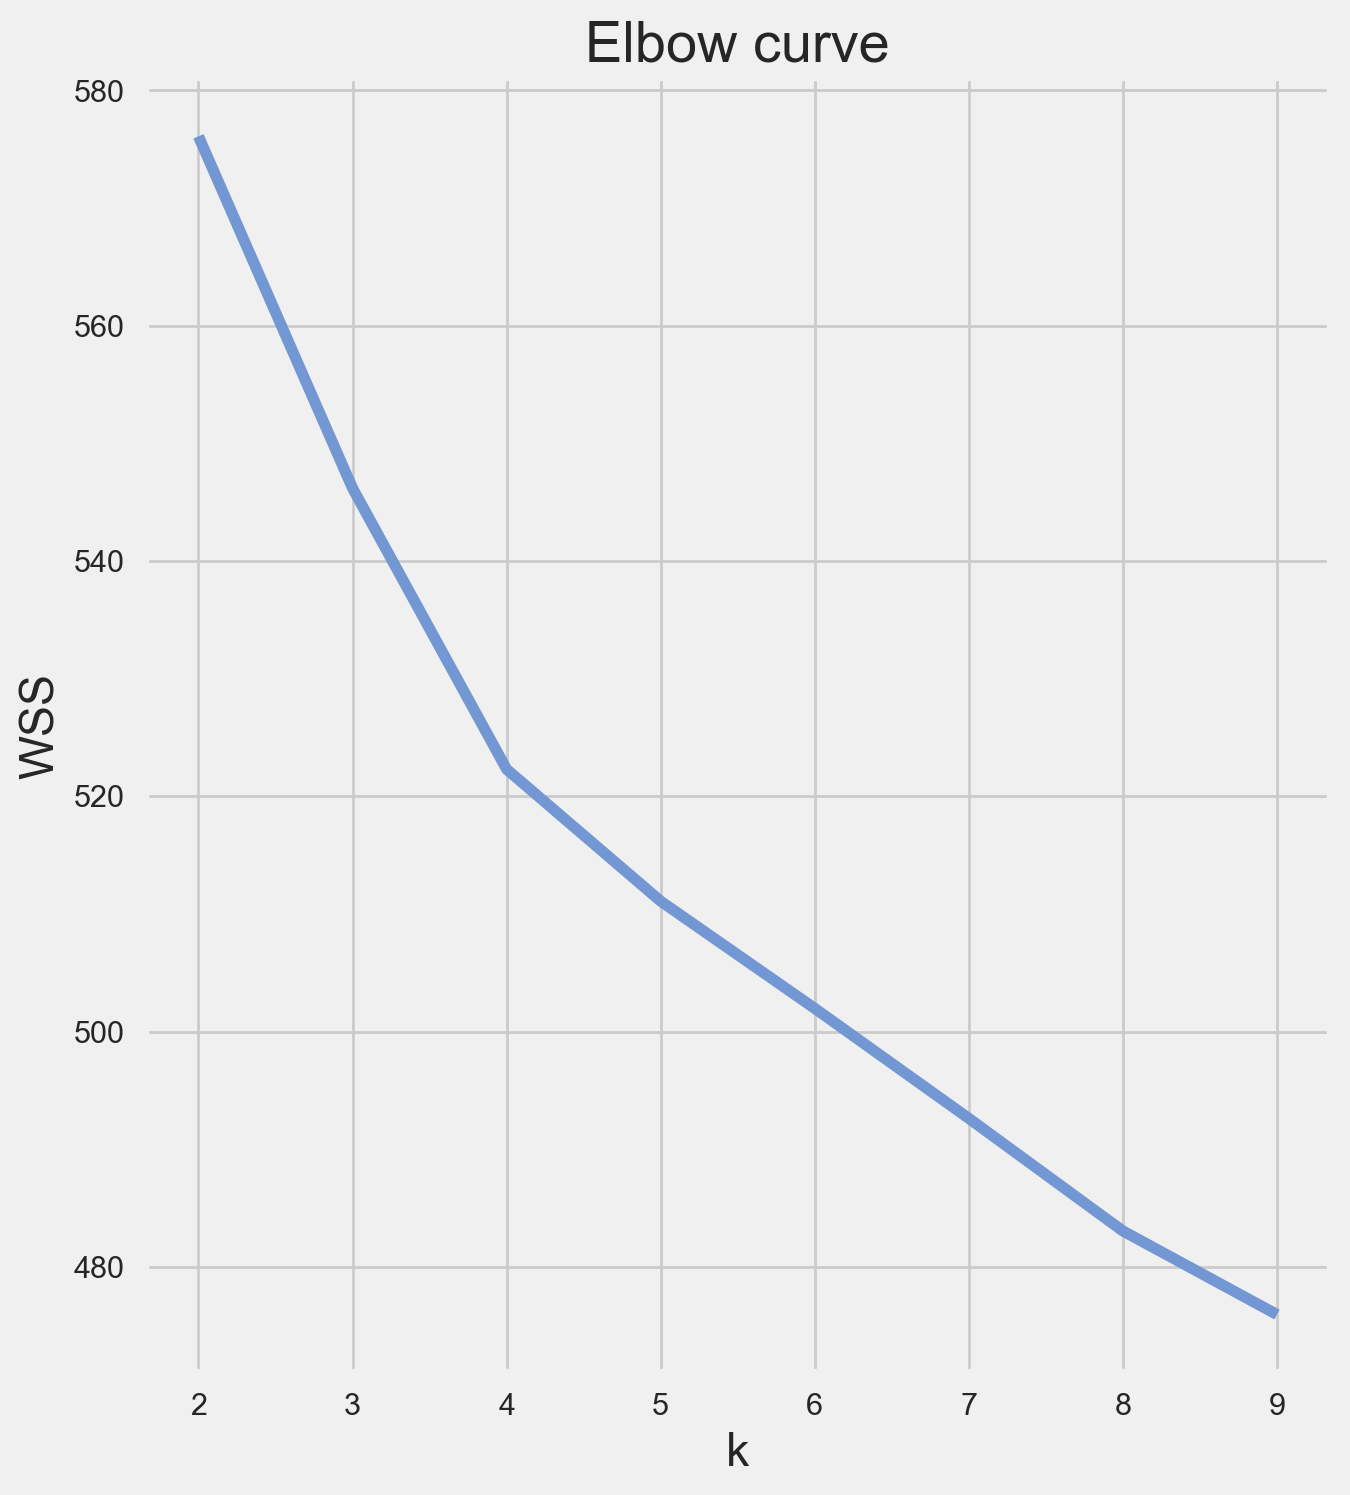

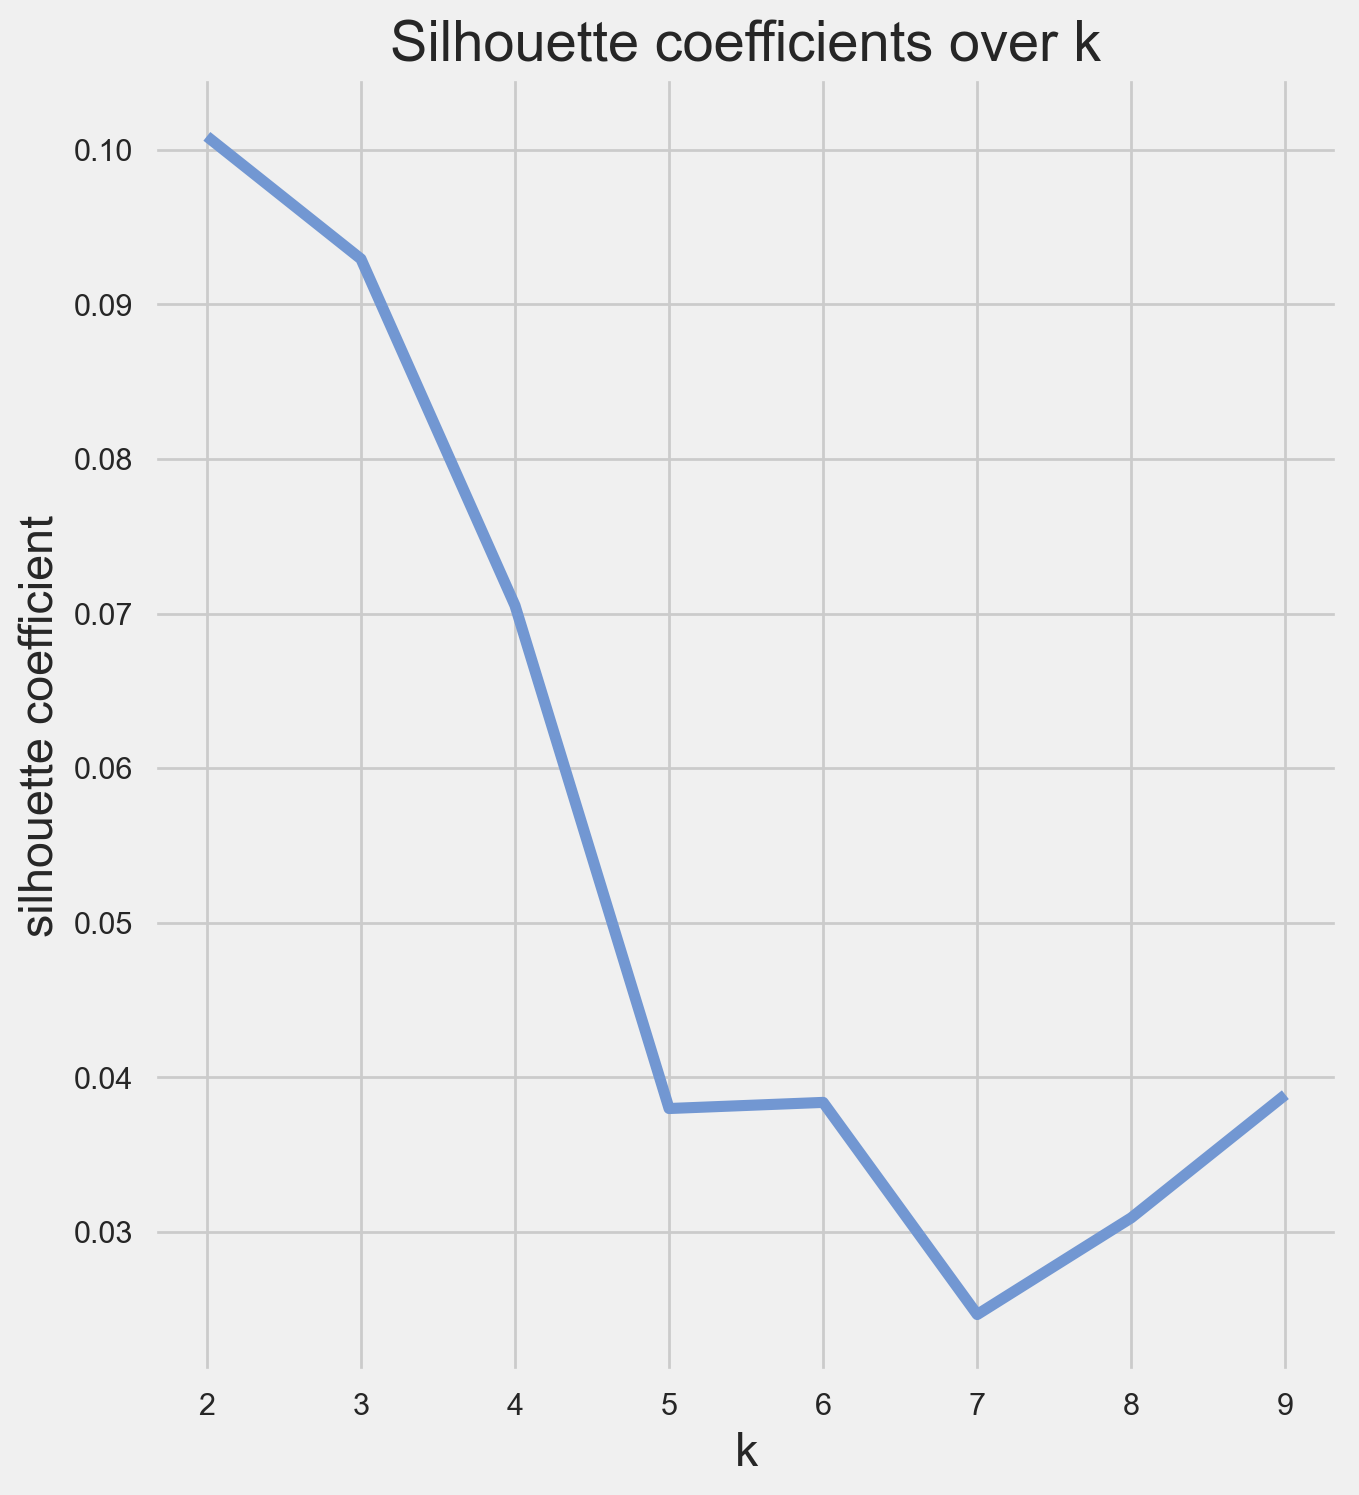

In [48]:

v = df_scaled # change this to test different subsets or full feature counts
X = v.copy()

distorsions = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state = 301)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

    # Plot values of SSE
plt.figure(figsize=(15,8),dpi=100)
plt.subplot(121, title='Elbow curve')
plt.xlabel('k')
plt.ylabel('WSS')
plt.plot(range(2, 10), distorsions)
plt.grid(True)

    # check silhouette
silhouette_plot = []
    # Calculate silhouette coefficient for different K
for k in range(2, 10):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)
    # Plot Silhouette coefficient
plt.figure(figsize=(15,8), dpi=100)
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(2, 10), silhouette_plot)
#plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
plt.grid(True)

In [49]:
# fit the model with the scaled dataframe
model1 = KMeans(n_clusters=4).fit(df_scaled)

# create a new dataframe showing the clusters and scaled data
cluster_df = pd.DataFrame()
cluster_df['tractid']=df_scaled.index.values
cluster_df['cluster']=model1.labels_
#cluster_df1 = helper.create_cluster_df(model1,df_scaled)

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_df['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(df_scaled.values, cluster_df['cluster'])}")

Distribution of clusters:
2    773
3    723
0    300
1    171
Name: cluster, dtype: int64
Silhouette score: 0.07052822004907125


In [50]:
# fit the model with the scaled dataframe
model1 = KMeans(n_clusters=5).fit(df_scaled)

# create a new dataframe showing the clusters and scaled data
cluster_df = pd.DataFrame()
cluster_df['tractid']=df_scaled.index.values
cluster_df['cluster']=model1.labels_
#cluster_df1 = helper.create_cluster_df(model1,df_scaled)

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_df['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(df_scaled.values, cluster_df['cluster'])}")

Distribution of clusters:
3    726
0    449
4    372
2    280
1    140
Name: cluster, dtype: int64
Silhouette score: 0.03783667795868243


## The incredible amount of dimensions used produces a very low silhouette score

# Using the widely accepted variables associated with gentrification

## Use the first subset of features

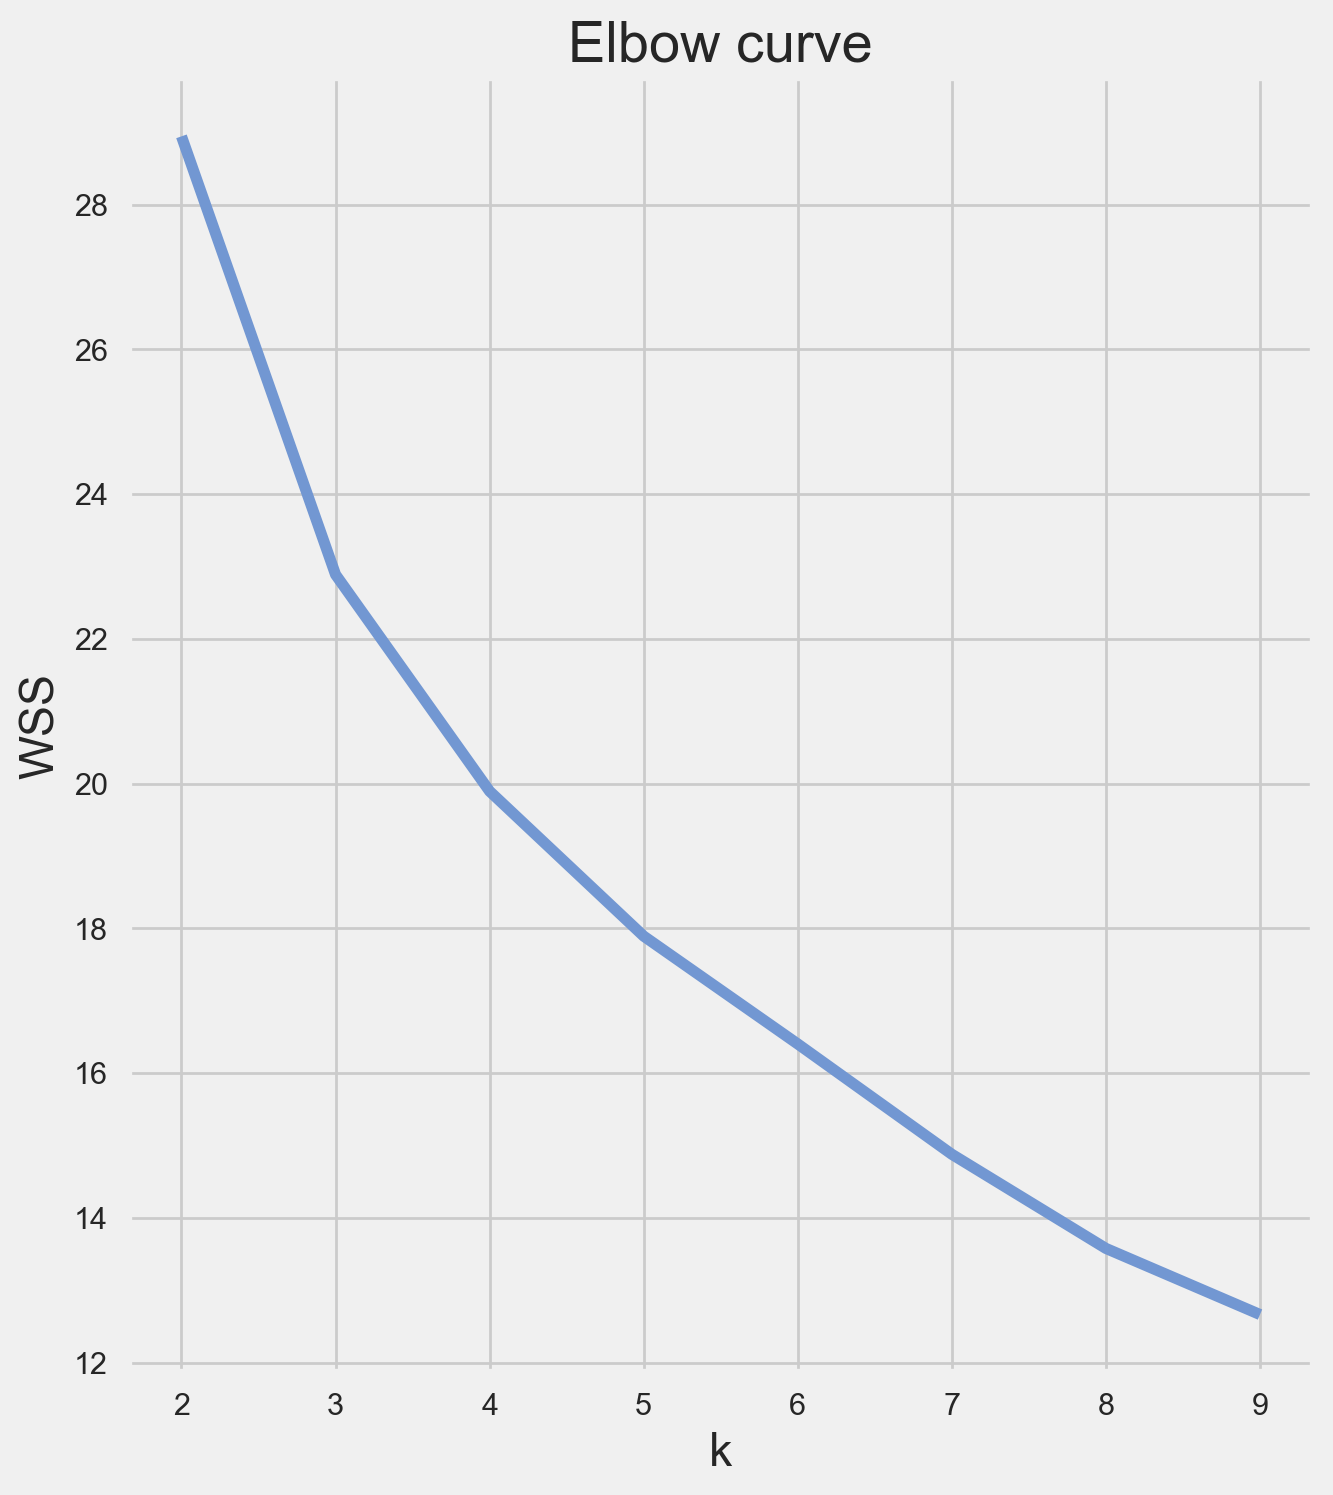

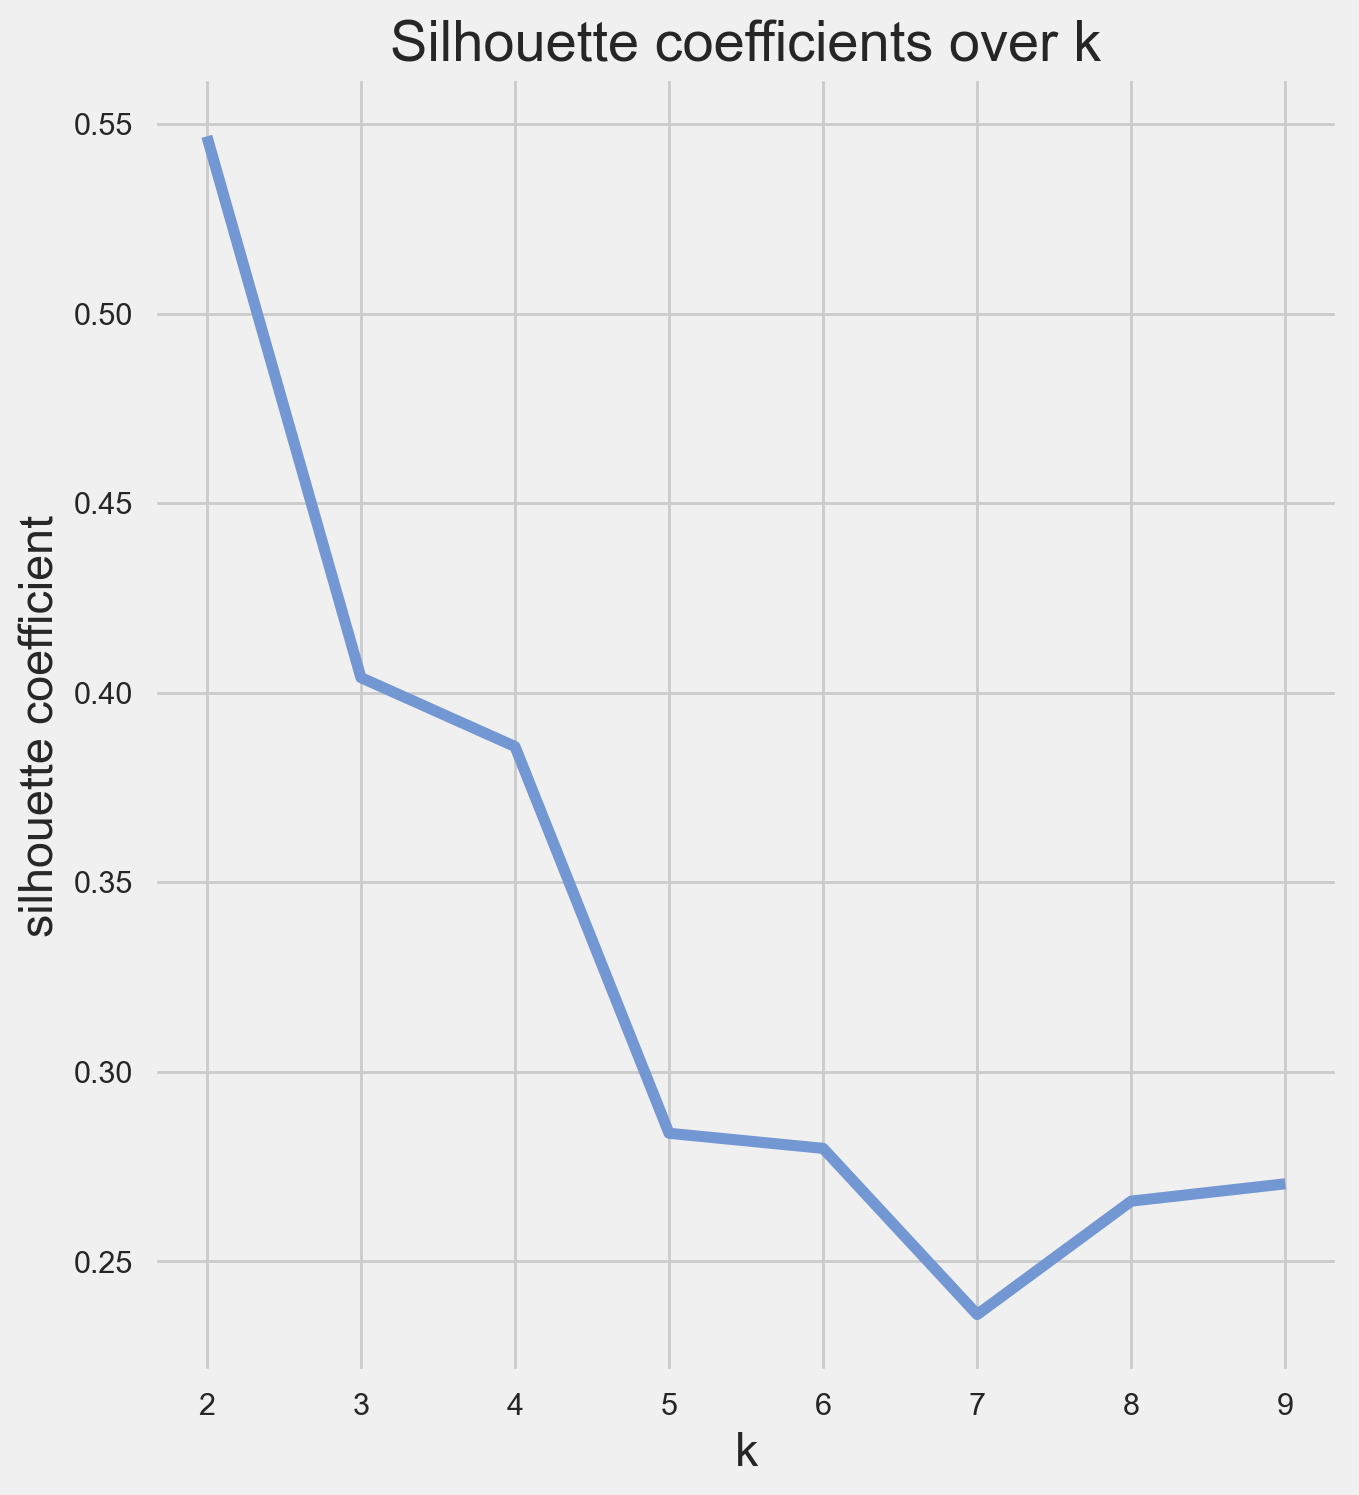

In [51]:
# let this variable be the different dfs I create to test the different variables

v = df_scaled_gent1 # change this to test different 



X = v.copy()


distorsions = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state = 301)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

    # Plot values of SSE
plt.figure(figsize=(15,8),dpi=100)
plt.subplot(121, title='Elbow curve')
plt.xlabel('k')
plt.ylabel('WSS')
plt.plot(range(2, 10), distorsions)
plt.grid(True)

    # check silhouette
silhouette_plot = []
    # Calculate silhouette coefficient for different K
for k in range(2, 10):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)
    # Plot Silhouette coefficient
plt.savefig('Images/elbow_curve_subset.png', dpi=300, 
            bbox_inches= 'tight', padding_inches = 4, transparent = True )
plt.figure(figsize=(15,8), dpi=100)
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(2, 10), silhouette_plot)
#plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
plt.grid(True)
plt.savefig('Images/silo_subset.png', dpi=300, 
            bbox_inches= 'tight', padding_inches = 4, transparent = True )

In [52]:
# fit the model with the scaled dataframe
model1 = KMeans(n_clusters=3).fit(X)

# create a new dataframe showing the clusters and scaled data
cluster_df = pd.DataFrame()
cluster_df['tractid']=X.index.values
cluster_df['cluster']=model1.labels_
#cluster_df1 = helper.create_cluster_df(model1,df_scaled)

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_df['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(X.values, cluster_df['cluster'])}")

Distribution of clusters:
0    1577
1     276
2     114
Name: cluster, dtype: int64
Silhouette score: 0.4042059128754652


In [53]:
# fit the model with the scaled dataframe
model1 = KMeans(n_clusters=4).fit(X)

# create a new dataframe showing the clusters and scaled data
cluster_df = pd.DataFrame()
cluster_df['tractid']=X.index.values
cluster_df['cluster']=model1.labels_
#cluster_df1 = helper.create_cluster_df(model1,df_scaled)

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_df['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(X.values, cluster_df['cluster'])}")

Distribution of clusters:
3    1420
0     258
1     251
2      38
Name: cluster, dtype: int64
Silhouette score: 0.3849747997691166


## Second set of features

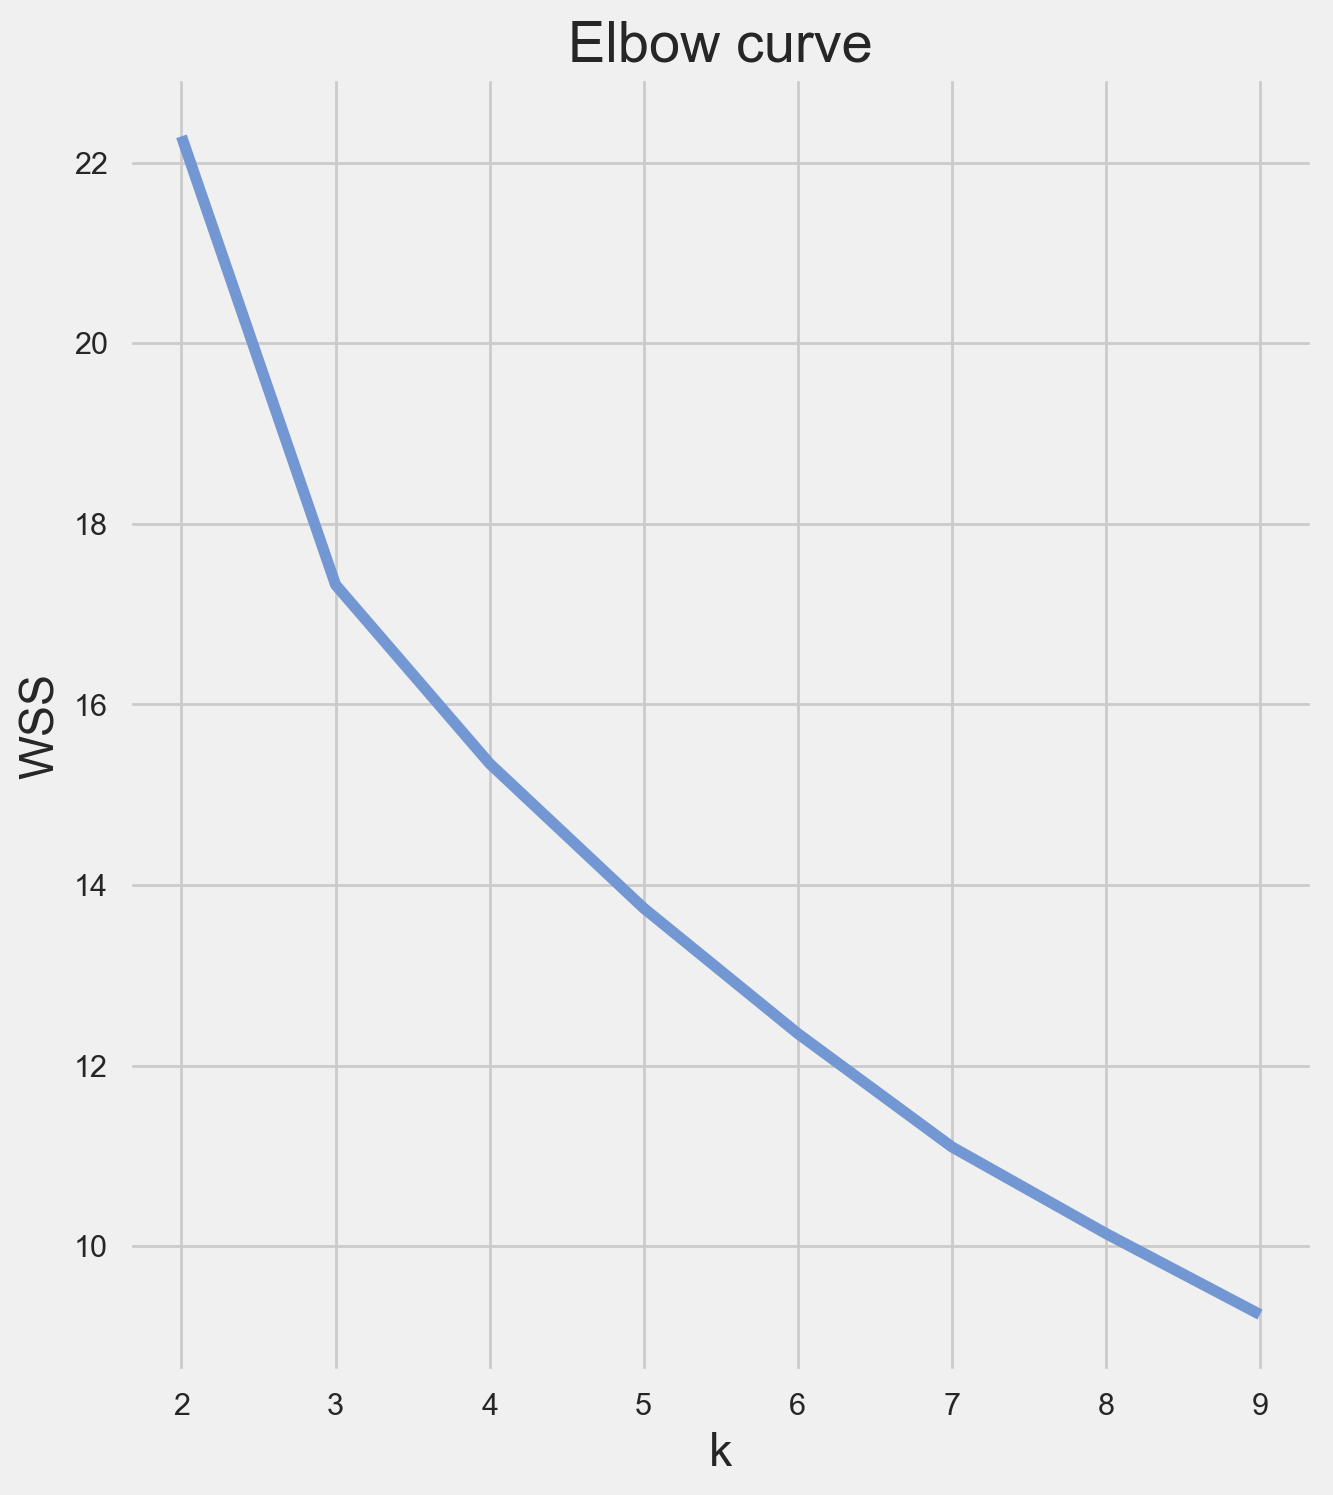

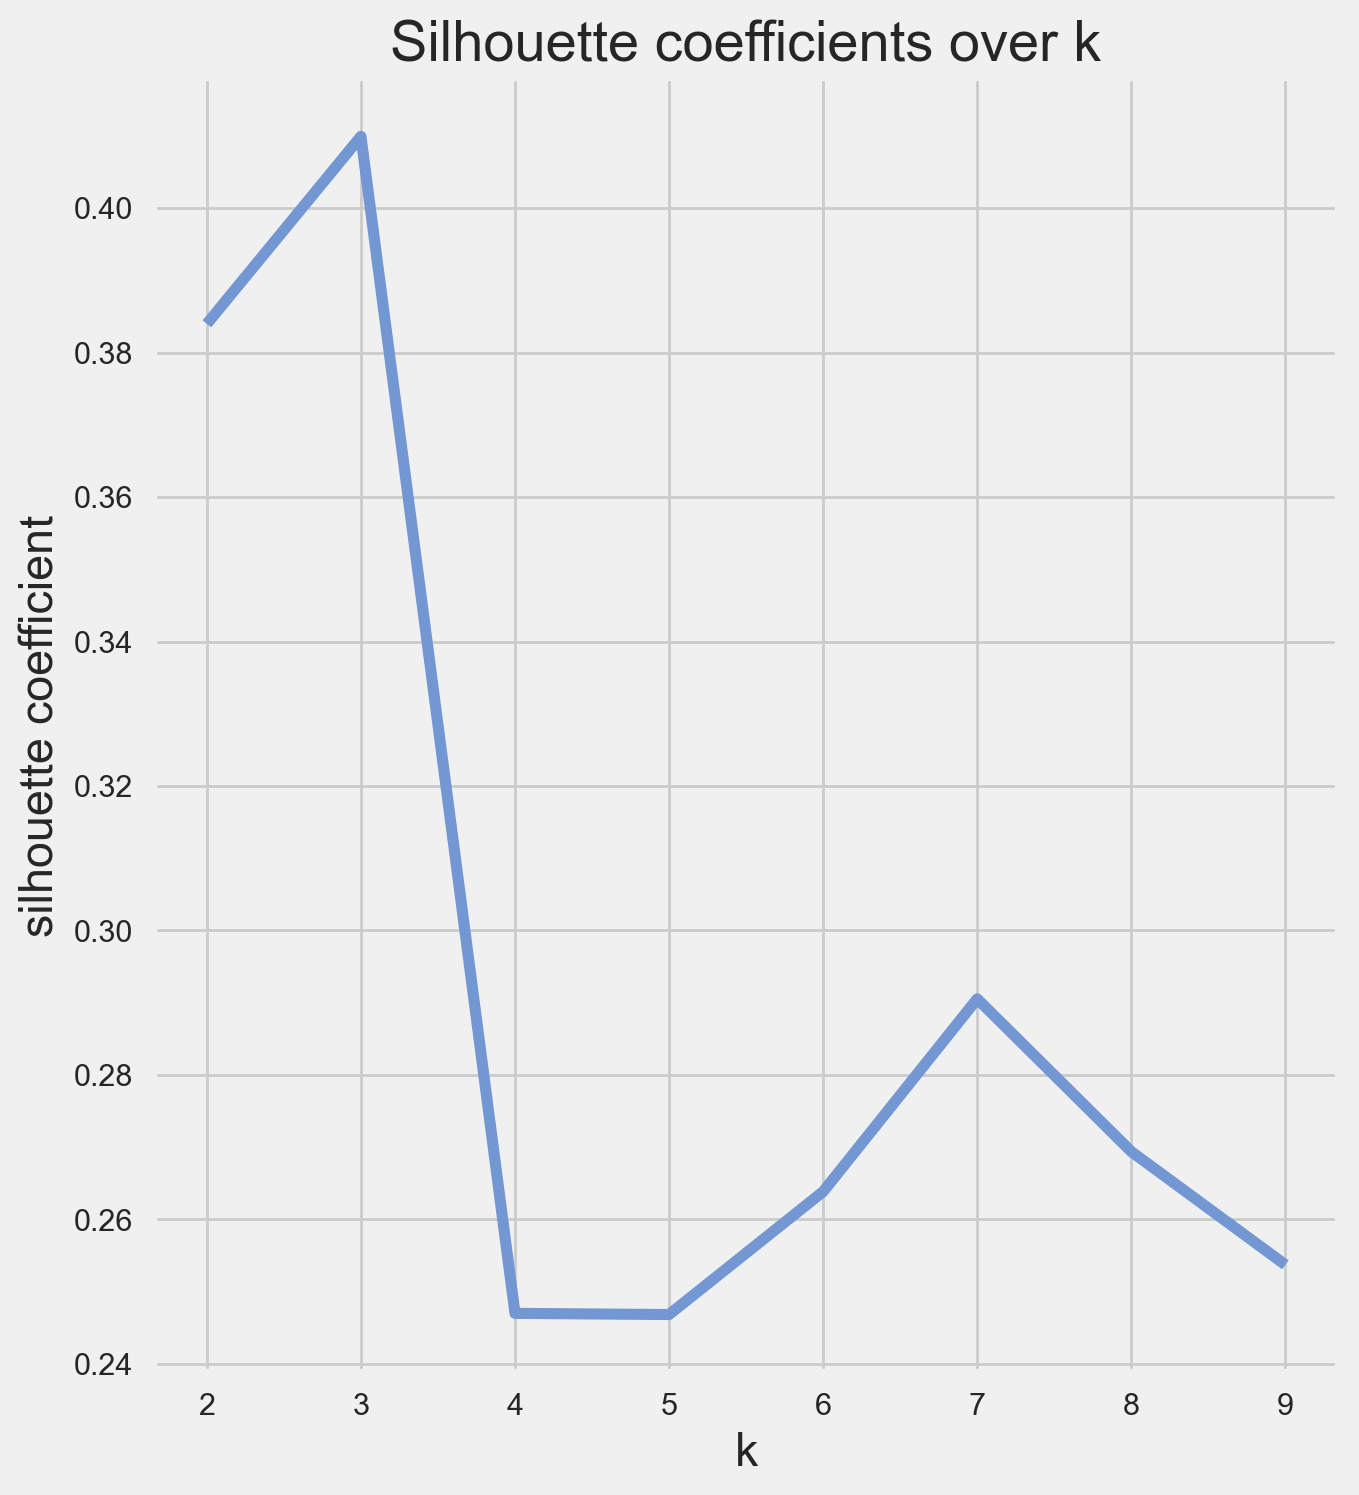

In [54]:
# let this variable be the different dfs I create to test the different variables

v = df_scaled_gent2 # change this to test different 



X = v.copy()


distorsions = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state = 301)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

    # Plot values of SSE
plt.figure(figsize=(15,8),dpi=100)
plt.subplot(121, title='Elbow curve')
plt.xlabel('k')
plt.ylabel('WSS')
plt.plot(range(2, 10), distorsions)
plt.grid(True)

    # check silhouette
silhouette_plot = []
    # Calculate silhouette coefficient for different K
for k in range(2, 10):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)
    # Plot Silhouette coefficient
plt.figure(figsize=(15,8), dpi=100)
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(2, 10), silhouette_plot)
#plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
plt.grid(True)

In [55]:
# fit the model with the scaled dataframe
model1 = KMeans(n_clusters=3).fit(X)

# create a new dataframe showing the clusters and scaled data
cluster_df = pd.DataFrame()
cluster_df['tractid']=X.index.values
cluster_df['cluster']=model1.labels_
#cluster_df1 = helper.create_cluster_df(model1,df_scaled)

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_df['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(X.values, cluster_df['cluster'])}")

Distribution of clusters:
2    1477
1     264
0     226
Name: cluster, dtype: int64
Silhouette score: 0.40960614176096755


In [56]:
# fit the model with the scaled dataframe
model1 = KMeans(n_clusters=4).fit(X)

# create a new dataframe showing the clusters and scaled data
cluster_df = pd.DataFrame()
cluster_df['tractid']=X.index.values
cluster_df['cluster']=model1.labels_
#cluster_df1 = helper.create_cluster_df(model1,df_scaled)

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_df['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(X.values, cluster_df['cluster'])}")

Distribution of clusters:
2    1009
1     649
3     198
0     111
Name: cluster, dtype: int64
Silhouette score: 0.24631888092818133


## Third set of features

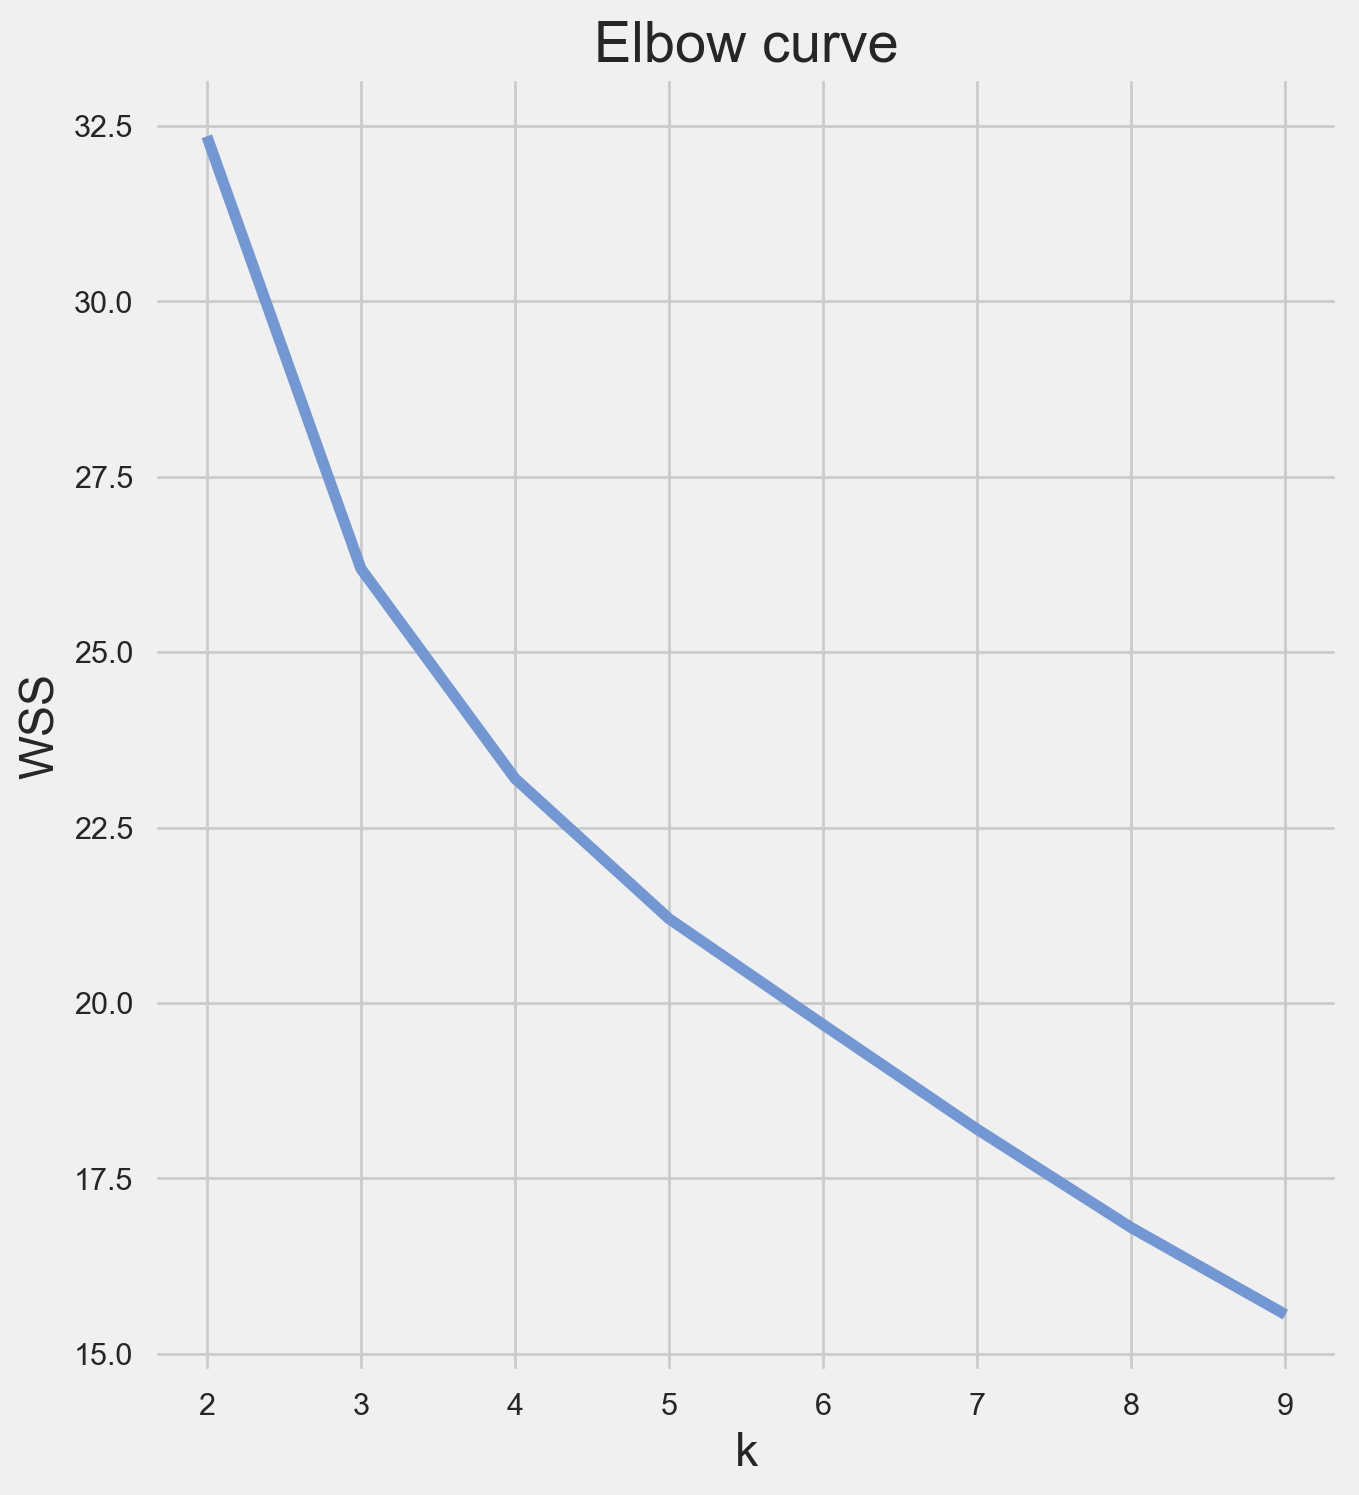

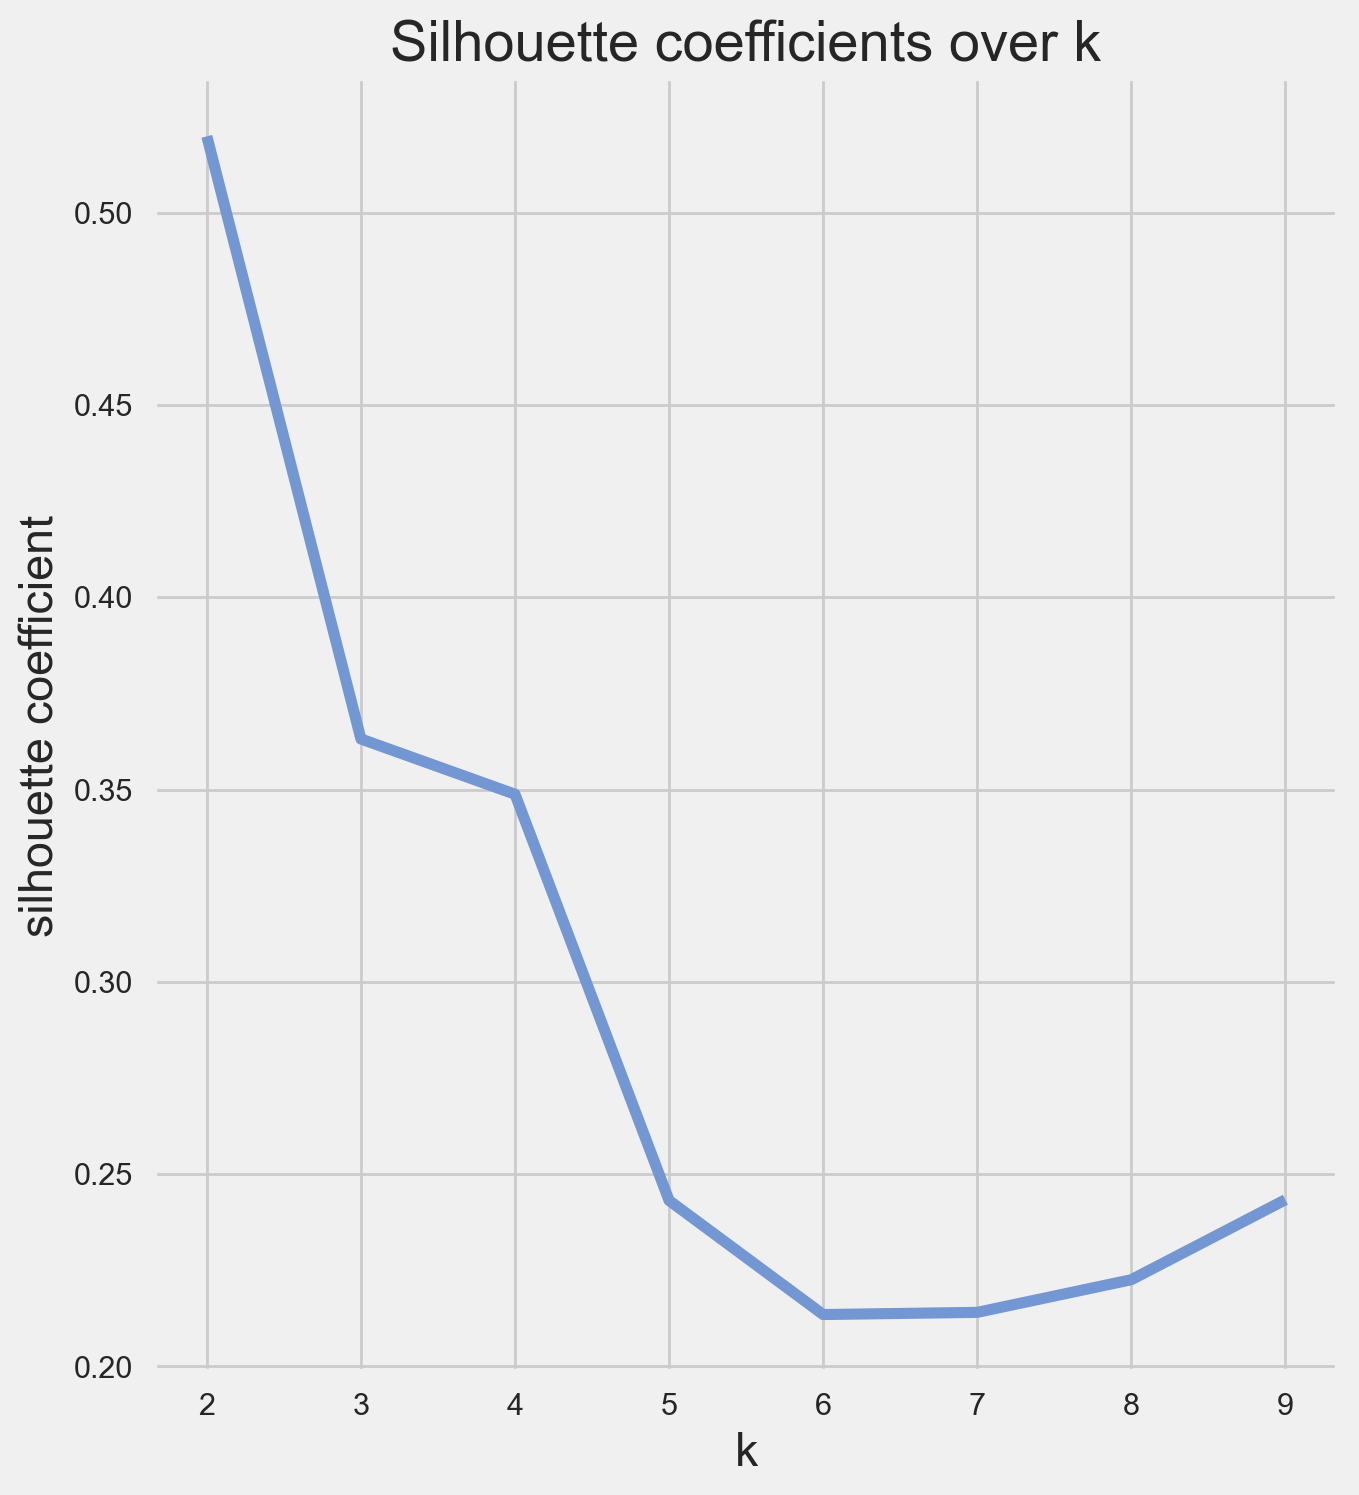

In [57]:
# let this variable be the different dfs I create to test the different variables

v = df_scaled_gent3 # change this to test different 



X = v.copy()


distorsions = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state = 301)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

    # Plot values of SSE
plt.figure(figsize=(15,8),dpi=100)
plt.subplot(121, title='Elbow curve')
plt.xlabel('k')
plt.ylabel('WSS')
plt.plot(range(2, 10), distorsions)
plt.grid(True)

    # check silhouette
silhouette_plot = []
    # Calculate silhouette coefficient for different K
for k in range(2, 10):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)
    # Plot Silhouette coefficient
plt.figure(figsize=(15,8), dpi=100)
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(2, 10), silhouette_plot)
#plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
plt.grid(True)

In [58]:
# fit the model with the scaled dataframe
model1 = KMeans(n_clusters=3).fit(X)

# create a new dataframe showing the clusters and scaled data
cluster_df = pd.DataFrame()
cluster_df['tractid']=X.index.values
cluster_df['cluster']=model1.labels_
#cluster_df1 = helper.create_cluster_df(model1,df_scaled)

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_df['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(X.values, cluster_df['cluster'])}")

Distribution of clusters:
2    1559
1     294
0     114
Name: cluster, dtype: int64
Silhouette score: 0.36315035331485607


In [59]:
# fit the model with the scaled dataframe
model1 = KMeans(n_clusters=5).fit(X)

# create a new dataframe showing the clusters and scaled data
cluster_df = pd.DataFrame()
cluster_df['tractid']=X.index.values
cluster_df['cluster']=model1.labels_
#cluster_df1 = helper.create_cluster_df(model1,df_scaled)

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_df['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(X.values, cluster_df['cluster'])}")

Distribution of clusters:
1    1123
2     517
3     234
0      66
4      27
Name: cluster, dtype: int64
Silhouette score: 0.23999834643738469


## Fourth set of features

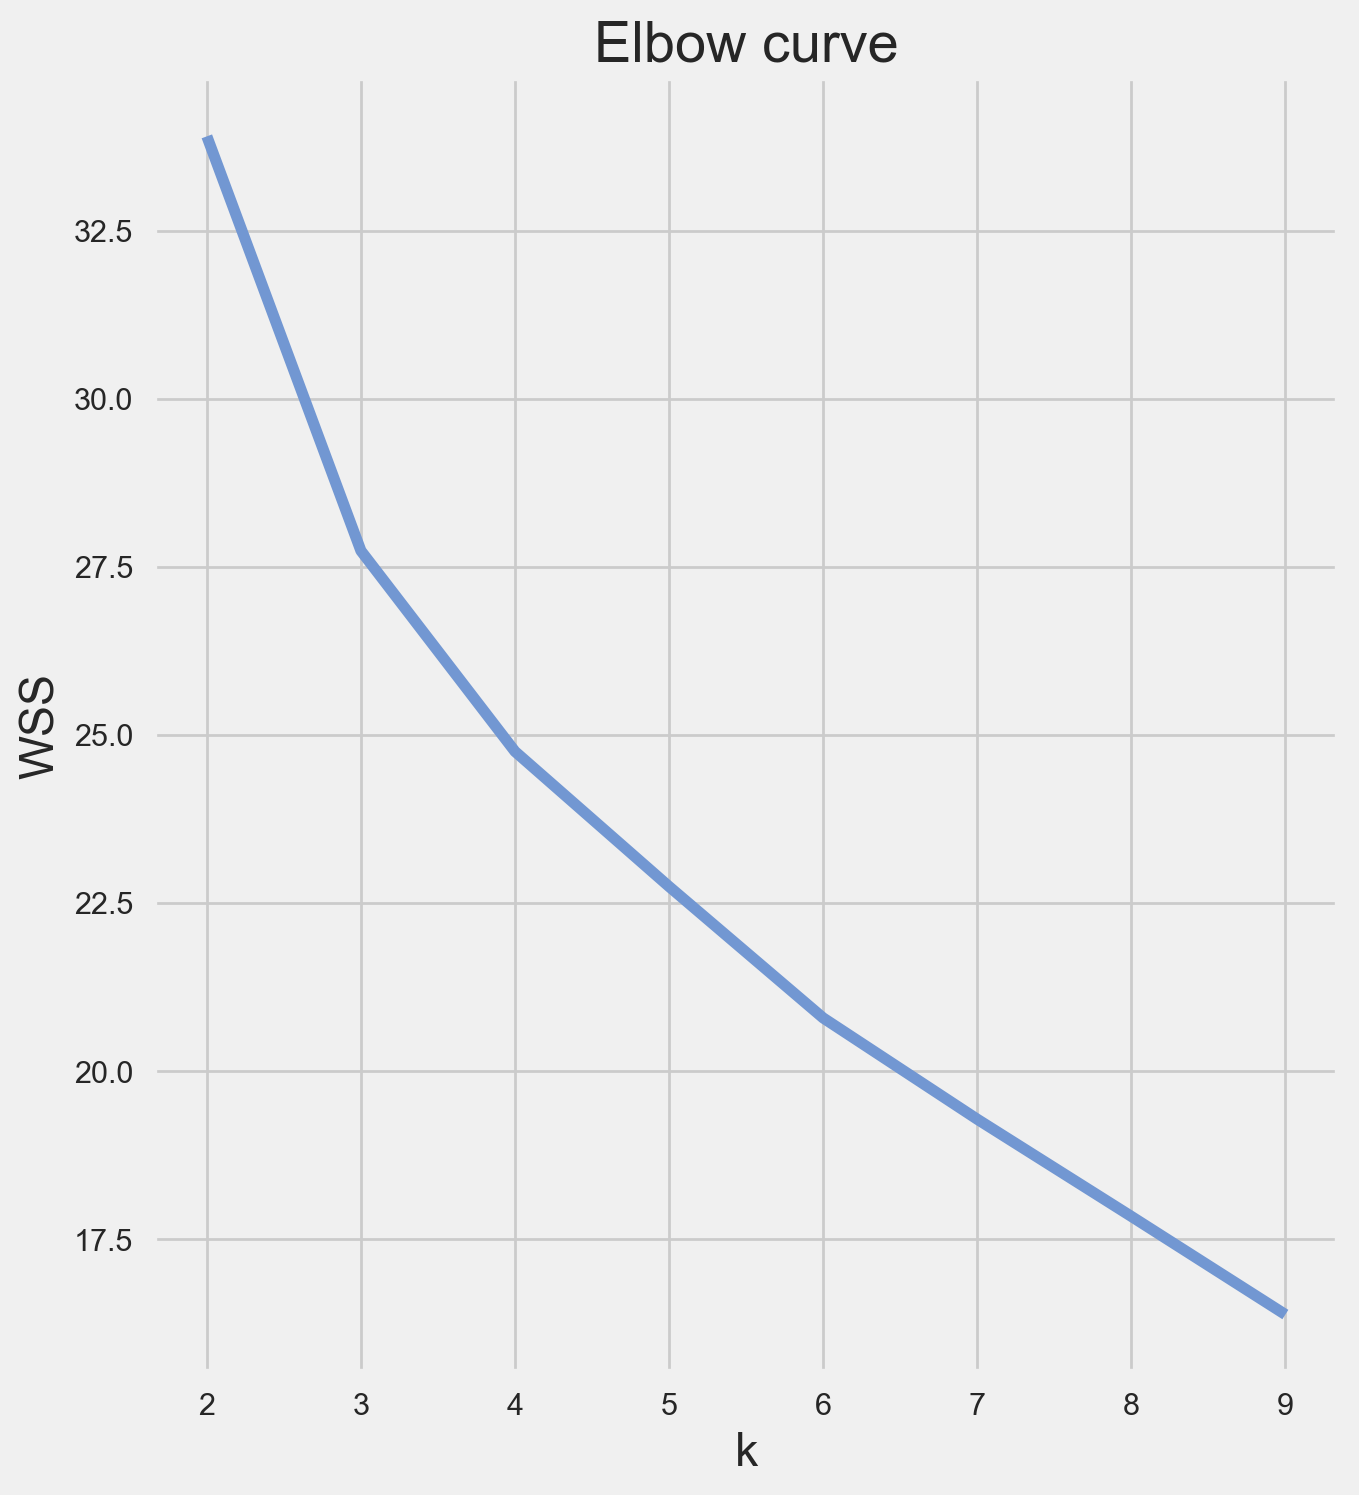

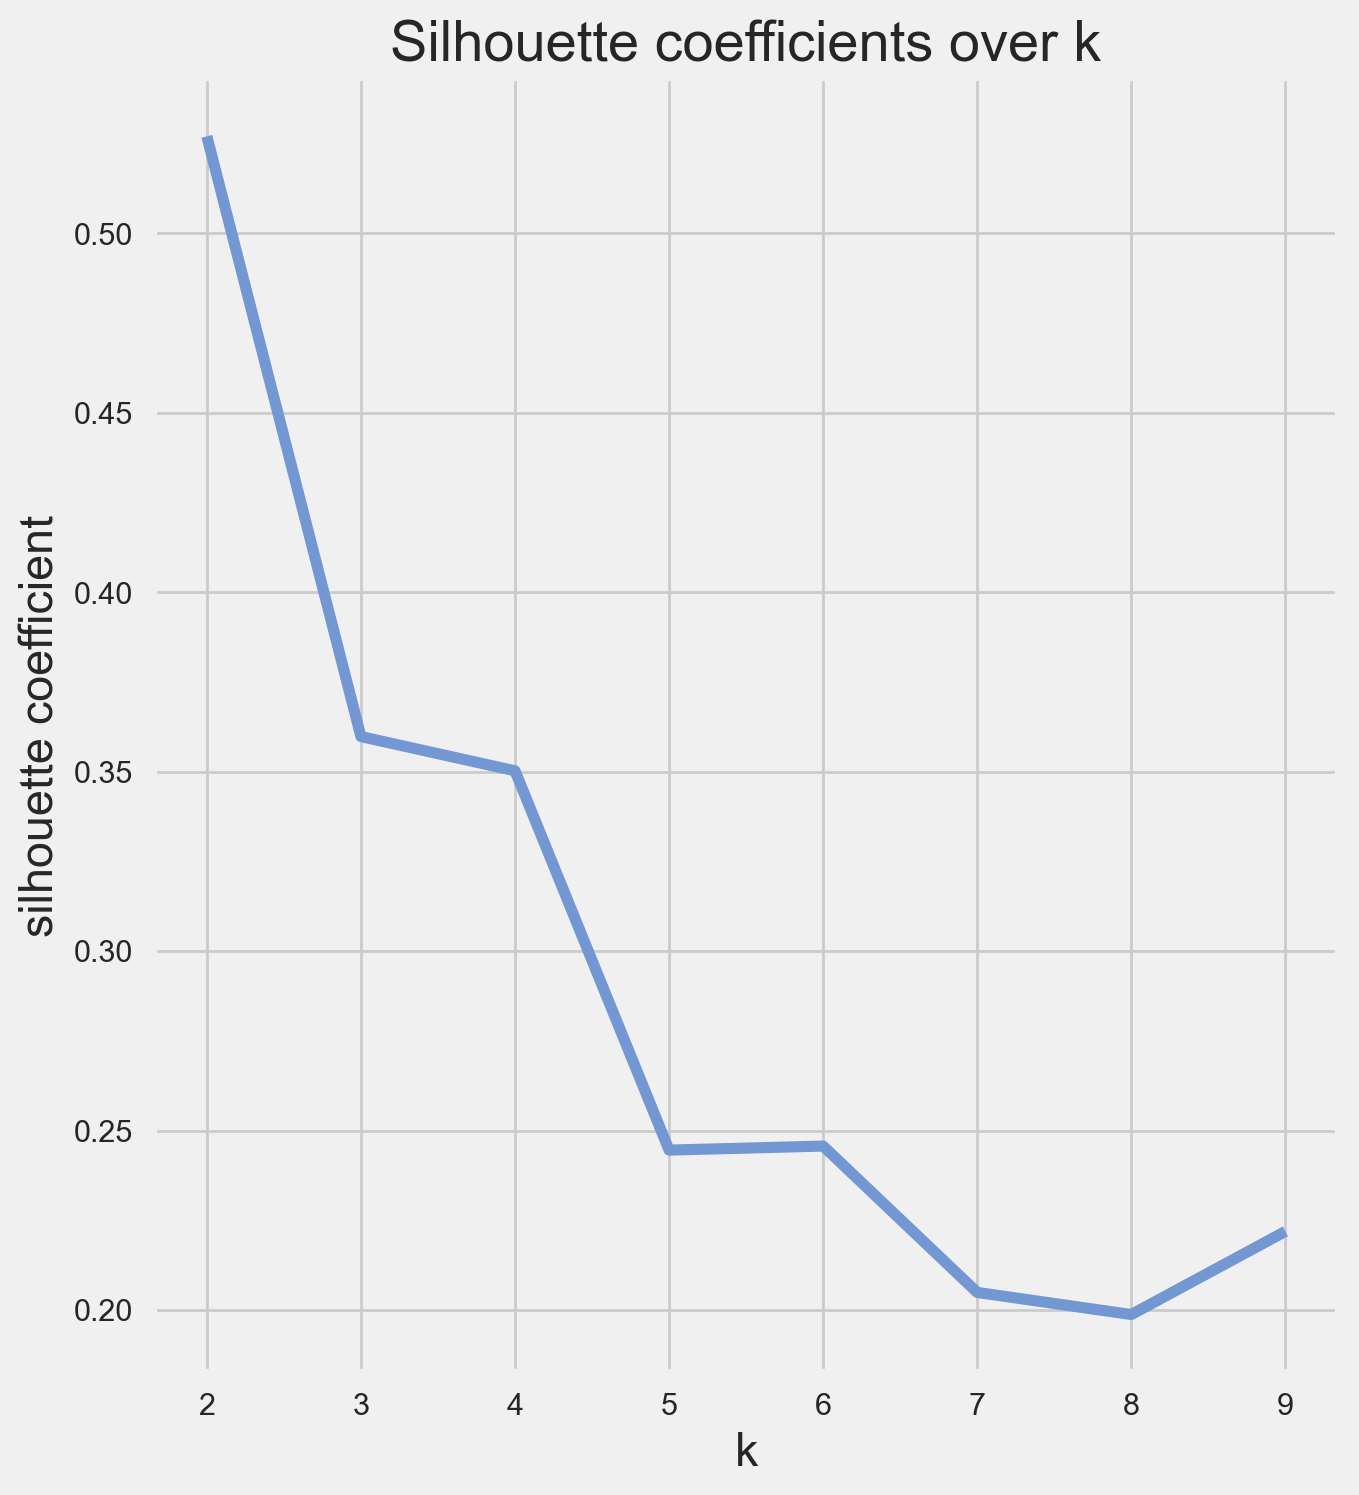

In [60]:
# let this variable be the different dfs I create to test the different variables

v = df_scaled_gent4 # change this to test different feature subsets



X = v.copy()


distorsions = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state = 301)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

    # Plot values of SSE
plt.figure(figsize=(15,8),dpi=100)
plt.subplot(121, title='Elbow curve')
plt.xlabel('k')
plt.ylabel('WSS')
plt.plot(range(2, 10), distorsions)
plt.grid(True)

    # check silhouette
silhouette_plot = []
    # Calculate silhouette coefficient for different K
for k in range(2, 10):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)
    # Plot Silhouette coefficient
plt.figure(figsize=(15,8), dpi=100)
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(2, 10), silhouette_plot)
#plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
plt.grid(True)

In [61]:
# fit the model with the scaled dataframe
model1 = KMeans(n_clusters=3).fit(X)

# create a new dataframe showing the clusters and scaled data
cluster_df = pd.DataFrame()
cluster_df['tractid']=X.index.values
cluster_df['cluster']=model1.labels_
#cluster_df1 = helper.create_cluster_df(model1,df_scaled)

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_df['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(X.values, cluster_df['cluster'])}")

Distribution of clusters:
0    1560
1     293
2     114
Name: cluster, dtype: int64
Silhouette score: 0.36036056880145106


In [62]:
# fit the model with the scaled dataframe
model1 = KMeans(n_clusters=4).fit(X)

# create a new dataframe showing the clusters and scaled data
cluster_df = pd.DataFrame()
cluster_df['tractid']=X.index.values
cluster_df['cluster']=model1.labels_
#cluster_df1 = helper.create_cluster_df(model1,df_scaled)

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_df['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(X.values, cluster_df['cluster'])}")

Distribution of clusters:
0    1422
1     255
3     252
2      38
Name: cluster, dtype: int64
Silhouette score: 0.3472523391056037


In [63]:
# fit the model with the scaled dataframe
model1 = KMeans(n_clusters=5).fit(X)

# create a new dataframe showing the clusters and scaled data
cluster_df = pd.DataFrame()
cluster_df['tractid']=X.index.values
cluster_df['cluster']=model1.labels_
#cluster_df1 = helper.create_cluster_df(model1,df_scaled)

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_df['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(X.values, cluster_df['cluster'])}")

Distribution of clusters:
3    1134
1     505
2     236
0      68
4      24
Name: cluster, dtype: int64
Silhouette score: 0.24015325160884907


# Plotting the cluster data for the two best silhouette scores

In [64]:
from shapely.geometry import Point,Polygon
import geopandas as gpd
import descartes

In [65]:
bx_g = gpd.read_file('DATA/GeoData/bronx_geodata/tl_2010_36005_tract10.shp')
bk_g = gpd.read_file('DATA/GeoData/brooklyn_geodata/tl_2010_36047_tract10.shp')
mh_g = gpd.read_file('DATA/GeoData/manhattan_geodata/tl_2010_36061_tract10.shp')
qn_g = gpd.read_file('DATA/GeoData/queens_geodata/tl_2010_36081_tract10.shp')

In [66]:
bk_g.rename(columns={'GEOID10':'TRACTID'},inplace=True)
bk_g['TRACTID'] = bk_g['TRACTID'].astype('str')
bx_g.rename(columns={'GEOID10':'TRACTID'},inplace=True)
bx_g['TRACTID'] = bx_g['TRACTID'].astype('str')
mh_g.rename(columns={'GEOID10':'TRACTID'},inplace=True)
mh_g['TRACTID'] = mh_g['TRACTID'].astype('str')
qn_g.rename(columns={'GEOID10':'TRACTID'},inplace=True)
qn_g['TRACTID'] = qn_g['TRACTID'].astype('str')

In [67]:
cluster_pca3.rename(columns={'tractid':'TRACTID'},inplace=True)
cluster_pca3['TRACTID'] = cluster_pca3['TRACTID'].astype('str')
cluster_pca3['cluster'] = cluster_pca3['cluster'].astype('str')


In [68]:
cluster_pca2.rename(columns={'tractid':'TRACTID'},inplace=True)
cluster_pca2['TRACTID'] = cluster_pca2['TRACTID'].astype('str')
cluster_pca2['cluster'] = cluster_pca2['cluster'].astype('str')


In [69]:
bk_g2 = bk_g.merge(cluster_pca2, on='TRACTID', how = 'left')
bx_g2 = bx_g.merge(cluster_pca2, on='TRACTID', how = 'left')
mh_g2 = mh_g.merge(cluster_pca2, on='TRACTID', how = 'left')
qn_g2 = qn_g.merge(cluster_pca2, on='TRACTID', how = 'left')

In [70]:
bk_g3 = bk_g.merge(cluster_pca3, on='TRACTID', how = 'left')
bx_g3 = bx_g.merge(cluster_pca3, on='TRACTID', how = 'left')
mh_g3 = mh_g.merge(cluster_pca3, on='TRACTID', how = 'left')
qn_g3 = qn_g.merge(cluster_pca3, on='TRACTID', how = 'left')

## Cluster PCA2 is had the top Silhouette Score

In [71]:
cluster_pca2.cluster.value_counts()

2    1473
1     263
0     231
Name: cluster, dtype: int64

## Cluster PCA 3 had the second highest Silhouette Score

In [72]:
cluster_pca3.cluster.value_counts()

0    1575
1     276
2     116
Name: cluster, dtype: int64

# The next step is the eye test. Determining whether the clusters present a recognizable grouping

# Secondly, interpreting the clusters in the frame of our business case

## The first model presents its take on the census tracts in Brooklyn

The value '0' seems to be those that are gentrifying.  
There is some ambiguity as to what '2' means and even what are the defining characteristics for '1'

[]

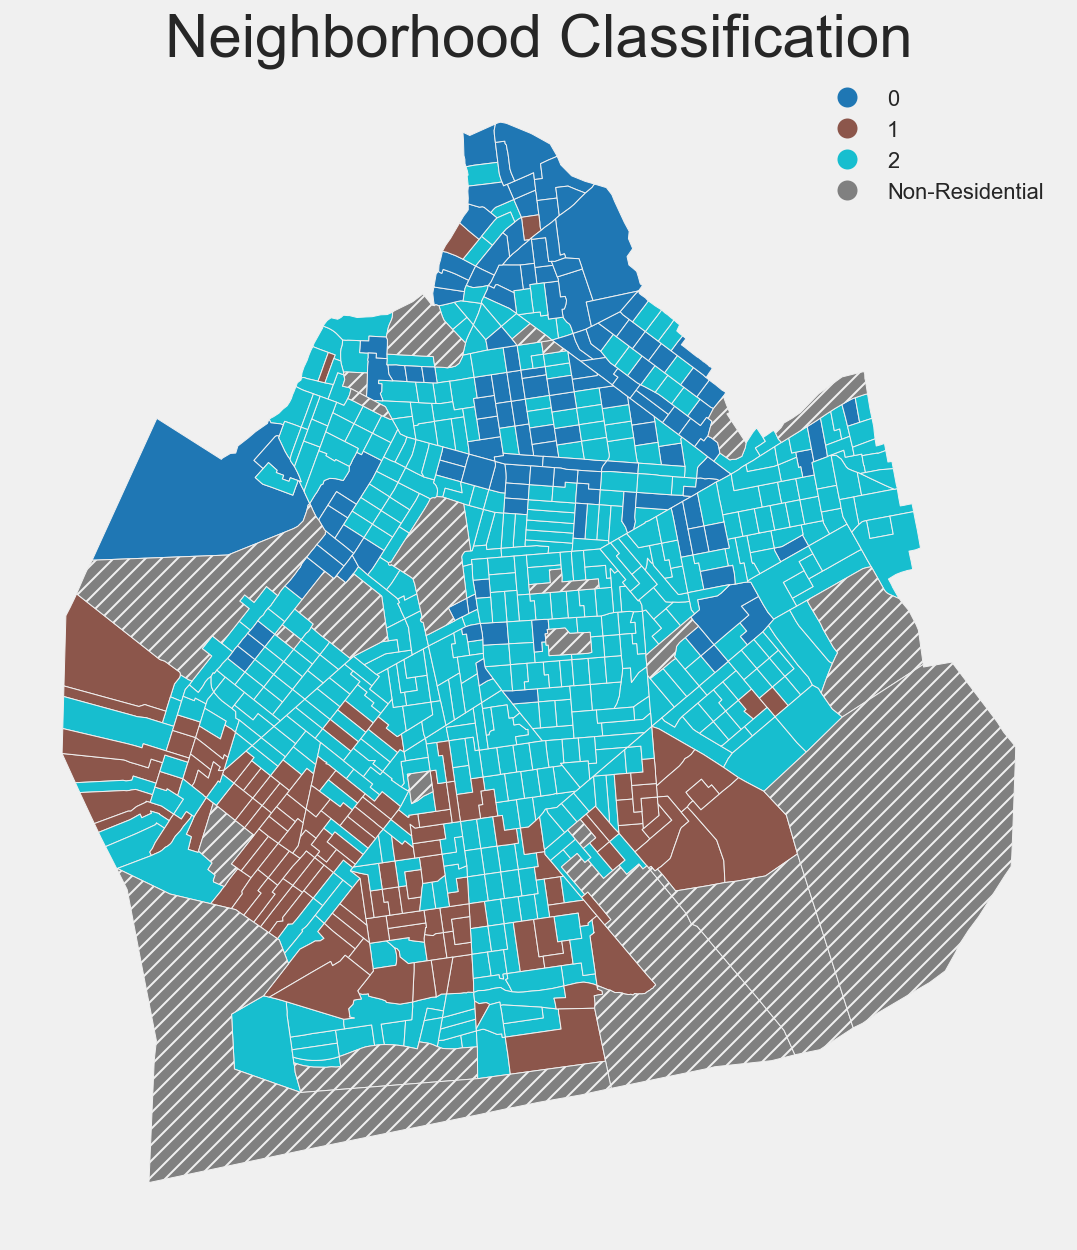

In [73]:
fig, ax = plt.subplots(figsize = (15,10))

bk_g2.plot(column='cluster', ax=ax,categorical = True, 
          legend=True, missing_kwds={'color': 'grey', "label": "Non-Residential","hatch": "///"})
ax.set_title('Neighborhood Classification',fontdict = {'fontsize': 30})
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
#plt.savefig('Images/brooklyn_map_minority_change.png', dpi=300, bbox_inches= 'tight', 
            # padding_inches = 4, transparent = True )


## The second model uses a different value for the groupings but the clusters are similar

Here, the value '2' seems to signify gentrified/gentrifying neighborhoods.  
There are some changes in the other two groups. We will have to look at the other boroughs to get an understanding for the last two clusters. 

[]

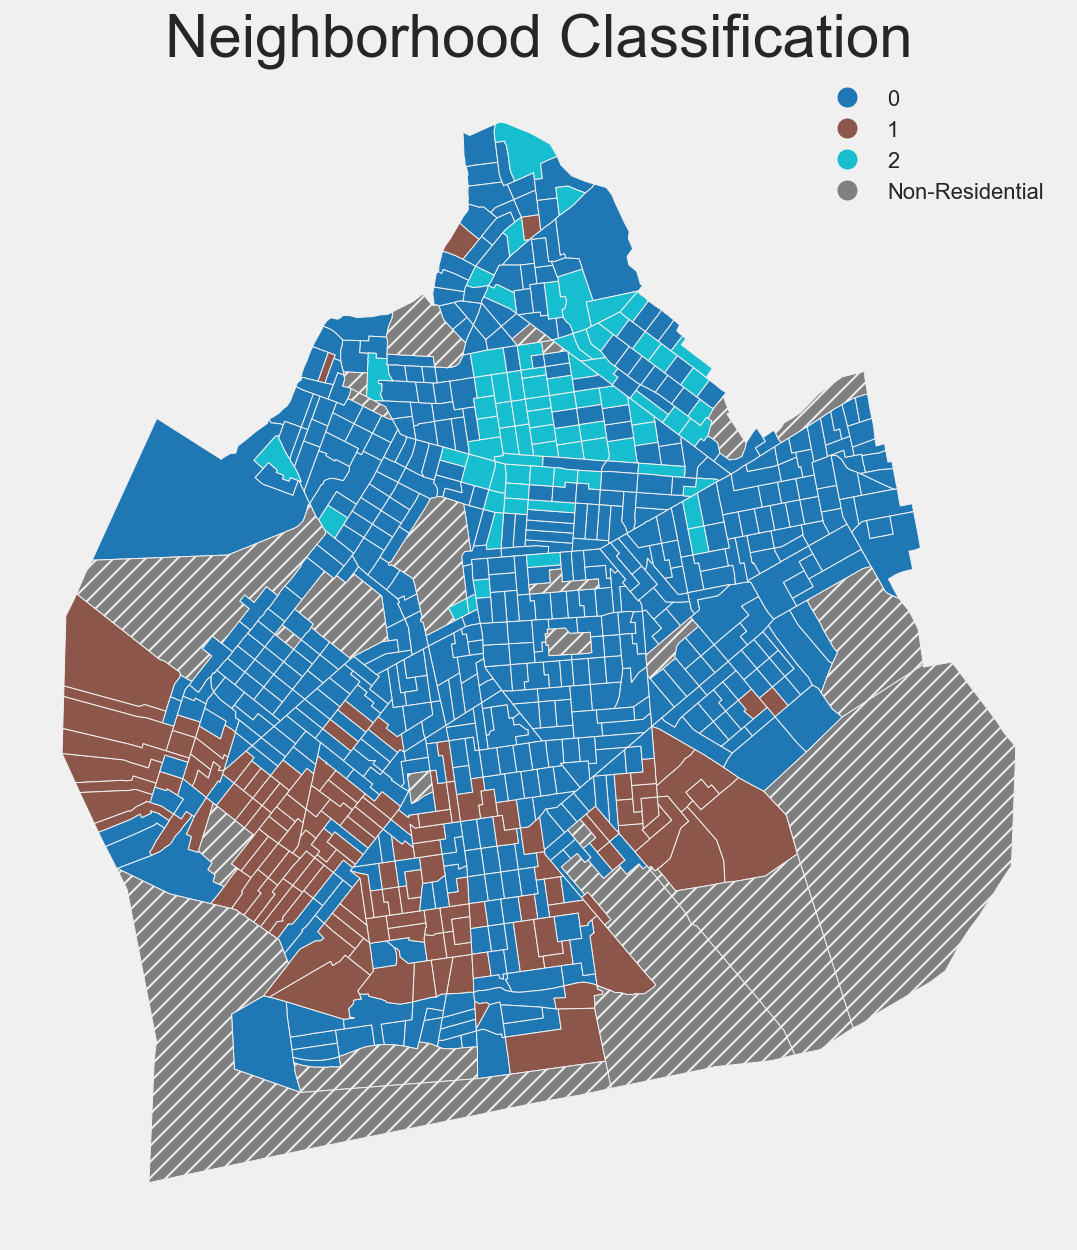

In [74]:
fig, ax = plt.subplots(figsize = (15,10))

bk_g3.plot(column='cluster', ax=ax,categorical = True, 
          legend=True, missing_kwds={'color': 'grey', "label": "Non-Residential","hatch": "///"})
ax.set_title('Neighborhood Classification',fontdict = {'fontsize': 30})
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
#plt.savefig('Images/brooklyn_map_minority_change.png', dpi=300, bbox_inches= 'tight', 
            # padding_inches = 4, transparent = True )


[]

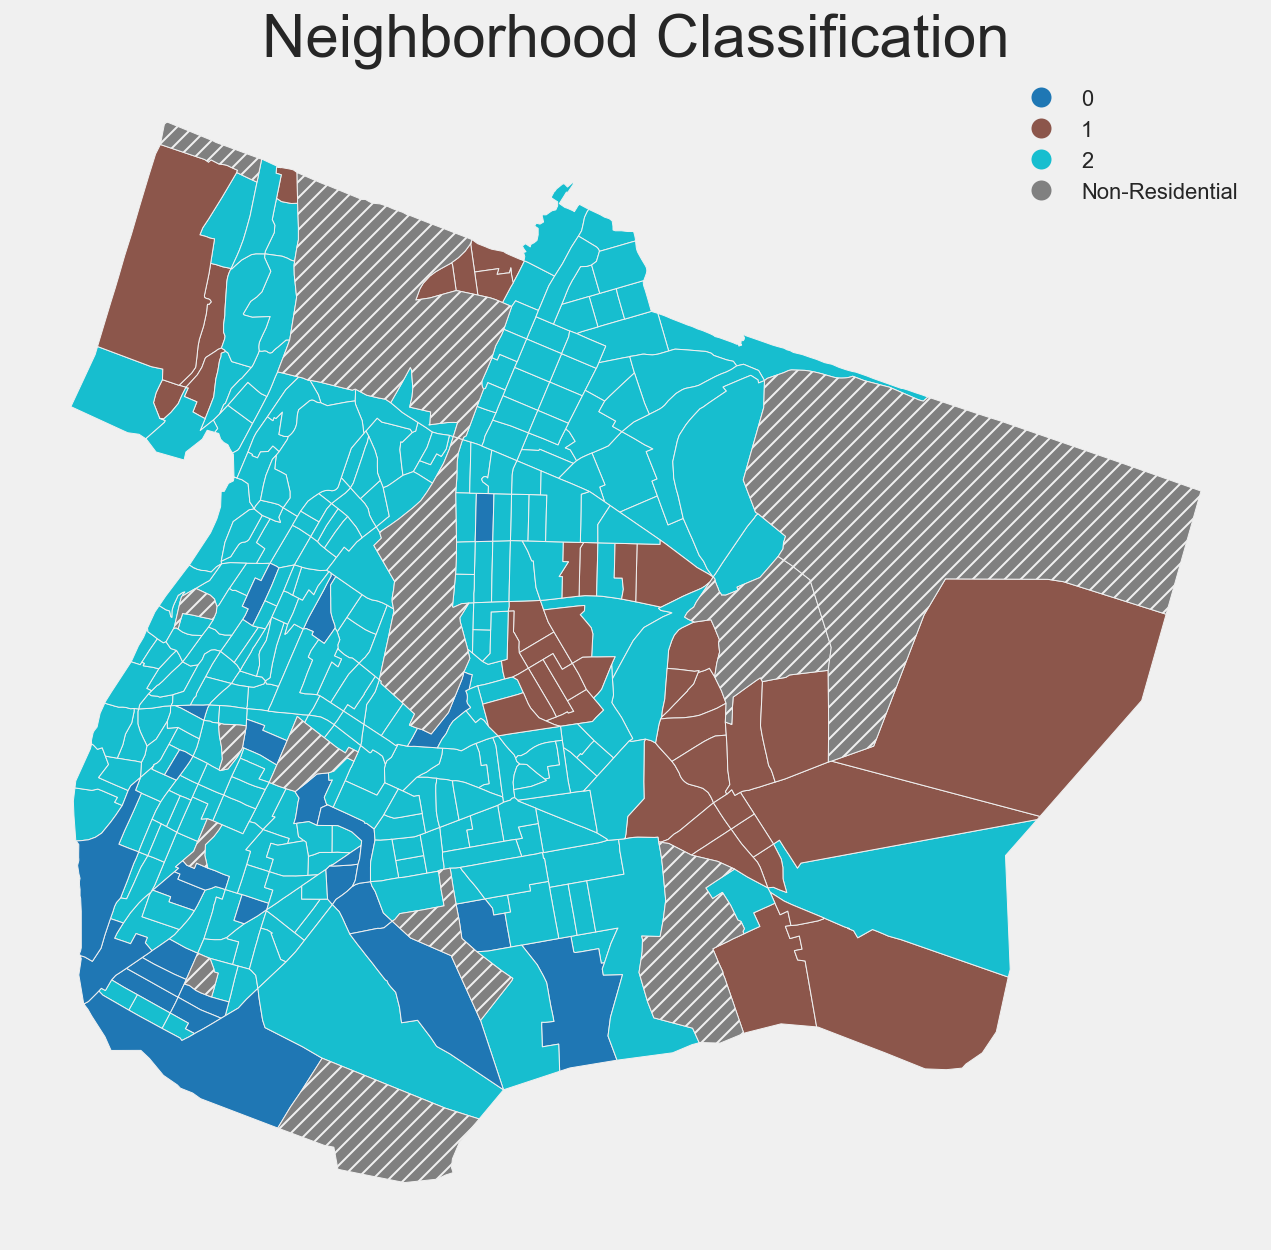

In [75]:
fig, ax = plt.subplots(figsize = (15,10))

bx_g2.plot(column = 'cluster', ax = ax,categorical = True, 
          legend = True, missing_kwds = {'color': 'grey', "label": "Non-Residential","hatch": "///"})
ax.set_title('Neighborhood Classification',fontdict = {'fontsize': 30})
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
#plt.savefig('Images/brooklyn_map_minority_change.png', dpi=300, bbox_inches= 'tight', 
            # padding_inches = 4, transparent = True )


[]

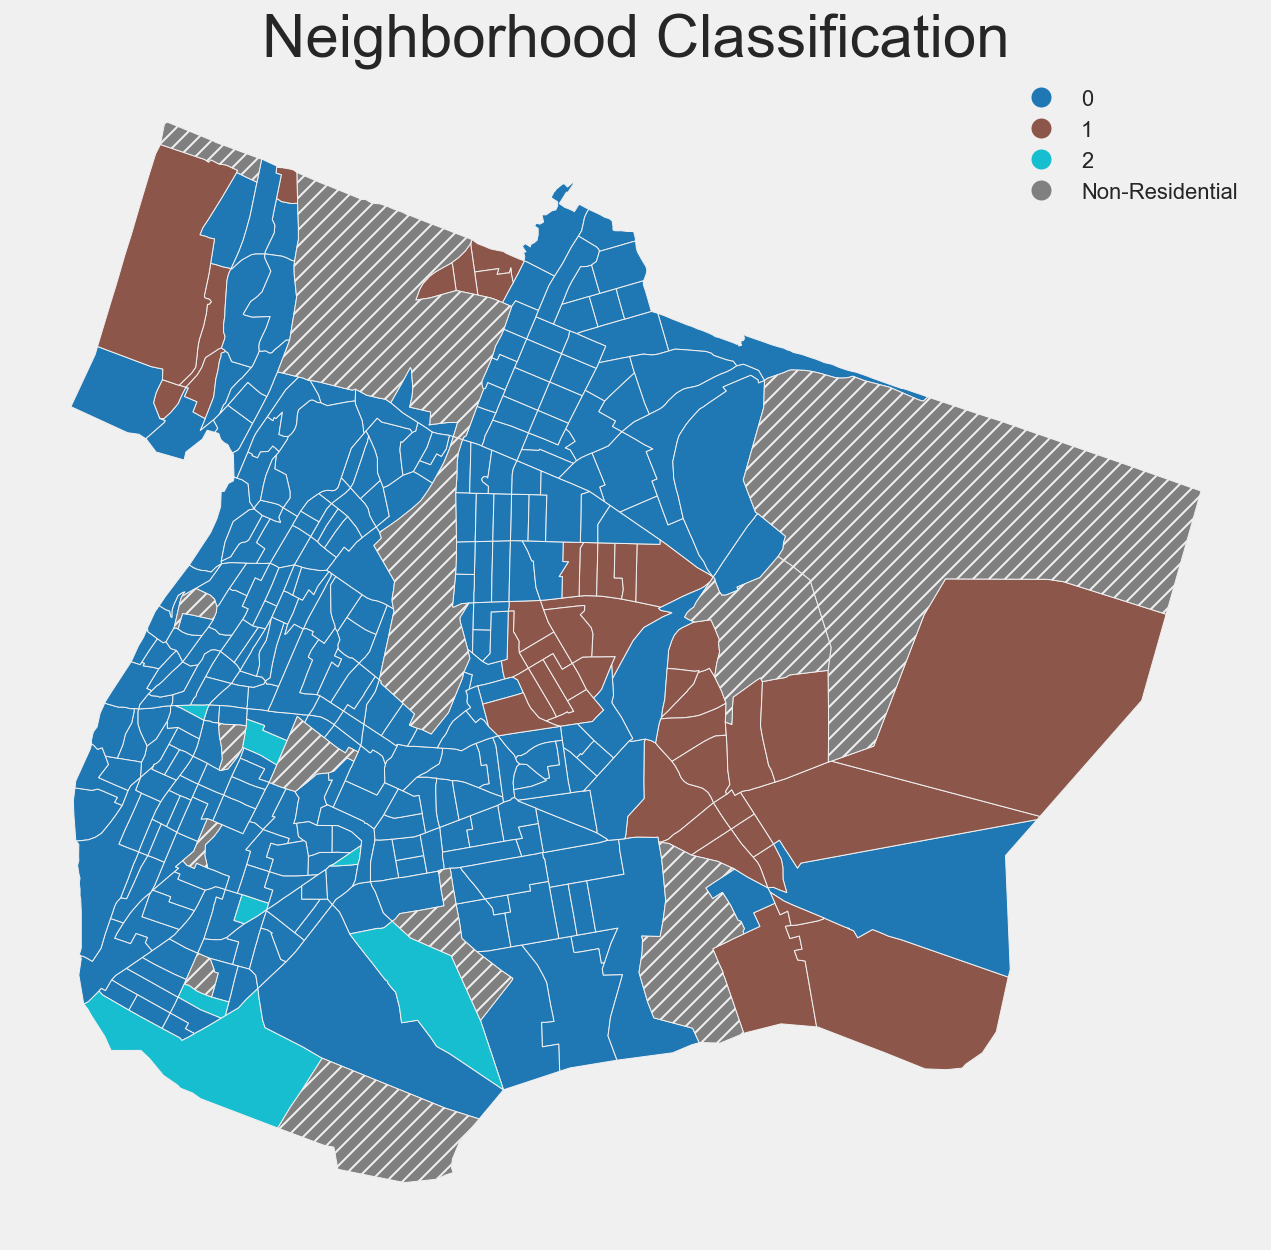

In [76]:
fig, ax = plt.subplots(figsize = (15,10))

bx_g3.plot(column = 'cluster', ax = ax,categorical = True, 
          legend = True, missing_kwds = {'color': 'grey', "label": "Non-Residential","hatch": "///"})
ax.set_title('Neighborhood Classification',fontdict = {'fontsize': 30})
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
#plt.savefig('Images/brooklyn_map_minority_change.png', dpi=300, bbox_inches= 'tight', 
            # padding_inches = 4, transparent = True )


# Manhattan's clustering helps clear up some ambiguity 

Zero still seems to be classification for gentrifying/gentrified neighborhoods.   
Two seems to give us more clarification when looking at Manhattan. The majority of neighborhoods in Manhattan are classified as two which seems to be those that have not seen a large change from 2000-2010.   
However, the One category is still confusing. 

[]

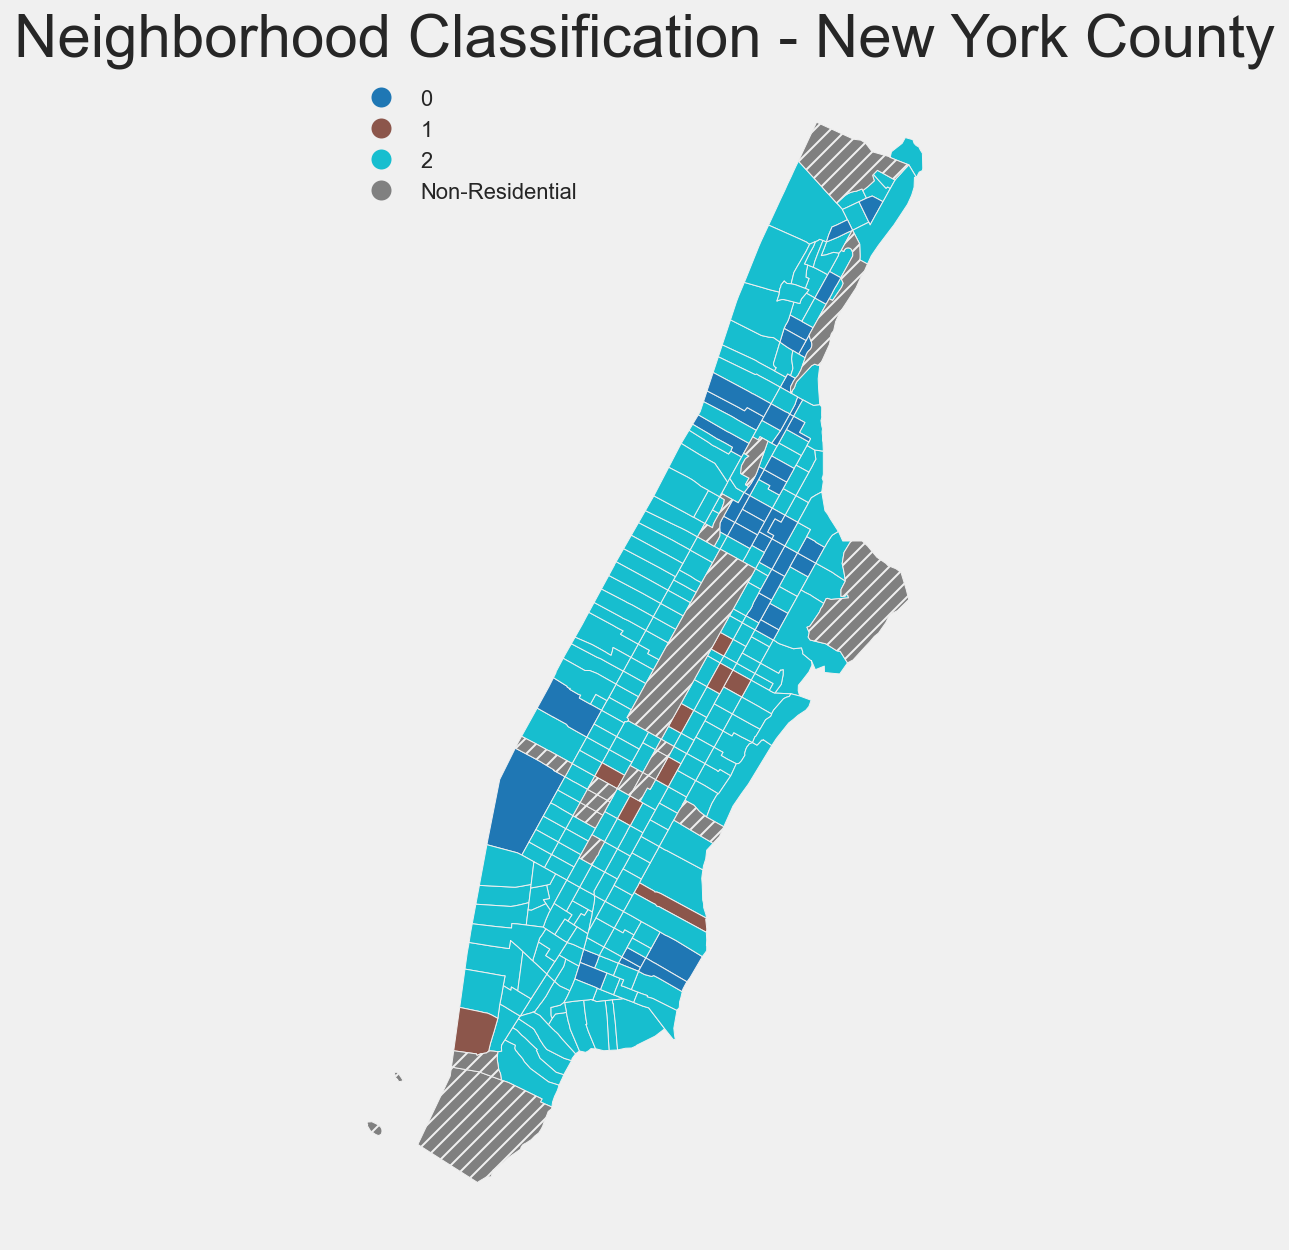

In [77]:
fig, ax = plt.subplots(figsize = (15,10))

mh_g2.plot(column='cluster', ax=ax,categorical = True, 
          legend=True, missing_kwds={'color': 'grey', "label": "Non-Residential","hatch": "///"},
          legend_kwds={'loc': 'upper left'})
ax.set_title('Neighborhood Classification - New York County',fontdict = {'fontsize': 30})
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
#plt.savefig('Images/brooklyn_map_minority_change.png', dpi=300, bbox_inches= 'tight', 
            # padding_inches = 4, transparent = True )


[]

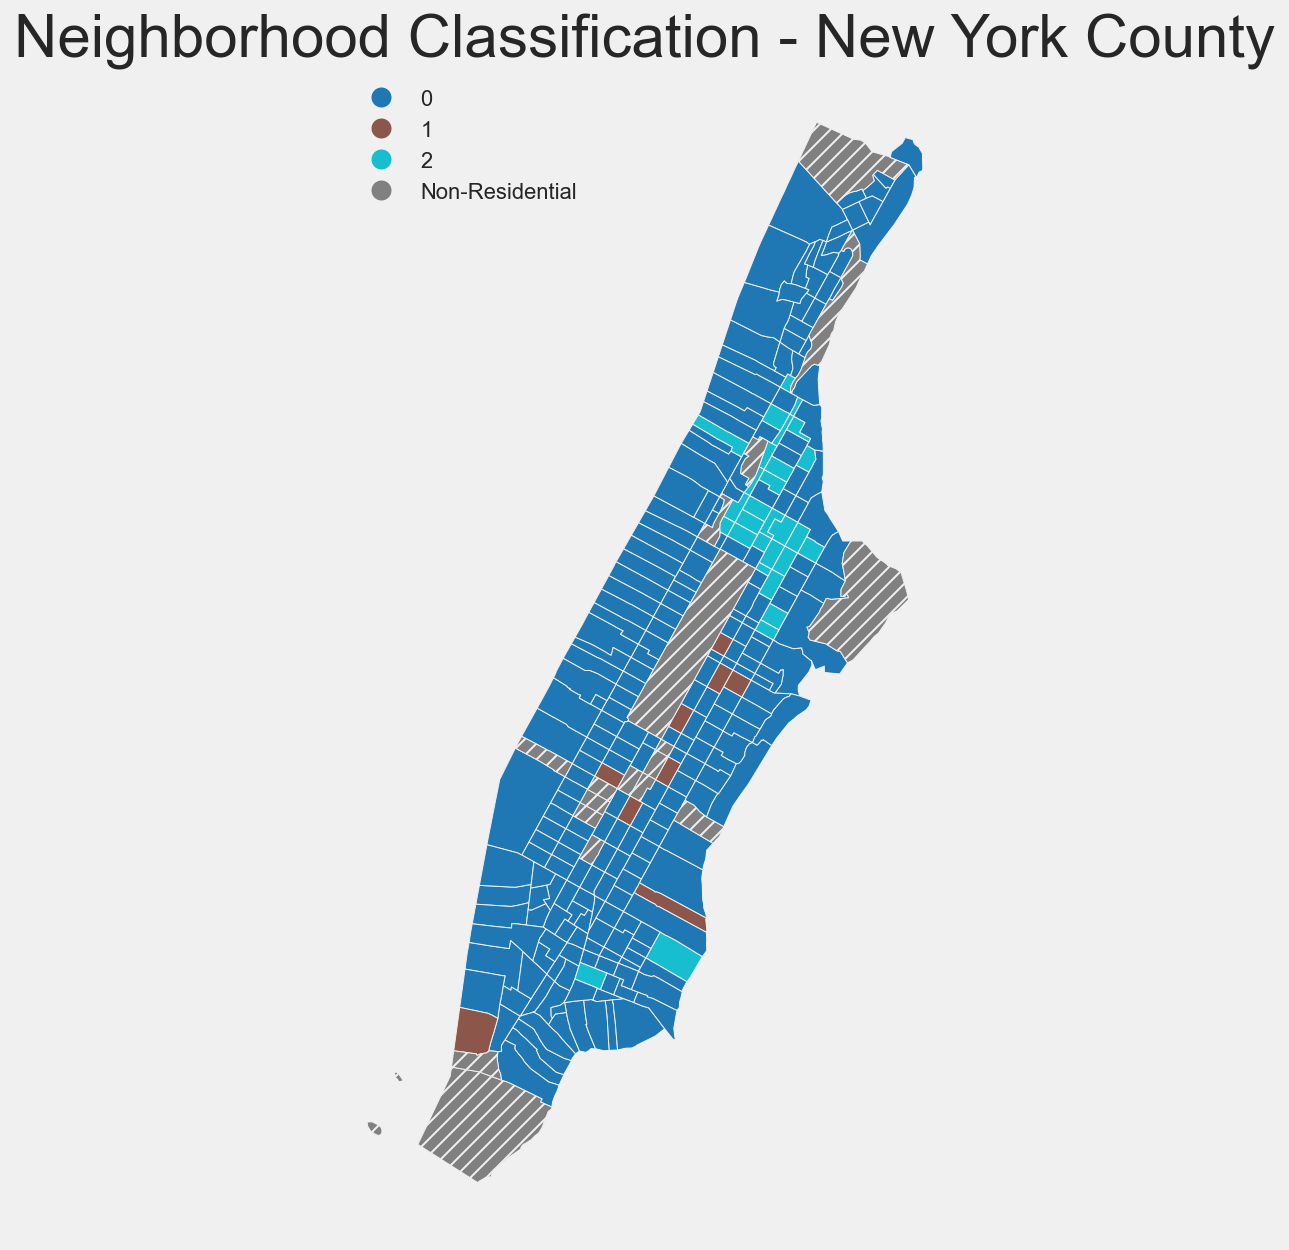

In [78]:
fig, ax = plt.subplots(figsize = (15,10))

mh_g3.plot(column='cluster', ax=ax,categorical = True, 
          legend=True, missing_kwds={'color': 'grey', "label": "Non-Residential","hatch": "///"},
          legend_kwds={'loc': 'upper left'})
ax.set_title('Neighborhood Classification - New York County',fontdict = {'fontsize': 30})
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
#plt.savefig('Images/brooklyn_map_minority_change.png', dpi=300, bbox_inches= 'tight', 
            # padding_inches = 4, transparent = True )


## My domain knowledge of Queens is not as strong as the other three boroughs. 

There wasn't much I could glean from an observation of this graph. 

[]

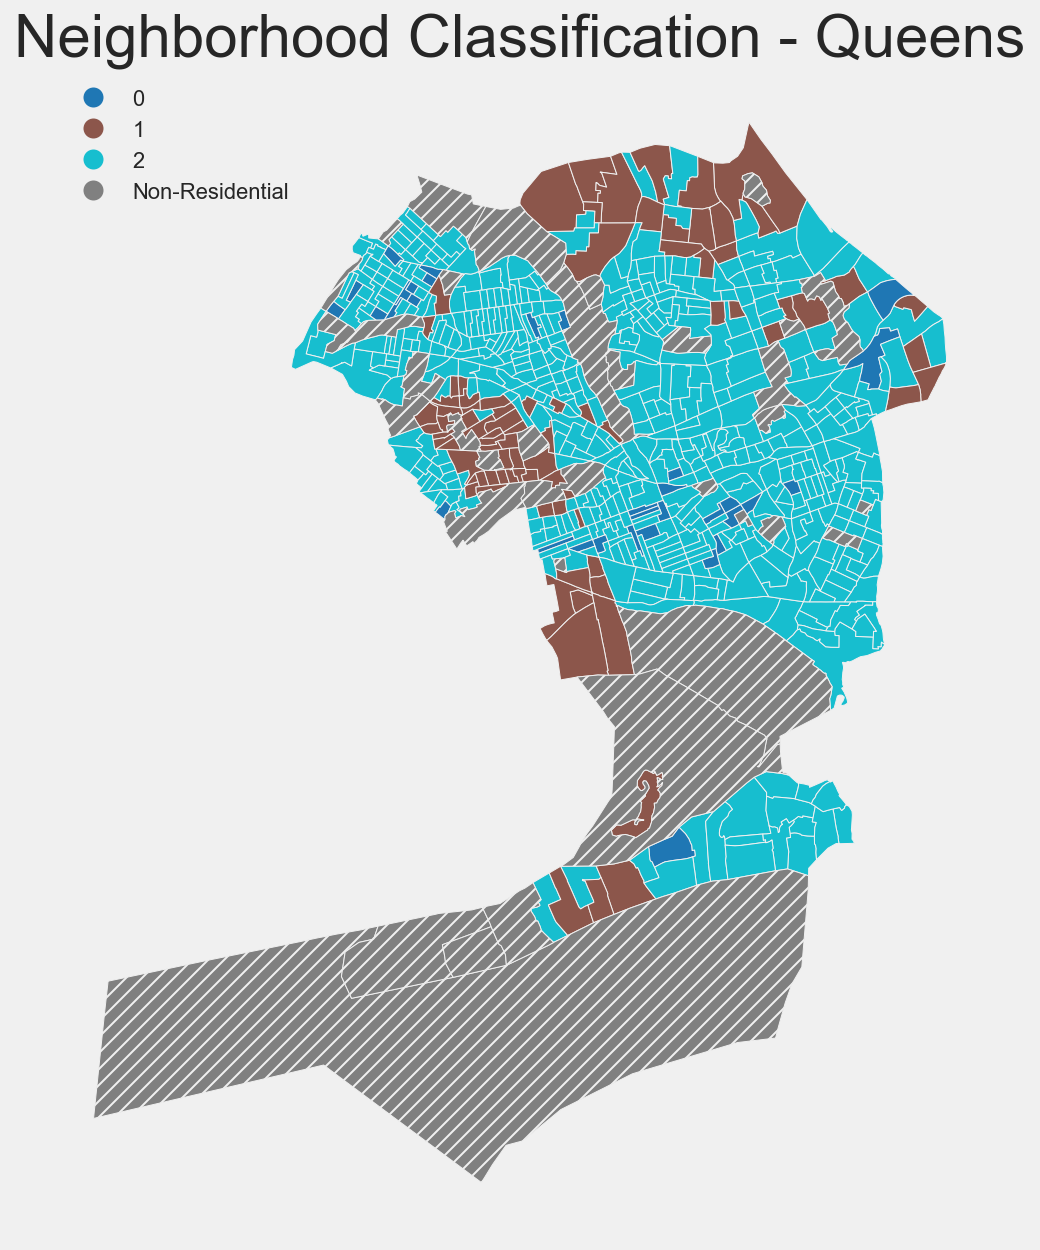

In [81]:
fig, ax = plt.subplots(figsize = (15,10))

qn_g2.plot(column='cluster', ax=ax,categorical = True, 
          legend=True, missing_kwds={'color': 'grey', "label": "Non-Residential","hatch": "///"},
          legend_kwds={'loc': 'upper left'})
ax.set_title('Neighborhood Classification - Queens',fontdict = {'fontsize': 30})
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
#plt.savefig('Images/brooklyn_map_minority_change.png', dpi=300, bbox_inches= 'tight', 
            # padding_inches = 4, transparent = True )


[]

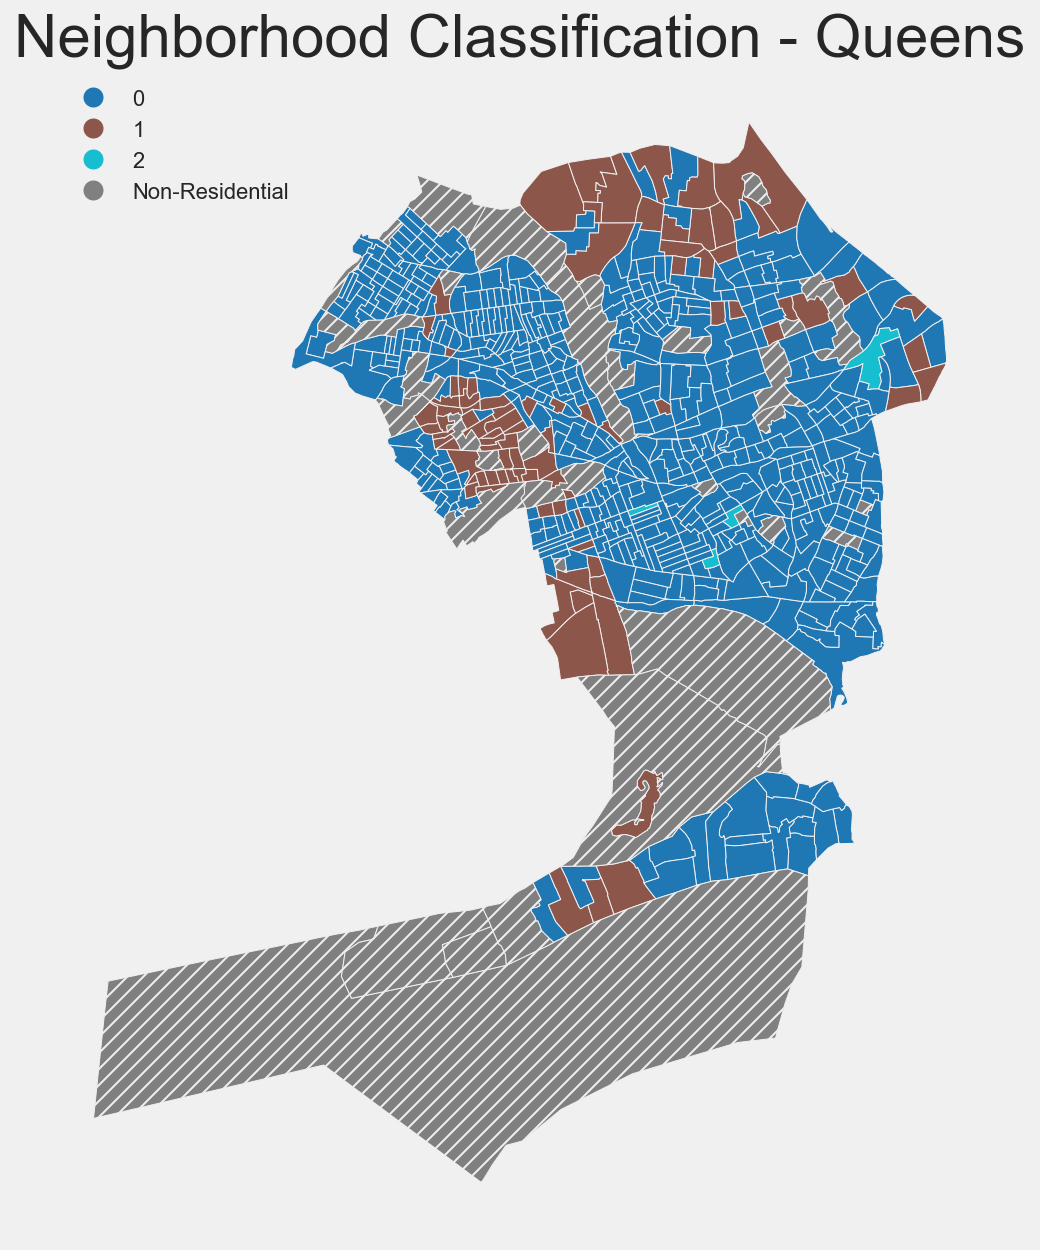

In [82]:
fig, ax = plt.subplots(figsize = (15,10))

qn_g3.plot(column='cluster', ax=ax,categorical = True, 
          legend=True, missing_kwds={'color': 'grey', "label": "Non-Residential","hatch": "///"},
          legend_kwds={'loc': 'upper left'})
ax.set_title('Neighborhood Classification - Queens',fontdict = {'fontsize': 30})
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
#plt.savefig('Images/brooklyn_map_minority_change.png', dpi=300, bbox_inches= 'tight', 
            # padding_inches = 4, transparent = True )


# There is still some ambiguity regarding the 'One' category. So I decided to look at the statistics for it. 

I first isolated these tracts and then merged them with the more comprehensive data frame in order to see what the trends were. 

In [98]:
brown = mh_g2[mh_g2['cluster'].eq('1')]

In [99]:
brown = brown.merge(df, on='TRACTID', how = 'left')

STATEFP10 COUNTYFP10 TRACTCE10      TRACTID  NAME10           NAMELSAD10  \
0        36        061    006000  36061006000      60      Census Tract 60   
1        36        061    012200  36061012200     122     Census Tract 122   
2        36        061    010000  36061010000     100     Census Tract 100   
3        36        061    015002  36061015002  150.02  Census Tract 150.02   
4        36        061    008200  36061008200      82      Census Tract 82   

  MTFCC10 FUNCSTAT10  ALAND10  AWATER10   INTPTLAT10    INTPTLON10  \
0   G5020          S   127408    305741  +40.7343900  -073.9740455   
1   G5020          S   172616         0  +40.7682812  -073.9679849   
2   G5020          S   172894         0  +40.7580653  -073.9712318   
3   G5020          S   125571         0  +40.7824499  -073.9576478   
4   G5020          S   172401         0  +40.7506132  -073.9808741   

                                            geometry cluster  POP10_POP00_%  \
0  POLYGON ((-73.97408 40.73508, -73.97312 40.734...       1      13.085986   
1  POLYGON ((-73.96706 40.76667, -73.96752 40.766...       1      -7.179356   
2  POLYGON ((-73.97096 40.75554, -73.97122 40.755...       1       9.330406   
3  POLYGON ((-73.95488 40.78336, -73.95534 40.782...       1      -7.313331   
4  POLYGON ((-73.97816 40.75146, -73.97861 40.750...       1      18.017366   

   NHWHT10%_NHWHT00%  NHBLK10%_NHBLK00%  NTV10%_NTV00%  ASIAN10%_ASIAN00%  \
0         -11.113286          31.081930     165.284859         185.599466   
1          -4.373416         -28.176897     115.469309          39.226323   
2         -15.208673         435.075301      52.443106          54.825029   
3          -3.253599          10.235824     187.707682          49.174965   
4         -12.178813          75.861550     267.177601          76.472093   

   HISP10%_HISP00%  HAW10%_HAW00%  INDIA10%_INDIA00%  CHINA10%_CHINA00%  \
0       128.535442         -100.0         607.426291          95.397988   
1        61.601982            0.0          49.171060          76.054192   
2        30.553839         -100.0         113.420348          56.975198   
3        44.519831         -100.0          79.817301          26.254701   
4        27.099939            0.0         160.476418         121.133227   

   FILIP10%_FILIP00%  JAPAN10%_JAPAN00%  KOREA10%_KOREA00%  VIET10%_VIET00%  \
0         -11.571714         128.439740         441.623254       695.854578   
1          13.259509         -13.812276         102.002477       -73.066336   
2          31.233630         -15.226761          98.176037         0.000000   
3          30.604145          56.157130         217.677232        -7.522531   
4          20.581993         -23.740037          91.065267       -36.450031   

   MEX10%_MEX00%  PR10%_PR00%  CUBAN10%_CUBAN00%  VAC10%_VAC00%  \
0     386.355575    48.433195          52.739767     139.068749   
1      61.601982    74.427536          -1.243233      42.151522   
2     128.664659    15.069957          11.791611      62.739044   
3     192.845319    12.385813          59.837601     153.162272   
4      41.222154    50.098975           0.139346      28.381754   

   OHU10%_OHU00%  A18UND10%_A18UND00%  A60UP10%_A60UP00%  A75UP10%_A75UP00%  \
0      57.123910            52.614550         -31.708848         -37.987312   
1      25.400900             7.259005          29.739683          39.897610   
2      27.579034            14.780691          -1.216867           9.470955   
3      87.272791             1.935969          41.950293          58.812780   
4      18.738424            79.190077           0.089488         -10.870169   

   AGEWHT10%_AGEWHT00%  A15WHT10%_A15WHT00%  A60WHT10%_A60WHT00%  \
0           -11.113286            41.559568           -34.363922   
1            -4.373416            -4.139326            26.356509   
2           -15.208673             8.615713           -10.439675   
3            -3.253599            -8.781656            41.837420   
4           -12.178813        

In [102]:
brown = brown[['TRACTID', 'cluster', 'POP10_POP00_%',
       'NHWHT10%_NHWHT00%', 'NHBLK10%_NHBLK00%', 'NTV10%_NTV00%',
       'ASIAN10%_ASIAN00%', 'HISP10%_HISP00%', 'HAW10%_HAW00%',
       'INDIA10%_INDIA00%', 'CHINA10%_CHINA00%', 'FILIP10%_FILIP00%',
       'JAPAN10%_JAPAN00%', 'KOREA10%_KOREA00%', 'VIET10%_VIET00%',
       'MEX10%_MEX00%', 'PR10%_PR00%', 'CUBAN10%_CUBAN00%',
       'VAC10%_VAC00%', 'OHU10%_OHU00%', 'A18UND10%_A18UND00%',
       'A60UP10%_A60UP00%', 'A75UP10%_A75UP00%', 'AGEWHT10%_AGEWHT00%',
       'A15WHT10%_A15WHT00%', 'A60WHT10%_A60WHT00%',
       'AGEBLK10%_AGEBLK00%', 'A15BLK10%_A15BLK00%',
       'A60BLK10%_A60BLK00%', 'AGEHSP10%_AGEHSP00%',
       'A15HSP10%_A15HSP00%', 'A60HSP10%_A60HSP00%',
       'AGENTV10%_AGENTV00%', 'A15NTV10%_A15NTV00%',
       'A60NTV10%_A60NTV00%', 'AGEASN10%_AGEASN00%',
       'A15ASN10%_A15ASN00%', 'A60ASN10%_A60ASN00%',
       'FAMILY10%_FAMILY00%', 'FHH10%_FHH00%', 'OWN10%_OWN00%',
       'RENT10%_RENT00%', 'NONWHT10%_NONWHT00%', 'AG15UP12%_AG15UP00%',
       'AG18CV12%_AG18CV00%', 'AG25UP12%_AG25UP00%', 'AG5UP12%_AG5UP00%',
       'CLF12%_CLF00%', 'COL12%_COL00%', 'DAPOV12%_DAPOV00%',
       'DBPOV12%_DBPOV00%', 'DFLABF12%_DFLABF00%', 'DFMPOV12%_DFMPOV00%',
       'DHPOV12%_DHPOV00%', 'DMULTI12_DMULTI00', 'DNAPOV12%_DNAPOV00%',
       'DPOV12%_DPOV00%', 'DWPOV12%_DWPOV00%', 'EMPCLF12%_EMPCLF00%',
       'FB12%_FB00%', 'FLABF12%_FLABF00%', 'GEANC12%_GEANC00%',
       'GEFB12%_GEFB00%', 'H10YRS12%_H10YRS00%', 'H30OLD12%_H30OLD00%',
       'HH12_HH00', 'HHA12%_HHA00%', 'HHB12%_HHB00%', 'HHH12%_HHH00%',
       'HHW12%_HHW00%', 'HINC12_HINC00', 'HINCA12_HINCA00',
       'HINCB12_HINCB00', 'HINCH12_HINCH00', 'HINCW12_HINCW00',
       'HS12%_HS00%', 'INCPC12_INCPC00', 'IRANC12%_IRANC00%',
       'IRFB12%_IRFB00%', 'ITANC12%_ITANC00%', 'ITFB12%_ITFB00%',
       'LEP12%_LEP00%', 'MANUF12%_MANUF00%', 'MHMVAL12_MHMVAL00',
       'MRENT12_MRENT00', 'MULTI12_MULTI00', 'Mar-12%_Mar-00%',
       'N10IMM12%_N10IMM00%', 'N65POV12%_N65POV00%', 'NAPOV12%_NAPOV00%',
       'NAT12%_NAT00%', 'NBPOV12%_NBPOV00%', 'NFMPOV12%_NFMPOV00%',
       'NHPOV12%_NHPOV00%', 'NNAPOV12%_NNAPOV00%',
       'NONWHT_POV12%_NONWHT_POV00%', 'NPOV12%_NPOV00%',
       'NWPOV12%_NWPOV00%', 'OHU12%_OHU00SP%', 'OLANG12%_OLANG00%',
       'PROF12%_PROF00%', 'RUANC12%_RUANC00%', 'RUFB12%_RUFB00%',
       'SCANC12%_SCANC00%', 'SCFB12%_SCFB00%', 'SEMP12%_SEMP00%',
       'UNEMP12%_UNEMP00%', 'VET12%_VET00%', 'WDS12%_WDS00%']]

In [110]:
brown.describe()

POP10_POP00_%  NHWHT10%_NHWHT00%  NHBLK10%_NHBLK00%  NTV10%_NTV00%  \
count       9.000000           9.000000           9.000000       9.000000   
mean        4.124507         -10.901229          78.852186      98.406926   
std        15.712000           7.230120         138.528624      92.537448   
min       -20.284698         -25.160738         -28.176897     -21.595982   
25%        -7.179356         -15.208673          10.235824      40.056368   
50%         0.760898         -11.113286          31.081930      54.380875   
75%        13.085986          -4.574429          75.861550     165.284859   
max        32.035359          -3.253599         435.075301     267.177601   

       ASIAN10%_ASIAN00%  HISP10%_HISP00%  HAW10%_HAW00%  INDIA10%_INDIA00%  \
count           9.000000         9.000000       9.000000           9.000000   
mean           55.872709        52.566800     -62.215959         135.133658   
std            57.770501        30.806304      57.843628         184.502549   
min           -37.795159        27.099939    -100.000000         -24.732143   
25%            43.946445        36.911962    -100.000000          49.171060   
50%            46.058456        44.519831    -100.000000          79.817301   
75%            54.825029        59.591417       0.000000         113.420348   
max           185.599466       128.535442      40.056368         607.426291   

       CHINA10%_CHINA00%  FILIP10%_FILIP00%  JAPAN10%_JAPAN00%  \
count           9.000000           9.000000           9.000000   
mean           56.939553          13.939960           3.584086   
std            48.051167          25.403455          58.382829   
min           -46.685268         -22.021905         -79.092262   
25%            43.750905         -11.571714         -17.923958   
50%            57.092575          20.581993         -13.812276   
75%            82.482463          30.604145           7.874835   
max           121.133227          52.788757         128.439740   

       KOREA10%_KOREA00%  VIET10%_VIET00%  MEX10%_MEX00%  PR10%_PR00%  \
count           9.000000         9.000000       9.000000     9.000000   
mean          120.131739       106.210775     133.978379    35.427113   
std           135.814934       242.143903     113.297190    29.123990   
min            -7.565789       -73.066336      25.446429   -10.702313   
25%            39.324499        -7.522531      44.423819    15.069957   
50%            91.065267         0.000000     128.664659    35.364790   
75%           102.002477        65.408081     173.109917    50.098975   
max           441.623254       695.854578     386.355575    74.672242   

       CUBAN10%_CUBAN00%  VAC10%_VAC00%  OHU10%_OHU00%  A18UND10%_A18UND00%  \
count           9.000000       9.000000       9.000000             9.000000   
mean           17.542654      93.931571      43.354578            21.858537   
std            37.233179      55.658513      22.646299            31.053390   
min           -51.718722      25.369316      18.738424           -30.788177   
25%            -1.243233      42.151522      25.801535             7.259005   
50%            11.791611      92.454736      37.987341            19.013458   
75%            50.535714     145.400755      57.123910            27.137374   
max            59.837601     156.655993      87.272791            79.190077   

       A60UP10%_A60UP00%  A75UP10%_A75UP00%  AGEWHT10%_AGEWHT00%  \
count           9.000000           9.000000             9.000000   
mean           26.243485          21.059067           -10.901229   
std            35.837544          34.255472             7.230120   
min           -31.708848         -37.987312           -25.160738   
25%             0.089488           1.554796           -15.208673   
50%            25.321939          24.336283           -11.113286   
75%            41.950293          39.897610            -4.574429   
max            85.981163          70.068447            -3.253599   

       A15WHT10%_A15WHT

In [111]:
cluster_pca2.to_pickle('PKL/cluster_pca2.pkl')

# Now that we have some idea about the makeup of the brown areas on the map. We can make a hypothesis

While the other two clusters are well defined, there seems to be a lot of ambiguity in the cluster in the middle. Notable observations in this cluster are Battery Park City in Manhattan, Riverdale in the Bronx, and Western Williamsburg in Brooklyn. 

There are other entries like many in midtown in Manhattan and the eastern reaches of the Bronx. The motley combination of these neighborhoods was quite difficult to place into a unified theme so I went with a split. 

I finally settled on the idea that the clustering was a mixture of misidentified census tracts and census tracts that the algorithm determined are less desirable and would mean an influx of vulnerable populations. 

An example of misidentified observations are the neighborhoods like Riverdale, those in midtown, and even Williamsburg. They are not seeing levels of gentrification and certainly are not neighborhoods where the less fortunate are being forced to relocate. 

An example of the less desirable neighborhoods are those like eastern Bronx, Bay Ridge, Bensonhurst and Sheepshead Bay which are much further away from public transportation and many job sites. 

An interesting inclusion is that of Battery Park City. This area is extremely residential and home to some of New York's wealthiest residents. However, we must keep in mind that it is directly adjacent from the former location of the Twin Towers and the time frame of this data set is from 2000-2010. During this time, there was a mass evacuation of the area and few were allowed to return for long periods of time. The sudden decrease of population, value, and income would've made this area seem like a terrible place to live. Fitting it in with other undesirable neighborhoods. 